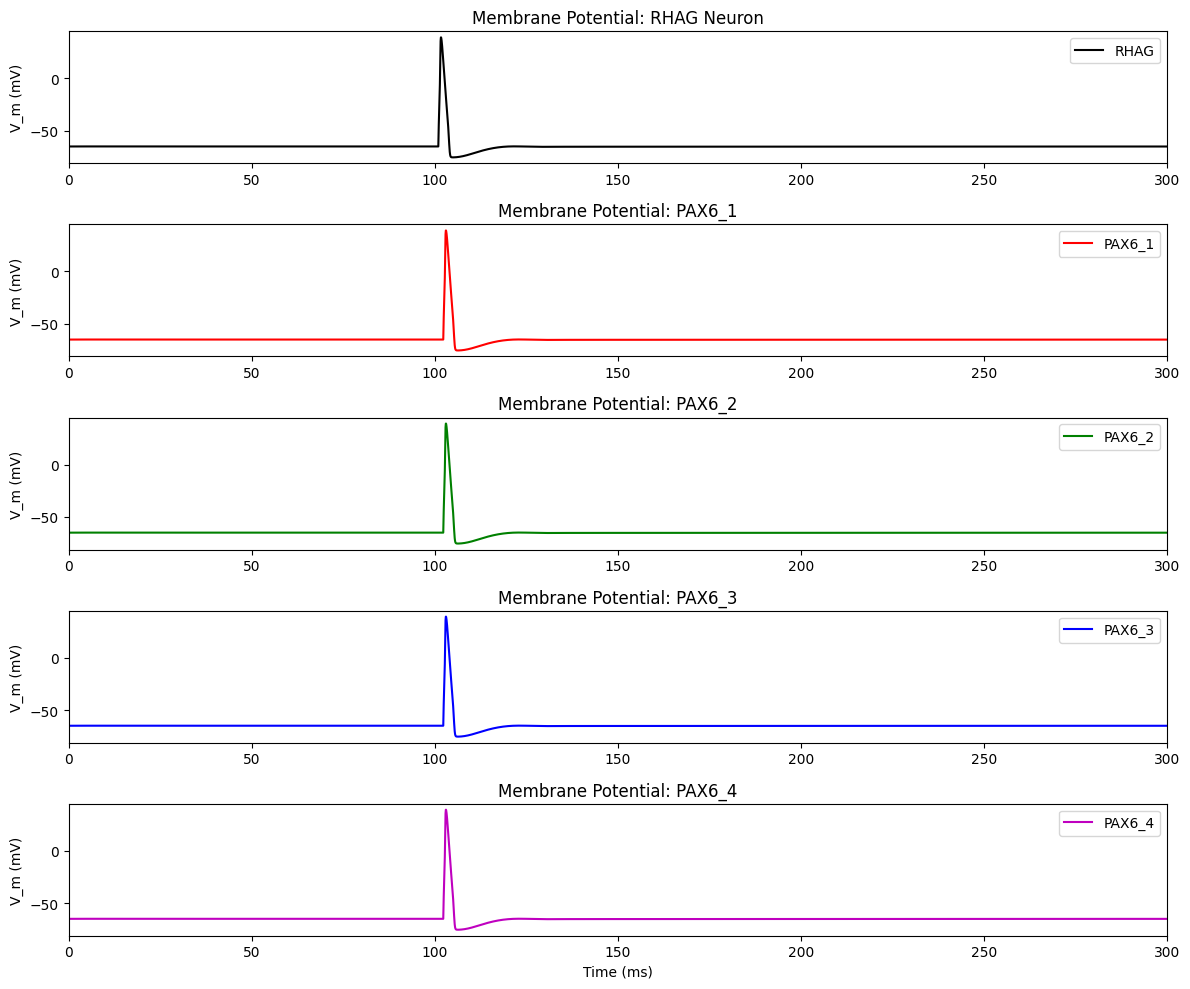

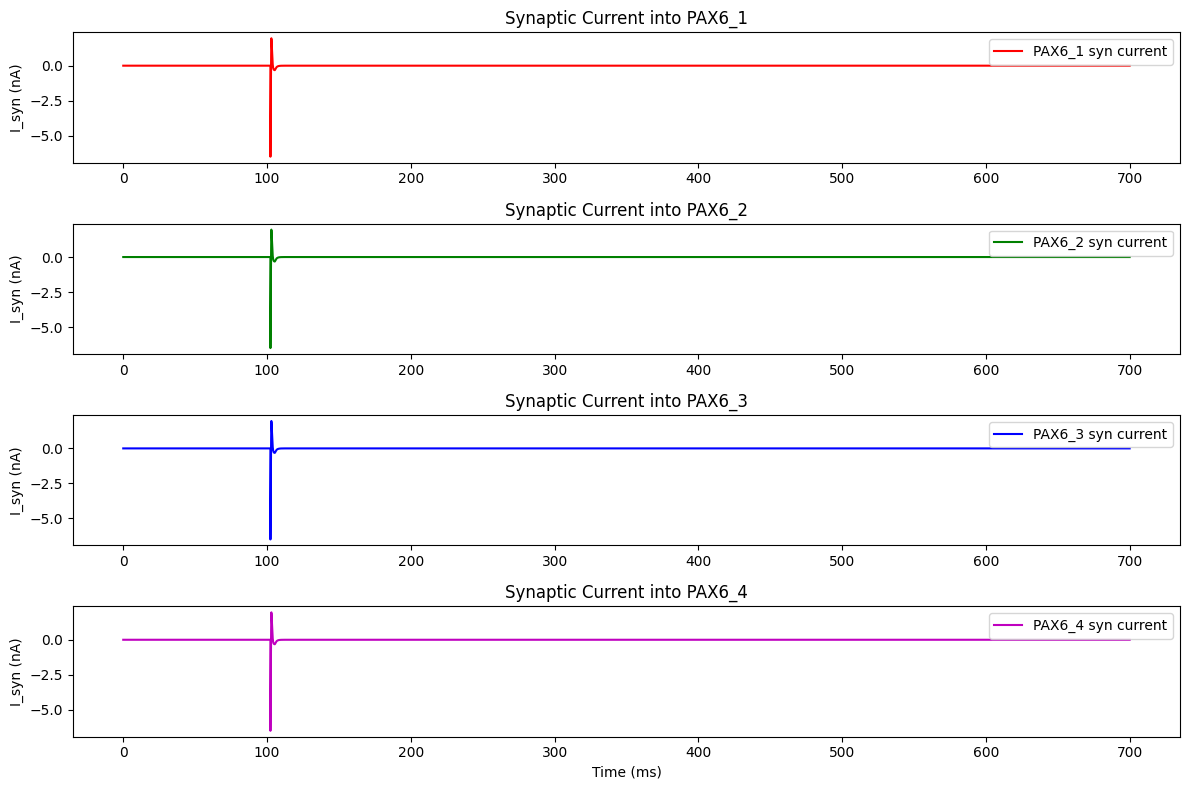

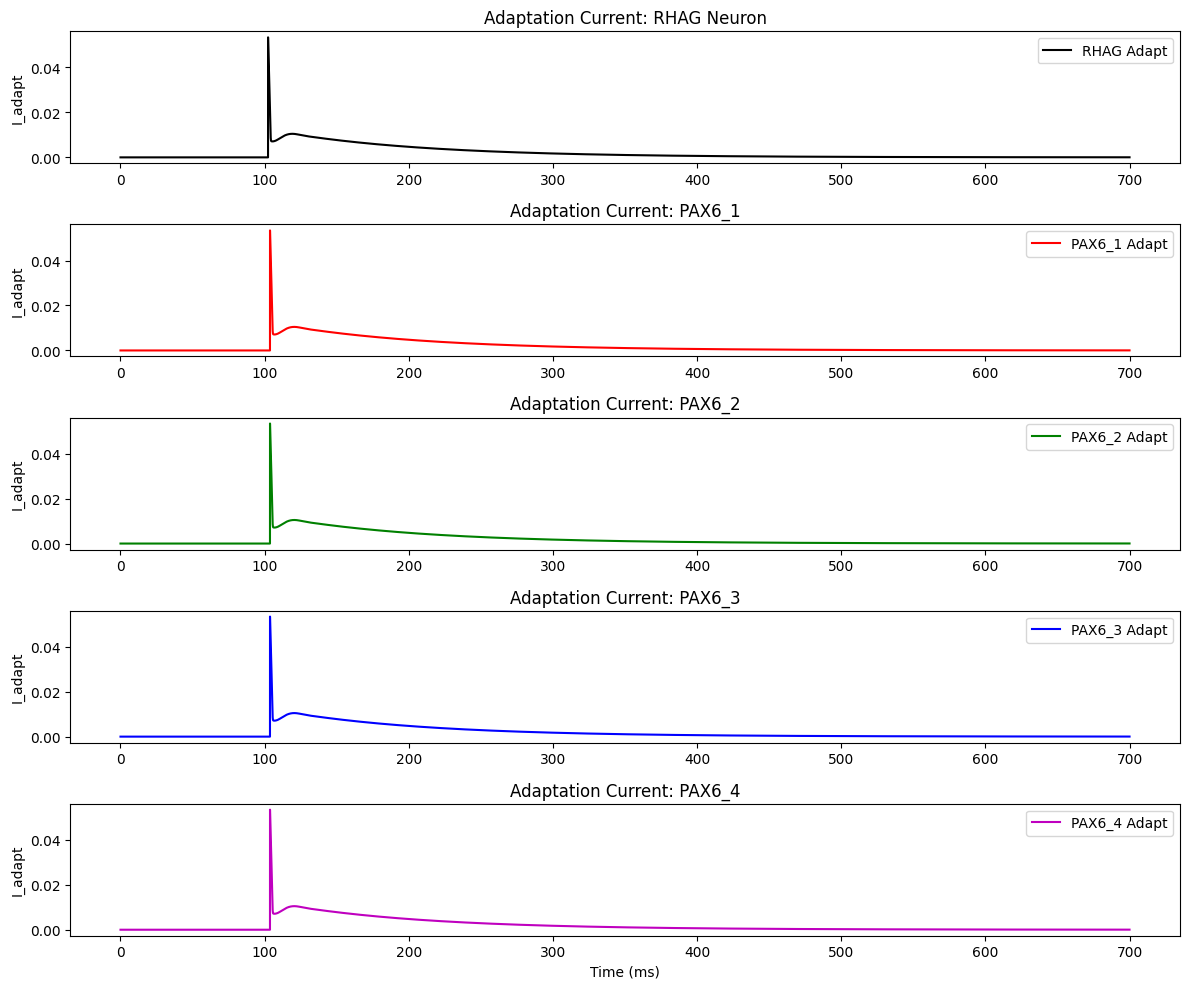

RHAG spikes: 1 at times [101.35]
PAX6_1 spikes: 1 at times [102.7]
PAX6_2 spikes: 1 at times [102.7]
PAX6_3 spikes: 1 at times [102.7]
PAX6_4 spikes: 1 at times [102.7]


In [2]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

# --- RHAG neuron setup ---
h.load_file("stdrun.hoc")

# Create RHAG neuron
rhag = h.Section(name='rhag')
rhag.L = 30
rhag.diam = 30
rhag.Ra = 100
rhag.cm = 1
rhag.insert('hh')
for seg in rhag:
    seg.hh.gnabar = 0.12
    seg.hh.gkbar = 0.036
    seg.hh.gl = 0.0003
    seg.hh.el = -54.3

# RHAG adaptation
adapt_rhag = h.Adapt(rhag(0.5))
adapt_rhag.gmax = 0.0005
adapt_rhag.tau = 100

# Detonator input to RHAG
rhag_syn = h.ExpSyn(rhag(0.5))
rhag_syn.e = 0
rhag_syn.tau = 1

rhag_stim = h.NetStim()
rhag_stim.start = 100
rhag_stim.number = 1
rhag_stim.interval = 1

nc_rhag_in = h.NetCon(rhag_stim, rhag_syn)
nc_rhag_in.weight[0] = 0.1

# --- 4 PAX6 neurons ---
pax6_cells = []
pax6_syns = []
adapt_pax6s = []
for idx in range(4):
    sec = h.Section(name=f'pax6_{idx+1}')
    sec.L = 30
    sec.diam = 30
    sec.Ra = 100
    sec.cm = 1
    sec.insert('hh')
    for s in sec:
        s.hh.gnabar = 0.12
        s.hh.gkbar = 0.036
        s.hh.gl = 0.0003
        s.hh.el = -54.3
    pax6_cells.append(sec)

    adapt = h.Adapt(sec(0.5))
    adapt.gmax = 0.0005
    adapt.tau = 100
    adapt_pax6s.append(adapt)

    syn = h.ExpSyn(sec(0.5))
    syn.e = 0
    syn.tau = 1
    pax6_syns.append(syn)

# --- Connect RHAG spike to all 4 PAX6 neurons ---
nc_from_rhag = []
for syn in pax6_syns:
    nc = h.NetCon(rhag(0.5)._ref_v, syn, sec=rhag)
    nc.threshold = -20
    nc.delay = 1   # ms after RHAG spike (adjust if needed)
    nc.weight[0] = 0.1  # Strong weight for "detonator" property
    nc_from_rhag.append(nc)

# RHAG adaptation NetCon
adapt_nc_rhag = h.NetCon(rhag(0.5)._ref_v, adapt_rhag, sec=rhag)
adapt_nc_rhag.threshold = -20
adapt_nc_rhag.weight[0] = 1

# PAX6 adaptation NetCon (one for each neuron)
nc_adapt_pax6 = []
for idx, (sec, adapt) in enumerate(zip(pax6_cells, adapt_pax6s)):
    nc = h.NetCon(sec(0.5)._ref_v, adapt, sec=sec)
    nc.threshold = -20
    nc.weight[0] = 1
    nc_adapt_pax6.append(nc)

# --- Recording vectors ---
t = h.Vector().record(h._ref_t)
v_rhag = h.Vector().record(rhag(0.5)._ref_v)
ina_rhag = h.Vector().record(rhag(0.5)._ref_ina)
ik_rhag = h.Vector().record(rhag(0.5)._ref_ik)
iadapt_rhag = h.Vector().record(adapt_rhag._ref_iadapt)
isyn_rhag = h.Vector().record(rhag_syn._ref_i)
spikes_rhag = h.Vector()
nc_rhag = h.NetCon(rhag(0.5)._ref_v, None, sec=rhag)
nc_rhag.threshold = -20
nc_rhag.record(spikes_rhag)

v_pax6 = []
spikes_pax6 = []
isyn_pax6 = []
iadapt_pax6 = []
for i, (sec, syn, adapt) in enumerate(zip(pax6_cells, pax6_syns, adapt_pax6s)):
    vvec = h.Vector().record(sec(0.5)._ref_v)
    v_pax6.append(vvec)
    spikevec = h.Vector()
    nc = h.NetCon(sec(0.5)._ref_v, None, sec=sec)
    nc.threshold = -20
    nc.record(spikevec)
    spikes_pax6.append(spikevec)
    isynvec = h.Vector().record(syn._ref_i)
    isyn_pax6.append(isynvec)
    iadaptvec = h.Vector().record(adapt._ref_iadapt)
    iadapt_pax6.append(iadaptvec)

# --- Run simulation ---
h.finitialize(-65)
h.continuerun(700)

# --- Convert to arrays ---
t = np.array(t)
v_rhag = np.array(v_rhag)
ina_rhag = np.array(ina_rhag)
ik_rhag = np.array(ik_rhag)
iadapt_rhag = np.array(iadapt_rhag)
isyn_rhag = np.array(isyn_rhag)
spikes_rhag = np.array(list(spikes_rhag))
spikes_pax6_np = [np.array(list(vec)) for vec in spikes_pax6]
# Similarly for v_pax6, etc., if those errors appear
v_pax6_np = [np.array(list(vv)) for vv in v_pax6]
isyn_pax6_np = [np.array(iv) for iv in isyn_pax6]
iadapt_pax6_np = [np.array(iav) for iav in iadapt_pax6]

# --- Plotting ---
num_pax6 = 4

# --- Membrane Potentials: RHAG and PAX6 neurons (each on own axis)
plt.figure(figsize=(12, 2 * (num_pax6 + 1)))
plt.subplot(num_pax6 + 1, 1, 1)
plt.plot(t, v_rhag, 'k', label='RHAG')
plt.ylabel('V_m (mV)')
plt.title('Membrane Potential: RHAG Neuron')
plt.legend()
plt.xlim(0, 300)
for idx, vp in enumerate(v_pax6_np):
    plt.subplot(num_pax6 + 1, 1, idx + 2)
    plt.plot(t, vp, color=['r', 'g', 'b', 'm'][idx], label=f'PAX6_{idx + 1}')
    plt.ylabel('V_m (mV)')
    plt.legend()
    plt.title(f'Membrane Potential: PAX6_{idx + 1}')
    plt.xlim(0, 300)
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

# --- Synaptic currents for each PAX6 neuron
plt.figure(figsize=(12, 2 * num_pax6))
for idx, isyn in enumerate(isyn_pax6_np):
    plt.subplot(num_pax6, 1, idx + 1)
    plt.plot(t, isyn, color=['r', 'g', 'b', 'm'][idx], label=f'PAX6_{idx + 1} syn current')
    plt.ylabel('I_syn (nA)')
    plt.legend()
    plt.title(f'Synaptic Current into PAX6_{idx + 1}')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

# --- Adaptation Currents: RHAG + individual PAX6 neurons, separate axes ---
plt.figure(figsize=(12, 2 * (num_pax6 + 1)))
plt.subplot(num_pax6 + 1, 1, 1)
plt.plot(t, iadapt_rhag, 'k', label='RHAG Adapt')
plt.ylabel('I_adapt')
plt.title('Adaptation Current: RHAG Neuron')
plt.legend()
for idx, ia in enumerate(iadapt_pax6_np):
    plt.subplot(num_pax6 + 1, 1, idx + 2)
    plt.plot(t, ia, color=['r', 'g', 'b', 'm'][idx], label=f'PAX6_{idx+1} Adapt')
    plt.ylabel('I_adapt')
    plt.legend()
    plt.title(f'Adaptation Current: PAX6_{idx+1}')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

# --- Print summary ---
print(f"RHAG spikes: {len(spikes_rhag)} at times {spikes_rhag}")
for idx, s in enumerate(spikes_pax6_np):
    print(f"PAX6_{idx+1} spikes: {len(s)} at times {s}")


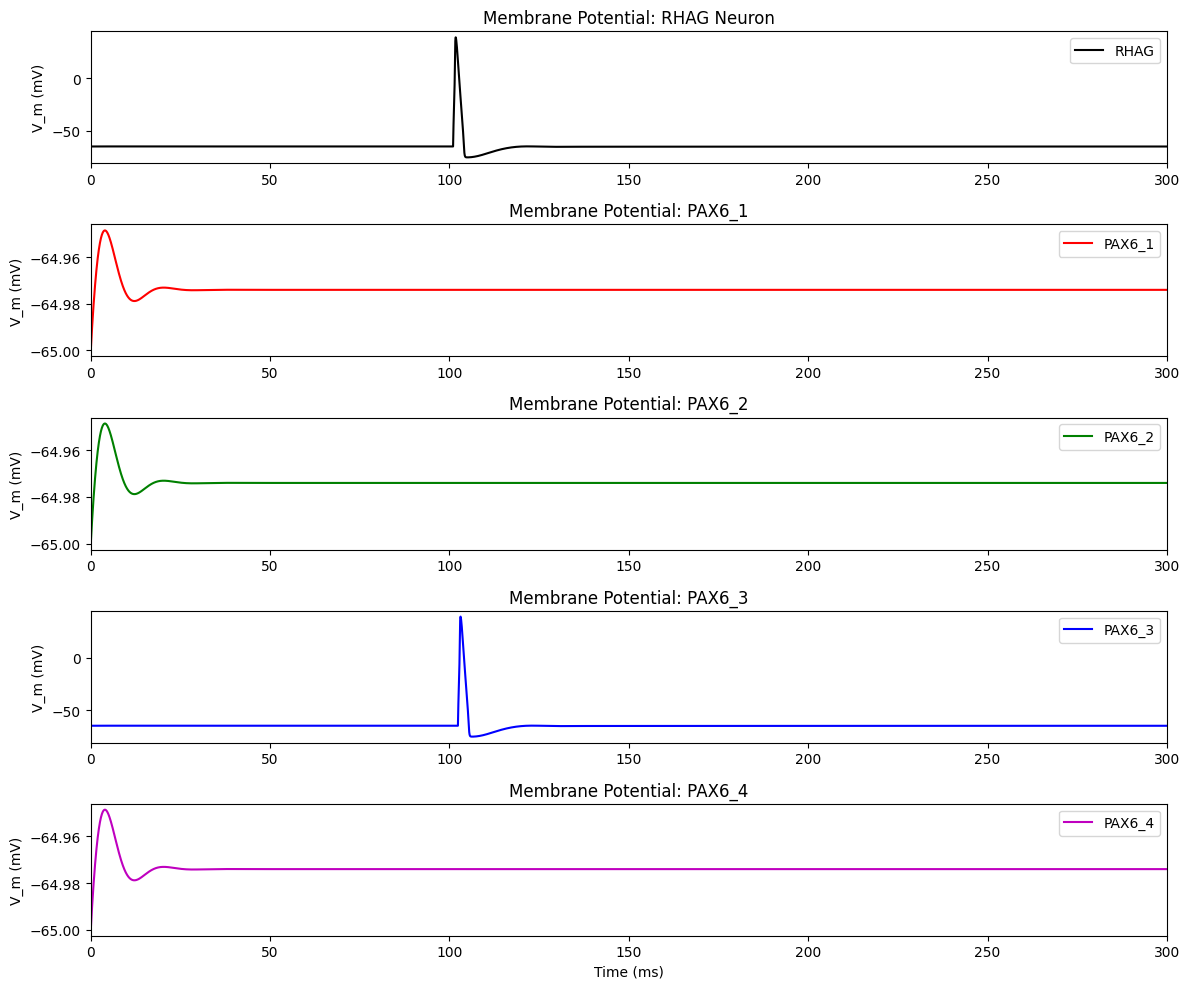

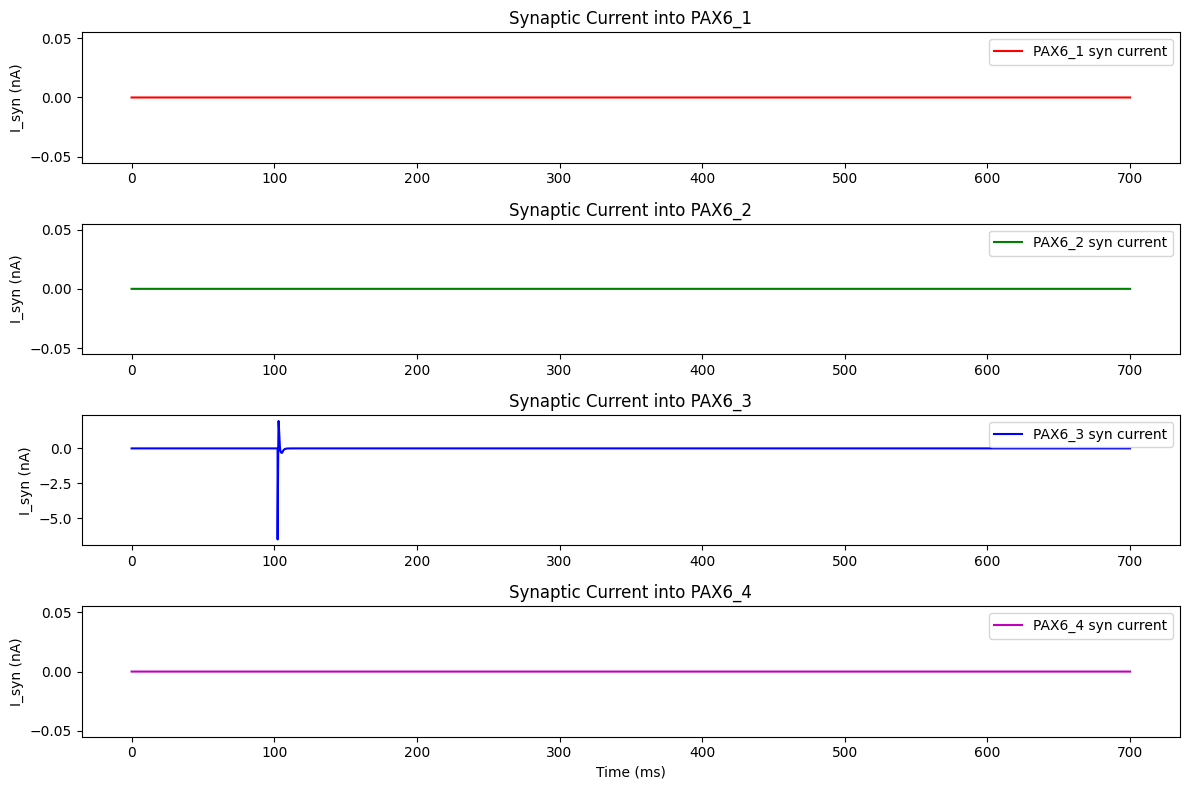

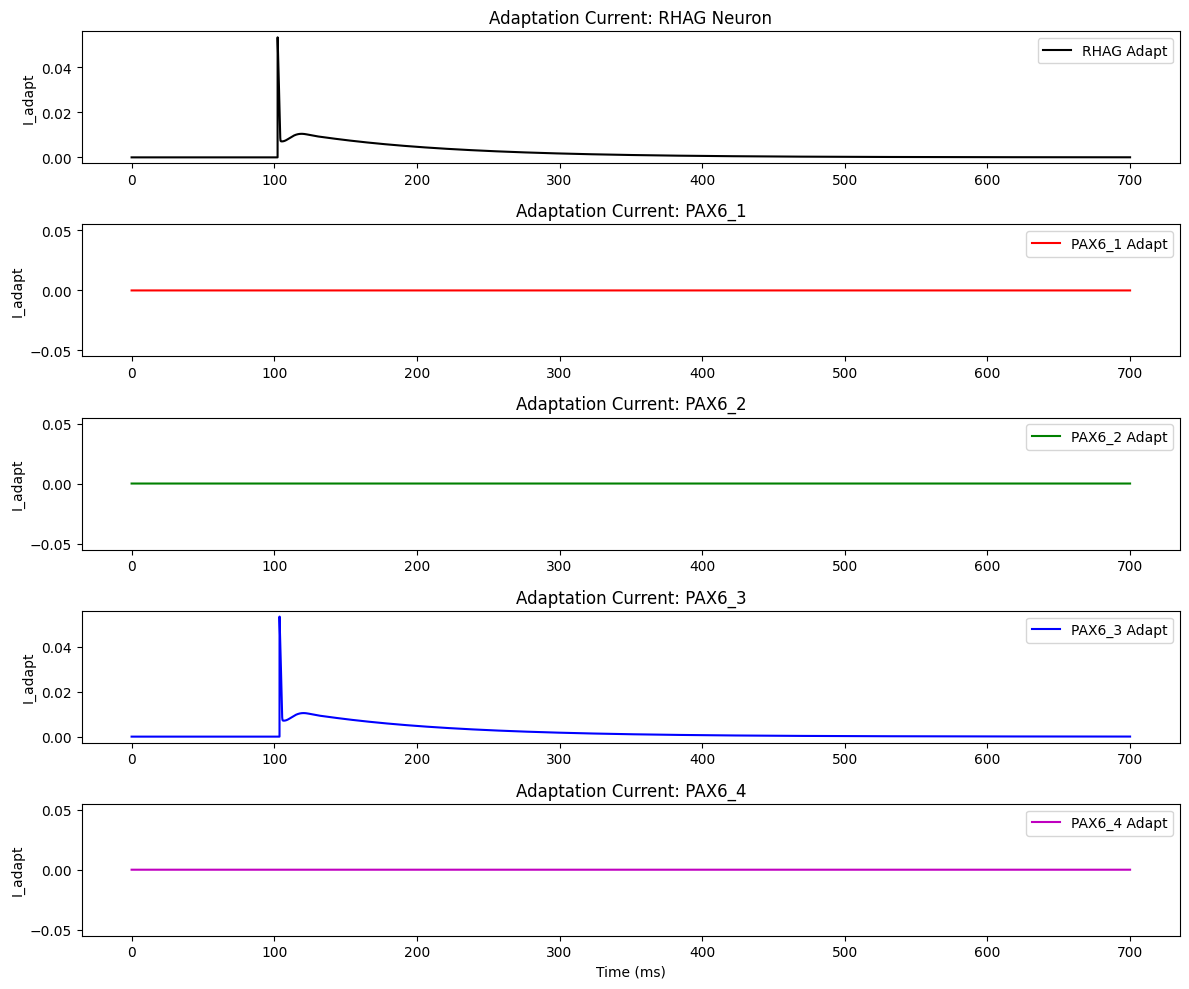

RHAG spikes: 1 at times [101.35]
PAX6_1 spikes: 0 at times []
PAX6_2 spikes: 0 at times []
PAX6_3 spikes: 1 at times [102.7]
PAX6_4 spikes: 0 at times []


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui

h.load_file("stdrun.hoc")

class HHNeuron:
    def __init__(self, name, adapt_gmax=0.0005, adapt_tau=100, soma_L=30, soma_diam=30):
        self.soma = h.Section(name=name)
        self.soma.L = soma_L
        self.soma.diam = soma_diam
        self.soma.Ra = 100
        self.soma.cm = 1
        self.soma.insert('hh')
        for seg in self.soma:
            seg.hh.gnabar = 0.12
            seg.hh.gkbar = 0.036
            seg.hh.gl = 0.0003
            seg.hh.el = -54.3

        self.adapt = h.Adapt(self.soma(0.5))
        self.adapt.gmax = adapt_gmax
        self.adapt.tau = adapt_tau

        self.v = h.Vector().record(self.soma(0.5)._ref_v)
        self.ina = h.Vector().record(self.soma(0.5)._ref_ina)
        self.ik = h.Vector().record(self.soma(0.5)._ref_ik)
        self.iadapt = h.Vector().record(self.adapt._ref_iadapt)
        self.m = h.Vector().record(self.soma(0.5).hh._ref_m)
        self.h_gate = h.Vector().record(self.soma(0.5).hh._ref_h)
        self.n = h.Vector().record(self.soma(0.5).hh._ref_n)
        self.spikes = h.Vector()
        self.nc = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.nc.threshold = -20
        self.nc.record(self.spikes)
        self.nc_adapt = h.NetCon(self.soma(0.5)._ref_v, self.adapt, sec=self.soma)
        self.nc_adapt.threshold = -20
        self.nc_adapt.weight[0] = 1

class DetonatorInput:
    def __init__(self, target_sec, tau=1, e=0, start=100, weight=0.1):
        self.syn = h.ExpSyn(target_sec(0.5))
        self.syn.e = e
        self.syn.tau = tau

        self.stim = h.NetStim()
        self.stim.start = start
        self.stim.number = 1
        self.stim.interval = 1

        self.nc = h.NetCon(self.stim, self.syn)
        self.nc.weight[0] = weight
        self.isyn = h.Vector().record(self.syn._ref_i)

class RHAGNeuron(HHNeuron):
    def __init__(self):
        super().__init__(name='rhag', adapt_gmax=0.0005, adapt_tau=100)
        self.input = DetonatorInput(self.soma, tau=1, start=100, weight = 0.1)
        self.isyn = self.input.isyn

class PAX6Neuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'pax6_{idx+1}', adapt_gmax=0.0005, adapt_tau=100)
        self.syn = h.ExpSyn(self.soma(0.5))
        self.syn.e = 0
        self.syn.tau = 1
        self.isyn = h.Vector().record(self.syn._ref_i)

#NETWORK CONSTRUCTION

rhag = RHAGNeuron()
pax6_cells = [PAX6Neuron(idx) for idx in range(4)]

# ---------------------------
# Stochastic Detonator Efficacies (Place Here)
rng = np.random.default_rng()  # Set seed for reproducibility. Remove/modify for different outcomes each run.
p_proj = 20 / 43
efficacies = rng.choice([0.1, 0.0], size=4, p=[p_proj, 1 - p_proj])
# ---------------------------


# NetCon: RHAG output triggers all PAX6 neurons, stochastic detonator logic
nc_from_rhag = []
for idx, pax in enumerate(pax6_cells):
    nc = h.NetCon(rhag.soma(0.5)._ref_v, pax.syn, sec=rhag.soma)
    nc.threshold = -20
    nc.delay = 1
    nc.weight[0] = efficacies[idx]  # Stochastic detonator assignment
    nc_from_rhag.append(nc)

# Initialize t vector just once
t = h.Vector().record(h._ref_t)


#SIMULATION

h.finitialize(-65)
h.continuerun(700)

#DATA EXTRACTION

# Convert t only once
t_np = np.array(t)

def vnp(v): return np.array(list(v))
def arrlst(lst): return [np.array(list(x)) for x in lst]

v_rhag = vnp(rhag.v)
ina_rhag = vnp(rhag.ina)
ik_rhag = vnp(rhag.ik)
iadapt_rhag = vnp(rhag.iadapt)
isyn_rhag = vnp(rhag.isyn)
spikes_rhag = vnp(rhag.spikes)

v_pax6_np = arrlst([p.v for p in pax6_cells])
spikes_pax6_np = arrlst([p.spikes for p in pax6_cells])
isyn_pax6_np = arrlst([p.isyn for p in pax6_cells])
iadapt_pax6_np = arrlst([p.iadapt for p in pax6_cells])


#PLOTTING

num_pax6 = 4
# Membrane Potentials
plt.figure(figsize=(12, 2 * (num_pax6 + 1)))
plt.subplot(num_pax6 + 1, 1, 1)
plt.plot(t_np, v_rhag, 'k', label='RHAG')
plt.ylabel('V_m (mV)')
plt.title('Membrane Potential: RHAG Neuron')
plt.legend()
plt.xlim(0, 300)
for idx, vp in enumerate(v_pax6_np):
    plt.subplot(num_pax6 + 1, 1, idx + 2)
    plt.plot(t_np, vp, color=['r', 'g', 'b', 'm'][idx], label=f'PAX6_{idx + 1}')
    plt.ylabel('V_m (mV)')
    plt.legend()
    plt.title(f'Membrane Potential: PAX6_{idx + 1}')
    plt.xlim(0, 300)
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

# Synaptic currents for each PAX6 neuron
plt.figure(figsize=(12, 2 * num_pax6))
for idx, isyn in enumerate(isyn_pax6_np):
    plt.subplot(num_pax6, 1, idx + 1)
    plt.plot(t_np, isyn, color=['r', 'g', 'b', 'm'][idx], label=f'PAX6_{idx + 1} syn current')
    plt.ylabel('I_syn (nA)')
    plt.legend()
    plt.title(f'Synaptic Current into PAX6_{idx + 1}')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

# Adaptation Currents: RHAG + each PAX6 neuron, one per axis
plt.figure(figsize=(12, 2 * (num_pax6 + 1)))
plt.subplot(num_pax6 + 1, 1, 1)
plt.plot(t_np, iadapt_rhag, 'k', label='RHAG Adapt')
plt.ylabel('I_adapt')
plt.title('Adaptation Current: RHAG Neuron')
plt.legend()
for idx, ia in enumerate(iadapt_pax6_np):
    plt.subplot(num_pax6 + 1, 1, idx + 2)
    plt.plot(t_np, ia, color=['r', 'g', 'b', 'm'][idx], label=f'PAX6_{idx+1} Adapt')
    plt.ylabel('I_adapt')
    plt.legend()
    plt.title(f'Adaptation Current: PAX6_{idx+1}')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

print(f"RHAG spikes: {len(spikes_rhag)} at times {spikes_rhag}")
for idx, s in enumerate(spikes_pax6_np):
    print(f"PAX6_{idx+1} spikes: {len(s)} at times {s}")


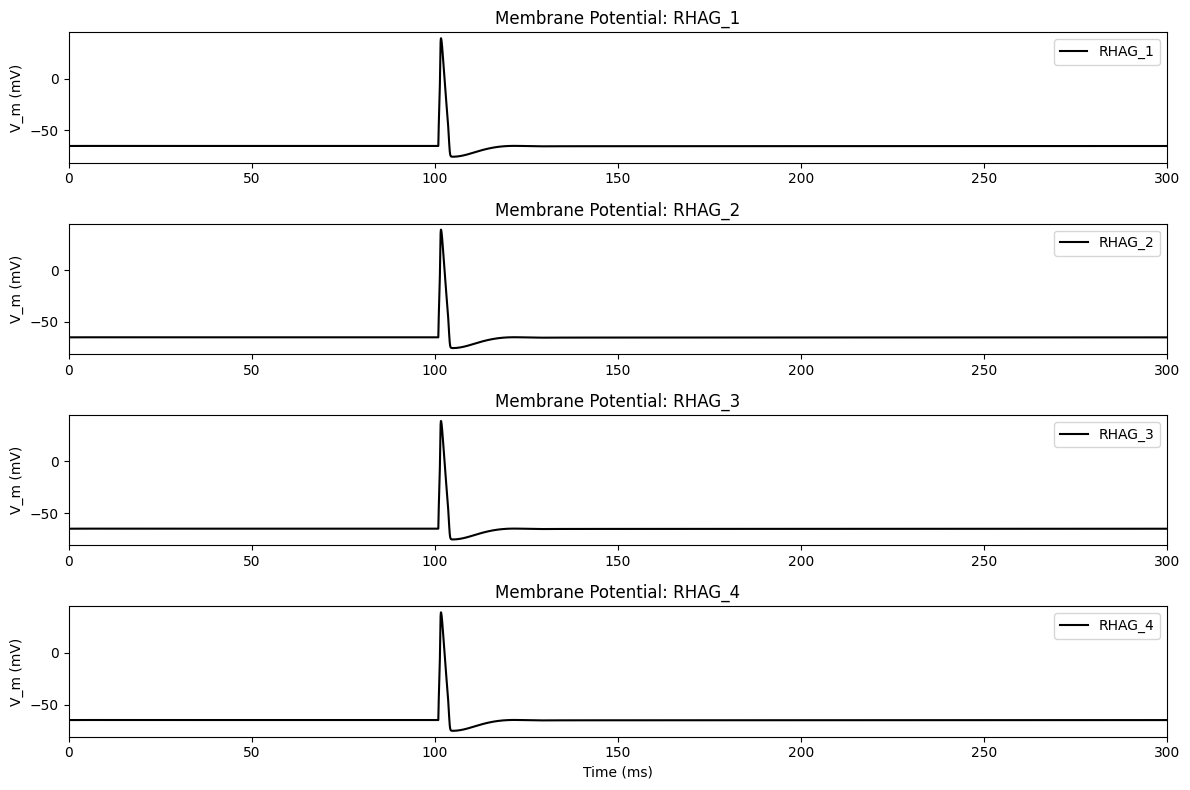

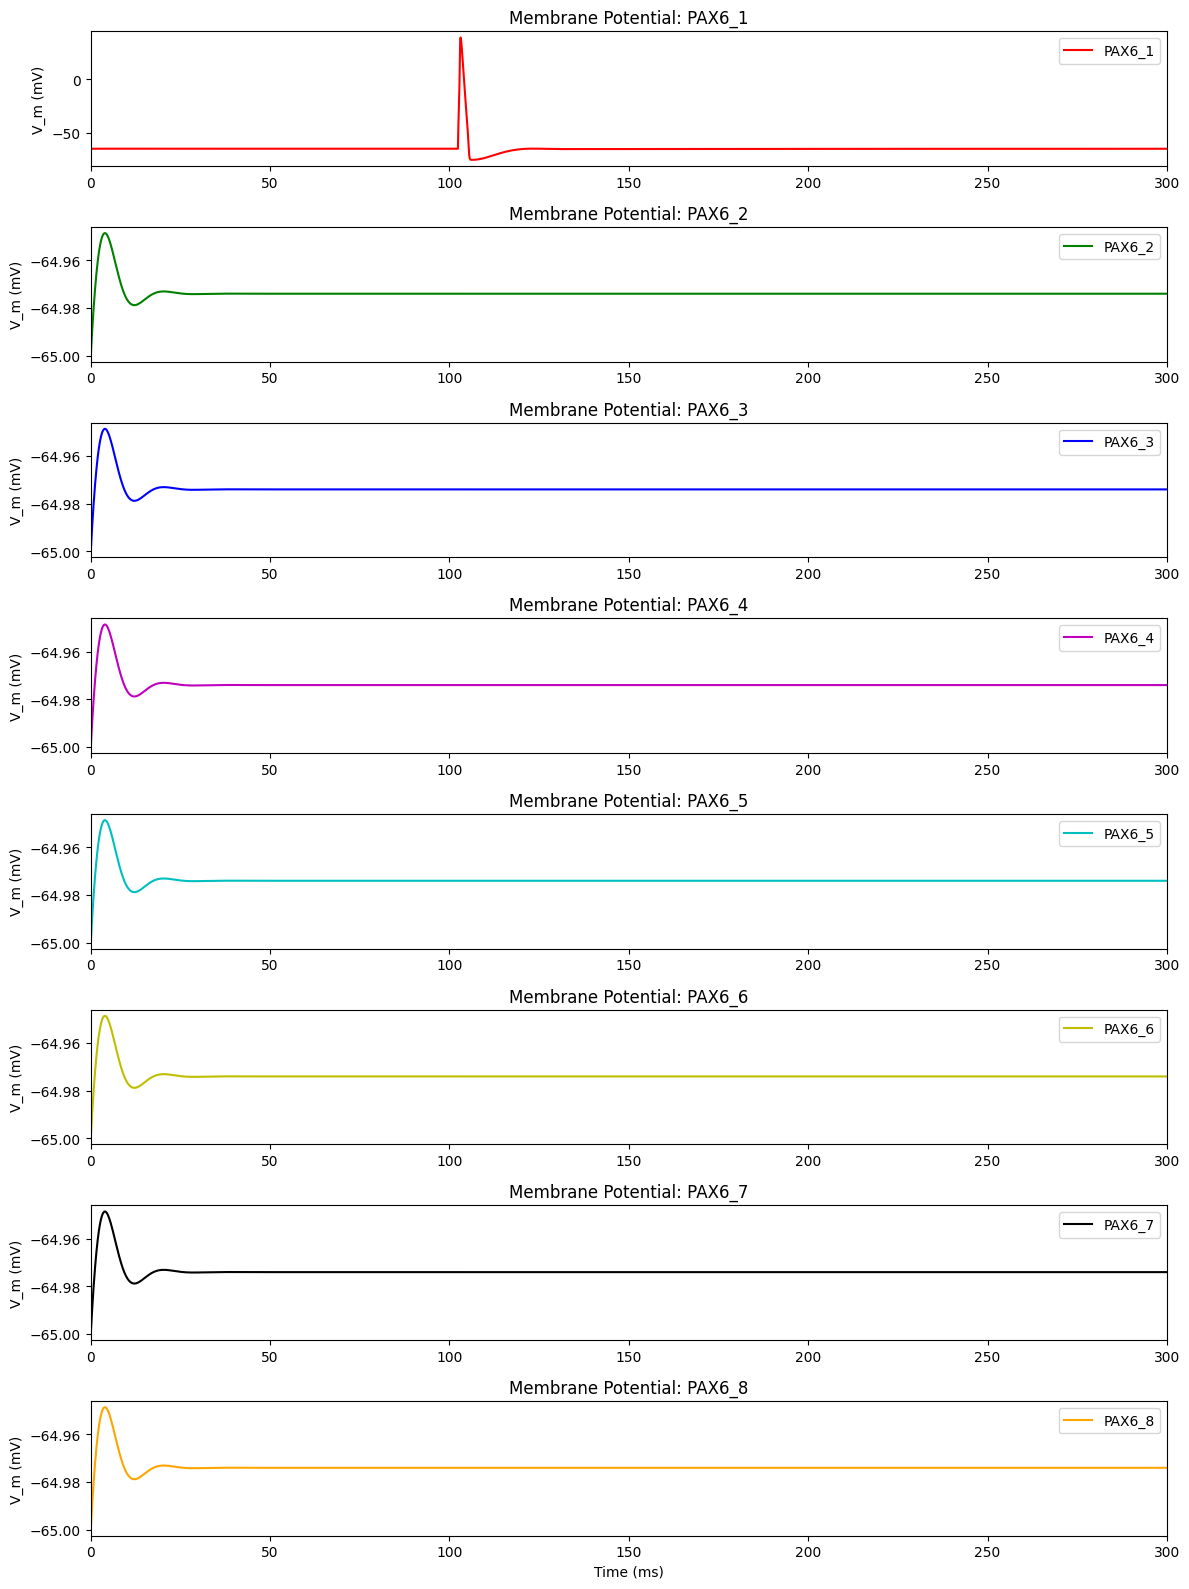

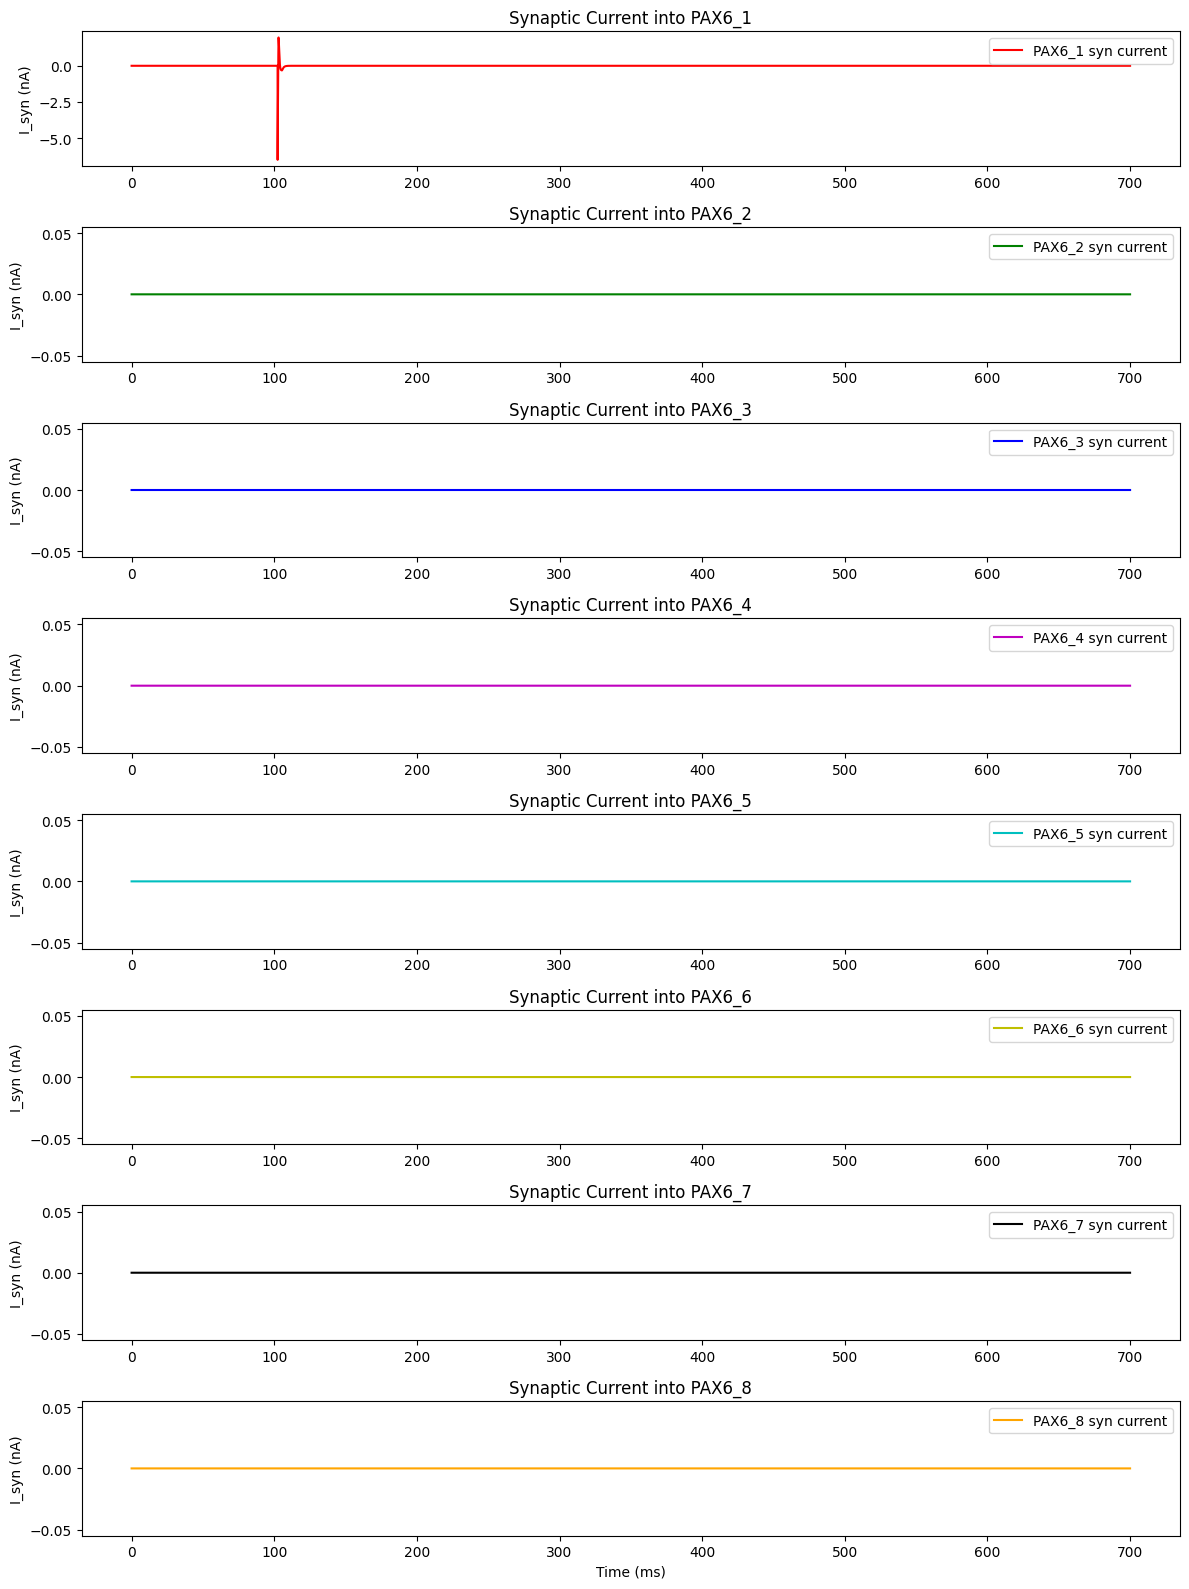

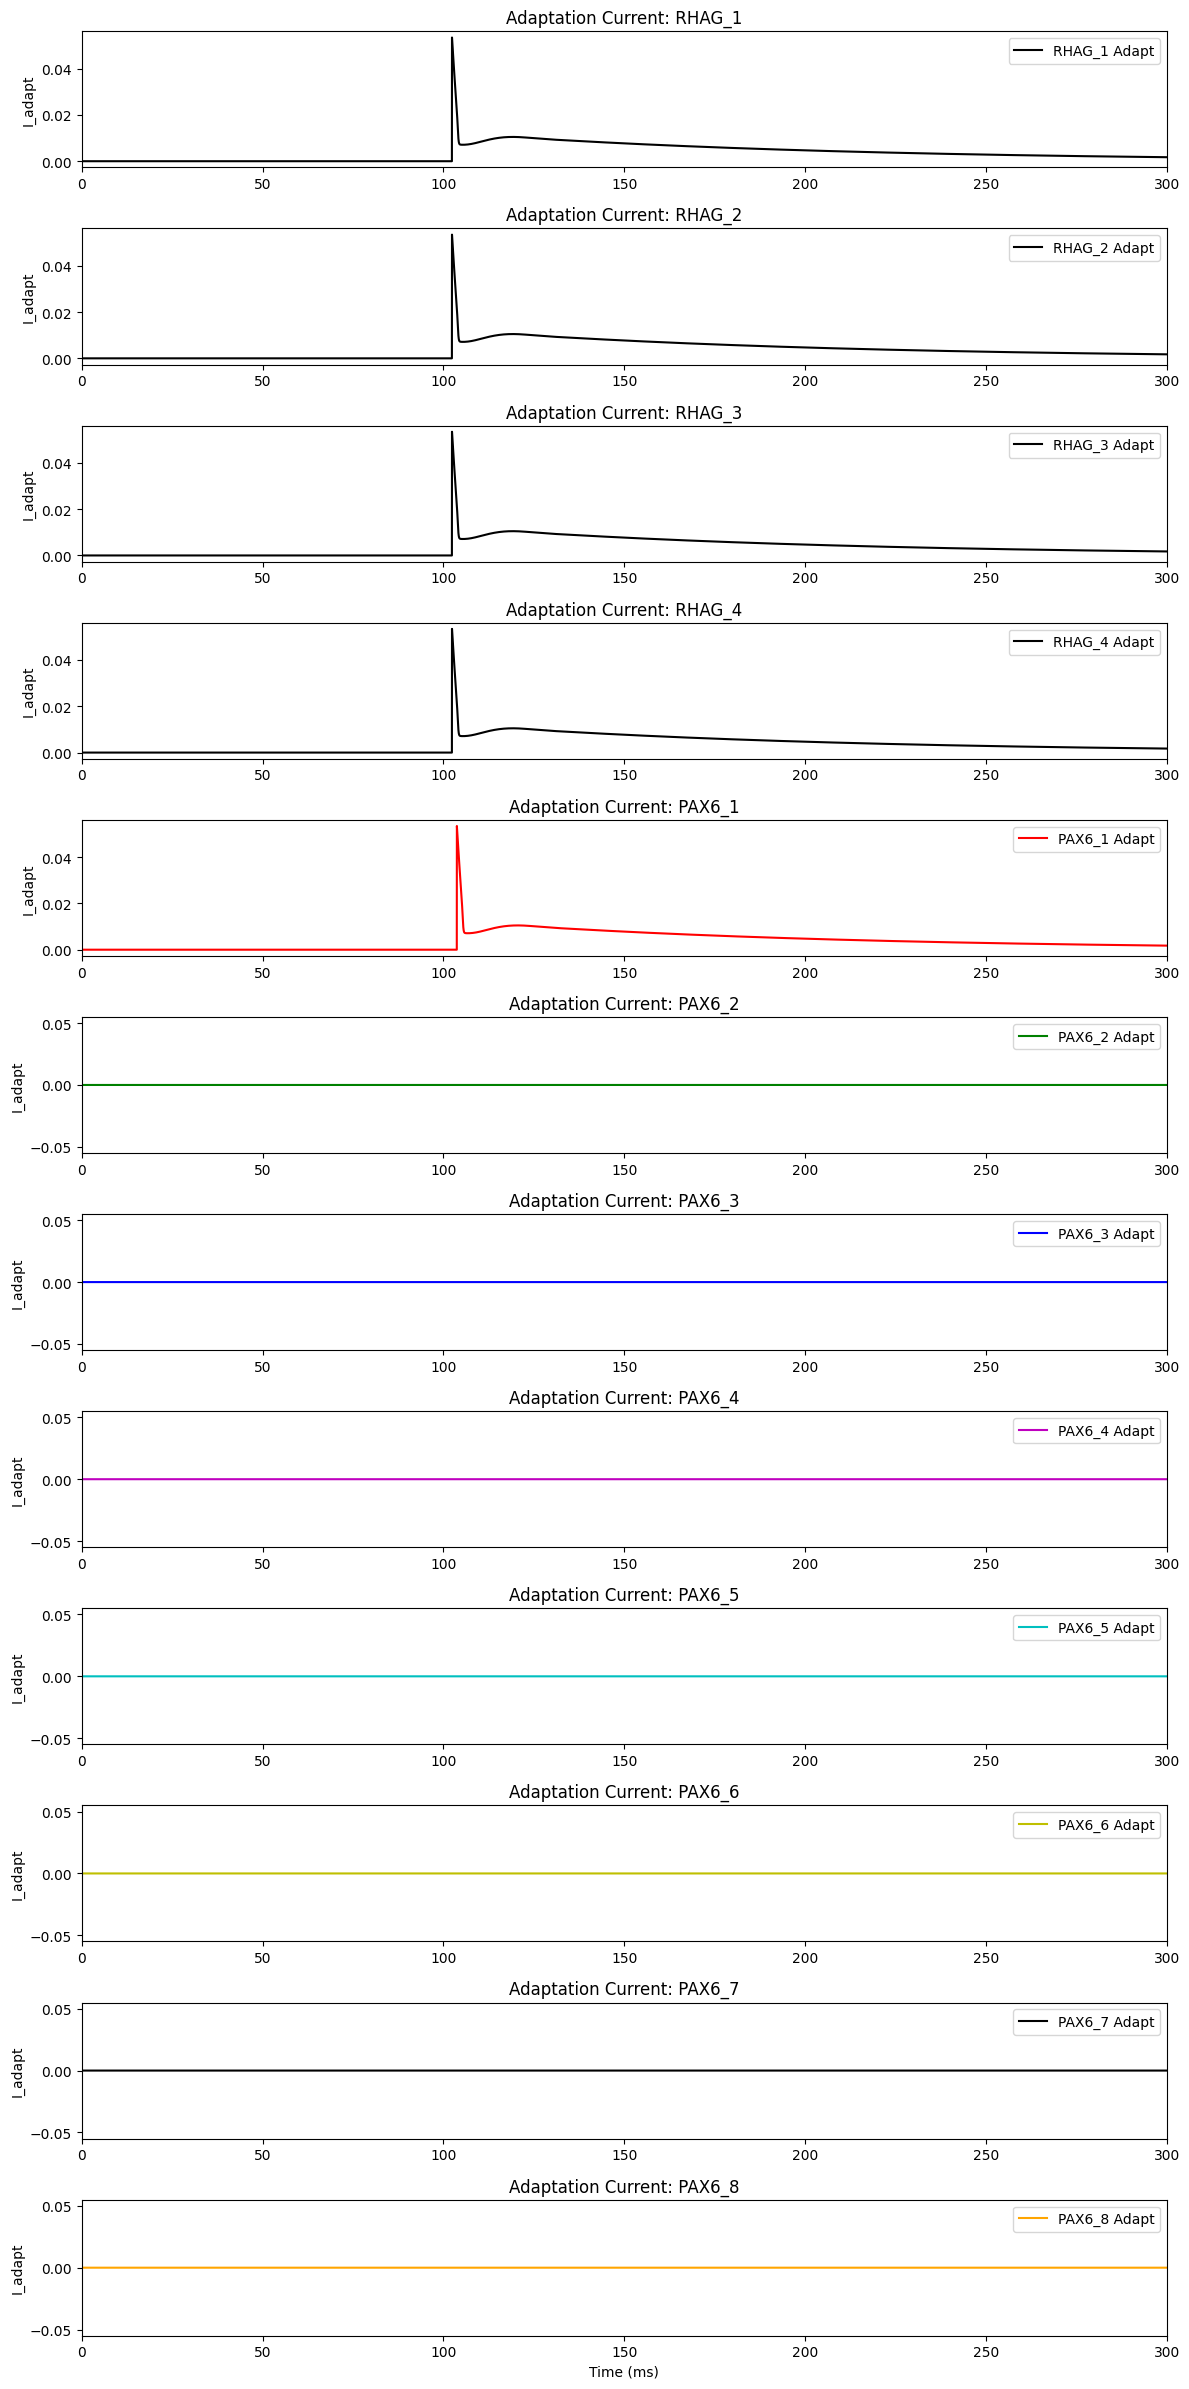

RHAG spikes: 4 at times [array([101.35]), array([101.35]), array([101.35]), array([101.35])]
PAX6_1 spikes: 1 at times [102.7]
PAX6_2 spikes: 0 at times []
PAX6_3 spikes: 0 at times []
PAX6_4 spikes: 0 at times []
PAX6_5 spikes: 0 at times []
PAX6_6 spikes: 0 at times []
PAX6_7 spikes: 0 at times []
PAX6_8 spikes: 0 at times []
RHAG_1 projects to PAX6 neurons: [np.int64(5), np.int64(2), np.int64(4)]
RHAG_2 projects to PAX6 neurons: [np.int64(4), np.int64(5)]
RHAG_3 projects to PAX6 neurons: [np.int64(2), np.int64(1), np.int64(7)]
RHAG_4 projects to PAX6 neurons: [np.int64(3), np.int64(0)]
PAX6_1 receives from RHAGs: [4]
PAX6_2 receives from RHAGs: [3]
PAX6_3 receives from RHAGs: [1, 3]
PAX6_4 receives from RHAGs: [4]
PAX6_5 receives from RHAGs: [1, 2]
PAX6_6 receives from RHAGs: [1, 2]
PAX6_7 receives from RHAGs: []
PAX6_8 receives from RHAGs: [3]


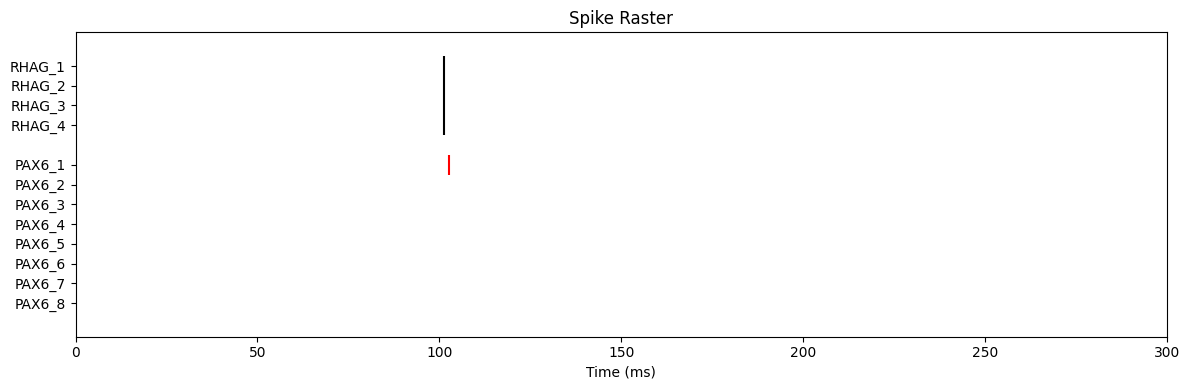

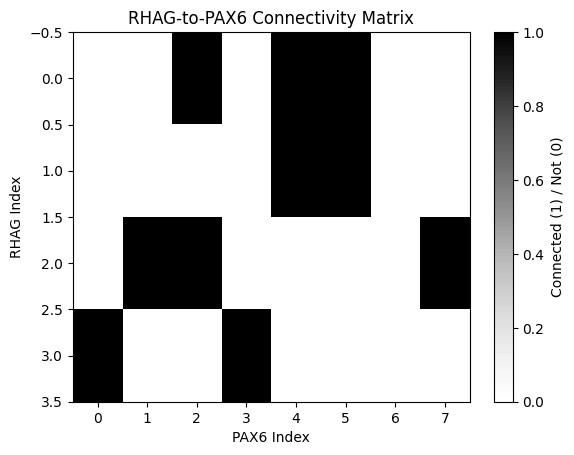

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui

h.load_file("stdrun.hoc")

class HHNeuron:
    def __init__(self, name, adapt_gmax=0.0005, adapt_tau=100, soma_L=30, soma_diam=30):
        self.soma = h.Section(name=name)
        self.soma.L = soma_L
        self.soma.diam = soma_diam
        self.soma.Ra = 100
        self.soma.cm = 1
        self.soma.insert('hh')
        for seg in self.soma:
            seg.hh.gnabar = 0.12
            seg.hh.gkbar = 0.036
            seg.hh.gl = 0.0003
            seg.hh.el = -54.3

        self.adapt = h.Adapt(self.soma(0.5))
        self.adapt.gmax = adapt_gmax
        self.adapt.tau = adapt_tau

        self.v = h.Vector().record(self.soma(0.5)._ref_v)
        self.ina = h.Vector().record(self.soma(0.5)._ref_ina)
        self.ik = h.Vector().record(self.soma(0.5)._ref_ik)
        self.iadapt = h.Vector().record(self.adapt._ref_iadapt)
        self.m = h.Vector().record(self.soma(0.5).hh._ref_m)
        self.h_gate = h.Vector().record(self.soma(0.5).hh._ref_h)
        self.n = h.Vector().record(self.soma(0.5).hh._ref_n)
        self.spikes = h.Vector()
        self.nc = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.nc.threshold = -20
        self.nc.record(self.spikes)
        self.nc_adapt = h.NetCon(self.soma(0.5)._ref_v, self.adapt, sec=self.soma)
        self.nc_adapt.threshold = -20
        self.nc_adapt.weight[0] = 1

class DetonatorInput:
    def __init__(self, target_sec, tau=1, e=0, start=100, weight=0.1):
        self.syn = h.ExpSyn(target_sec(0.5))
        self.syn.e = e
        self.syn.tau = tau

        self.stim = h.NetStim()
        self.stim.start = start
        self.stim.number = 1
        self.stim.interval = 1

        self.nc = h.NetCon(self.stim, self.syn)
        self.nc.weight[0] = weight
        self.isyn = h.Vector().record(self.syn._ref_i)

class RHAGNeuron(HHNeuron):
    def __init__(self):
        super().__init__(name='rhag', adapt_gmax=0.0005, adapt_tau=100)
        self.input = DetonatorInput(self.soma, tau=1, start=100, weight = 0.1)
        self.isyn = self.input.isyn

class PAX6Neuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'pax6_{idx+1}', adapt_gmax=0.0005, adapt_tau=100)
        self.syn = h.ExpSyn(self.soma(0.5))
        self.syn.e = 0
        self.syn.tau = 1
        self.isyn = h.Vector().record(self.syn._ref_i)

#NETWORK CONSTRUCTION

num_rhag = 4
num_pax6 = 8  # Choose >=4 for more realistic overlaps; can be 4 to match your example

# Create neuron populations
rhag_cells = [RHAGNeuron() for _ in range(num_rhag)]
pax6_cells = [PAX6Neuron(idx) for idx in range(num_pax6)]

# Each RHAG neuron randomly connects to its 4 "nearest" PAX6 neurons (overlaps allowed)
rng = np.random.default_rng()
p_proj = 20 / 43  # 0.465 probability of projection

nearest_pax6 = [rng.choice(num_pax6, size=4, replace=False) for _ in range(num_rhag)]
connections = []
for rhag_idx, rhag in enumerate(rhag_cells):
    for pax6_idx in nearest_pax6[rhag_idx]:
        weight = 0.1 if rng.uniform() < p_proj else 0.0
        nc = h.NetCon(rhag.soma(0.5)._ref_v, pax6_cells[pax6_idx].syn, sec=rhag.soma)
        nc.threshold = -20
        nc.delay = 1
        nc.weight[0] = weight
        connections.append((rhag_idx, pax6_idx, weight))


# Initialize t vector just once
t = h.Vector().record(h._ref_t)


#SIMULATION

h.finitialize(-65)
h.continuerun(700)

#DATA EXTRACTION

# Convert t only once
t_np = np.array(t)

def vnp(v): return np.array(list(v))
def arrlst(lst): return [np.array(list(x)) for x in lst]

v_rhag = [vnp(r.v) for r in rhag_cells]
ina_rhag = [vnp(r.ina) for r in rhag_cells]
ik_rhag = [vnp(r.ik) for r in rhag_cells]
iadapt_rhag = [vnp(r.iadapt) for r in rhag_cells]
isyn_rhag = [vnp(r.isyn) for r in rhag_cells]
spikes_rhag = [vnp(r.spikes) for r in rhag_cells]

v_pax6 = [vnp(p.v) for p in pax6_cells]
spikes_pax6_np = arrlst([p.spikes for p in pax6_cells])
isyn_pax6_np = arrlst([p.isyn for p in pax6_cells])
iadapt_pax6_np = arrlst([p.iadapt for p in pax6_cells])


#PLOTTING

plt.figure(figsize=(12, 2 * num_rhag))
for i, v in enumerate(v_rhag):
    plt.subplot(num_rhag, 1, i + 1)
    plt.plot(t_np, v, label=f'RHAG_{i+1}', color='k')
    plt.ylabel('V_m (mV)')
    plt.title(f'Membrane Potential: RHAG_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2 * num_pax6))
for i, v in enumerate(v_pax6):
    plt.subplot(num_pax6, 1, i + 1)
    plt.plot(t_np, v, label=f'PAX6_{i+1}', color=['r','g','b','m','c','y','k','orange'][i % 8])
    plt.ylabel('V_m (mV)')
    plt.title(f'Membrane Potential: PAX6_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()


# Synaptic currents for each PAX6 neuron
plt.figure(figsize=(12, 2 * num_pax6))
import itertools
colors = itertools.cycle(['r', 'g', 'b', 'm', 'c', 'y', 'k', 'orange'])
for idx, isyn in enumerate(isyn_pax6_np):
    plt.subplot(num_pax6, 1, idx + 1)
    plt.plot(t_np, isyn, color=next(colors), label=f'PAX6_{idx + 1} syn current')
    plt.ylabel('I_syn (nA)')
    plt.legend()
    plt.title(f'Synaptic Current into PAX6_{idx + 1}')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2 * (num_rhag + num_pax6)))
for i, ia in enumerate(iadapt_rhag):
    plt.subplot(num_rhag + num_pax6, 1, i + 1)
    plt.plot(t_np, ia, label=f'RHAG_{i+1} Adapt', color='k')
    plt.ylabel('I_adapt')
    plt.title(f'Adaptation Current: RHAG_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
for idx, ia in enumerate(iadapt_pax6_np):
    plt.subplot(num_rhag + num_pax6, 1, num_rhag + idx + 1)
    plt.plot(t_np, ia, label=f'PAX6_{idx+1} Adapt', color=['r','g','b','m','c','y','k','orange'][idx % 8])
    plt.ylabel('I_adapt')
    plt.title(f'Adaptation Current: PAX6_{idx+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()


print(f"RHAG spikes: {len(spikes_rhag)} at times {spikes_rhag}")
for idx, s in enumerate(spikes_pax6_np):
    print(f"PAX6_{idx+1} spikes: {len(s)} at times {s}")

for rhag_idx in range(num_rhag):
    partners = [pax6_idx for (r_idx, pax6_idx, w) in connections if r_idx == rhag_idx and w > 0.0]
    print(f"RHAG_{rhag_idx+1} projects to PAX6 neurons: {partners}")
for pax6_idx in range(num_pax6):
    sources = [r_idx+1 for (r_idx, p_idx, w) in connections if p_idx==pax6_idx and w > 0.0]
    print(f"PAX6_{pax6_idx+1} receives from RHAGs: {sources}")

plt.figure(figsize=(12, 4))
all_spikes = spikes_rhag + spikes_pax6_np
lineoffsets = list(range(num_rhag, 0, -1)) + list(range(-1, -num_pax6-1, -1))
plt.eventplot(all_spikes, lineoffsets=lineoffsets, colors=['k']*num_rhag + ['r','g','b','m','c','y','k','orange'][:num_pax6])
plt.yticks(
    list(range(num_rhag, 0, -1)) + list(range(-1, -num_pax6-1, -1)),
    [f'RHAG_{i+1}' for i in range(num_rhag)] + [f'PAX6_{i+1}' for i in range(num_pax6)]
)
plt.xlim(0, 300)
plt.xlabel('Time (ms)')
plt.title('Spike Raster')
plt.tight_layout()
plt.show()

conn_matrix = np.zeros((num_rhag, num_pax6))
for r, p, w in connections:
    if w > 0: conn_matrix[r, p] = 1
plt.imshow(conn_matrix, aspect='auto', cmap='Greys')
plt.xlabel('PAX6 Index')
plt.ylabel('RHAG Index')
plt.title('RHAG-to-PAX6 Connectivity Matrix')
plt.colorbar(label="Connected (1) / Not (0)")
plt.show()



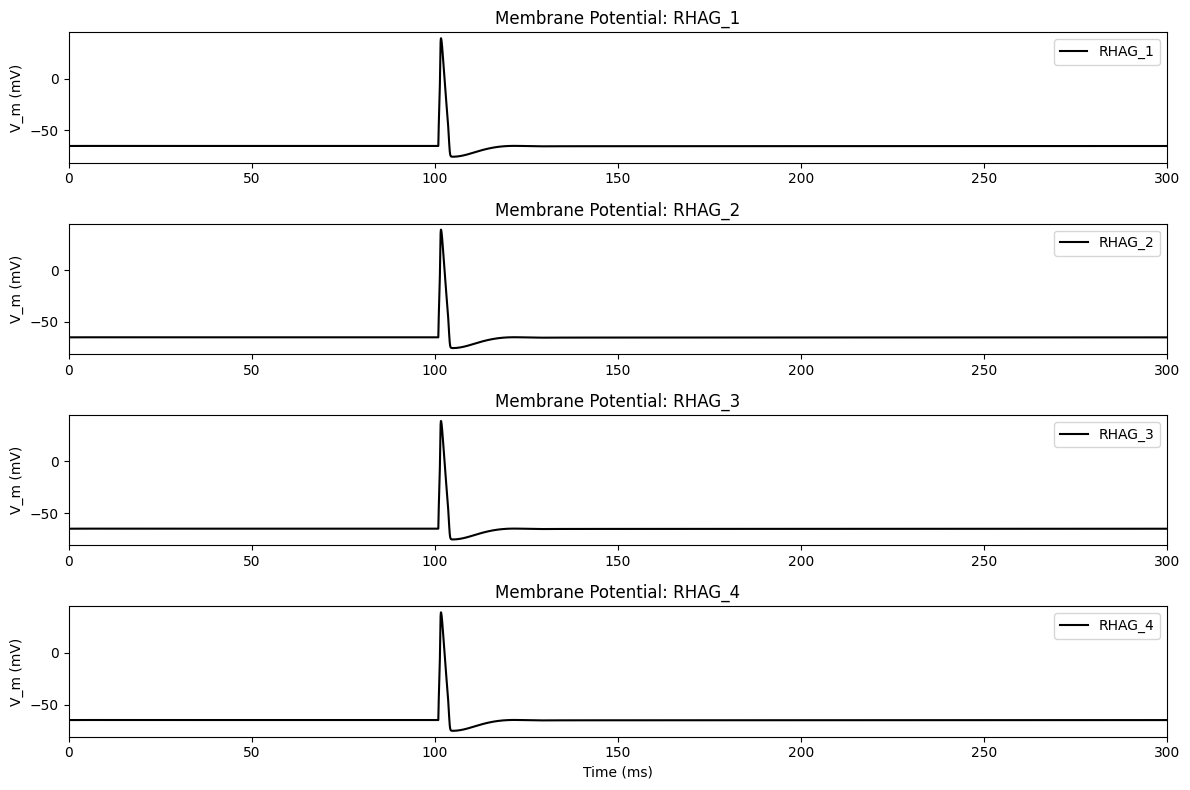

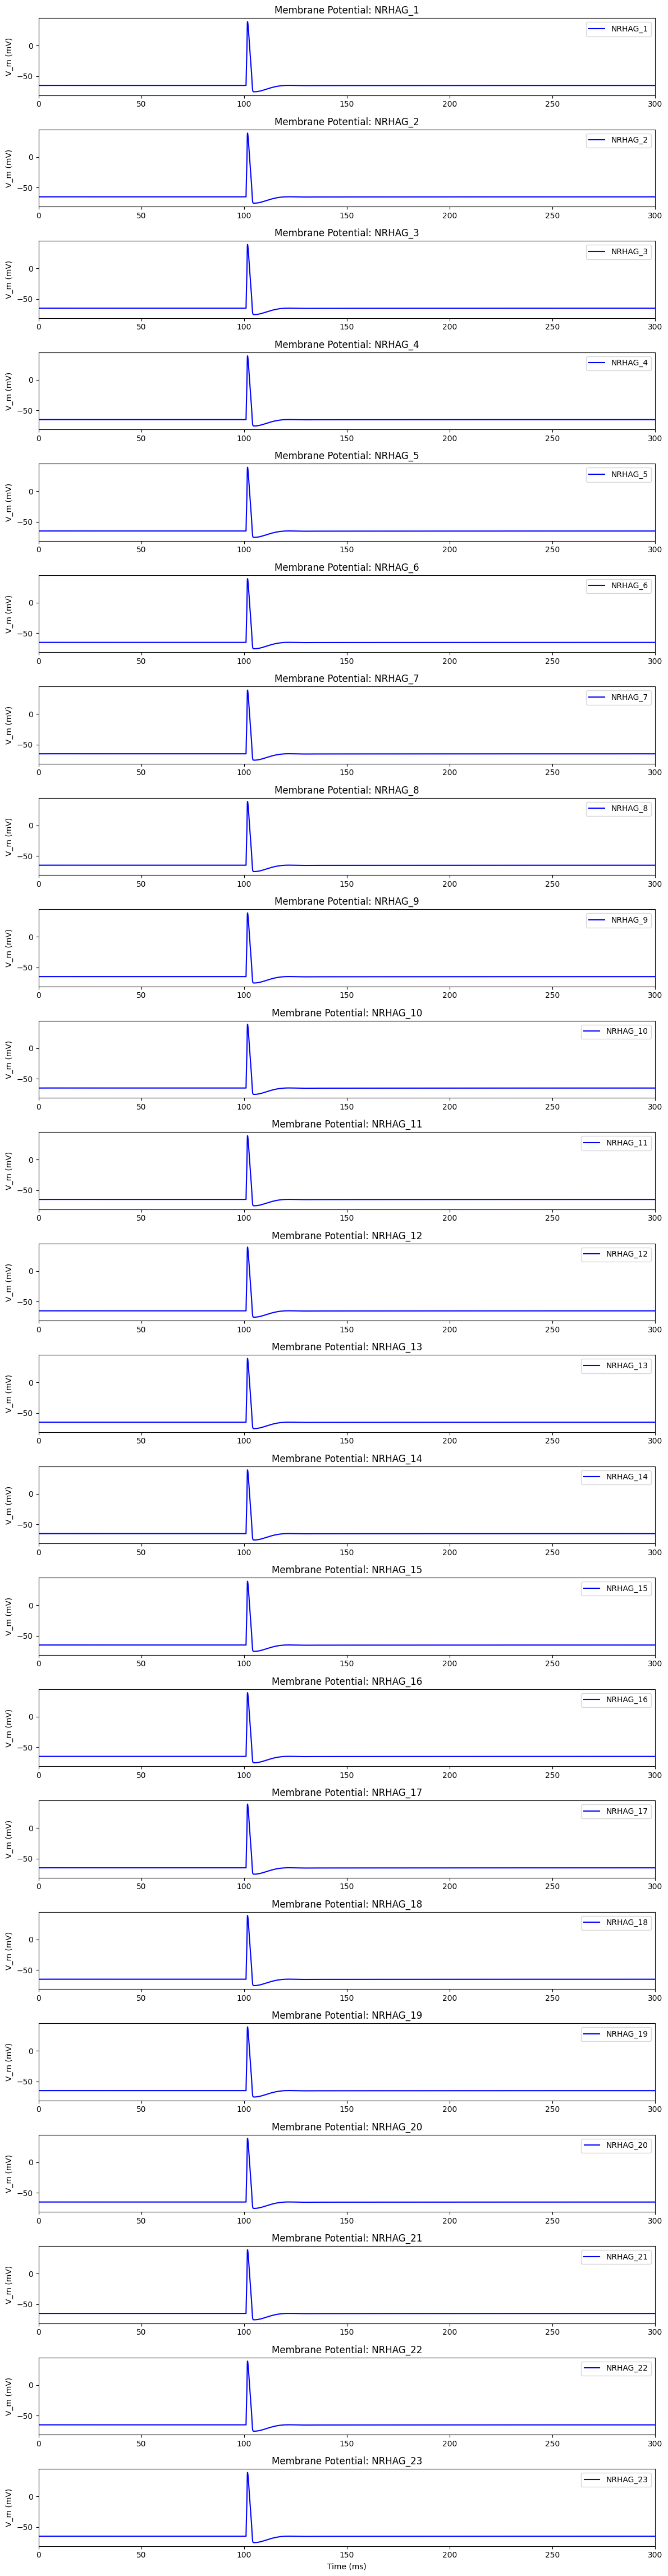

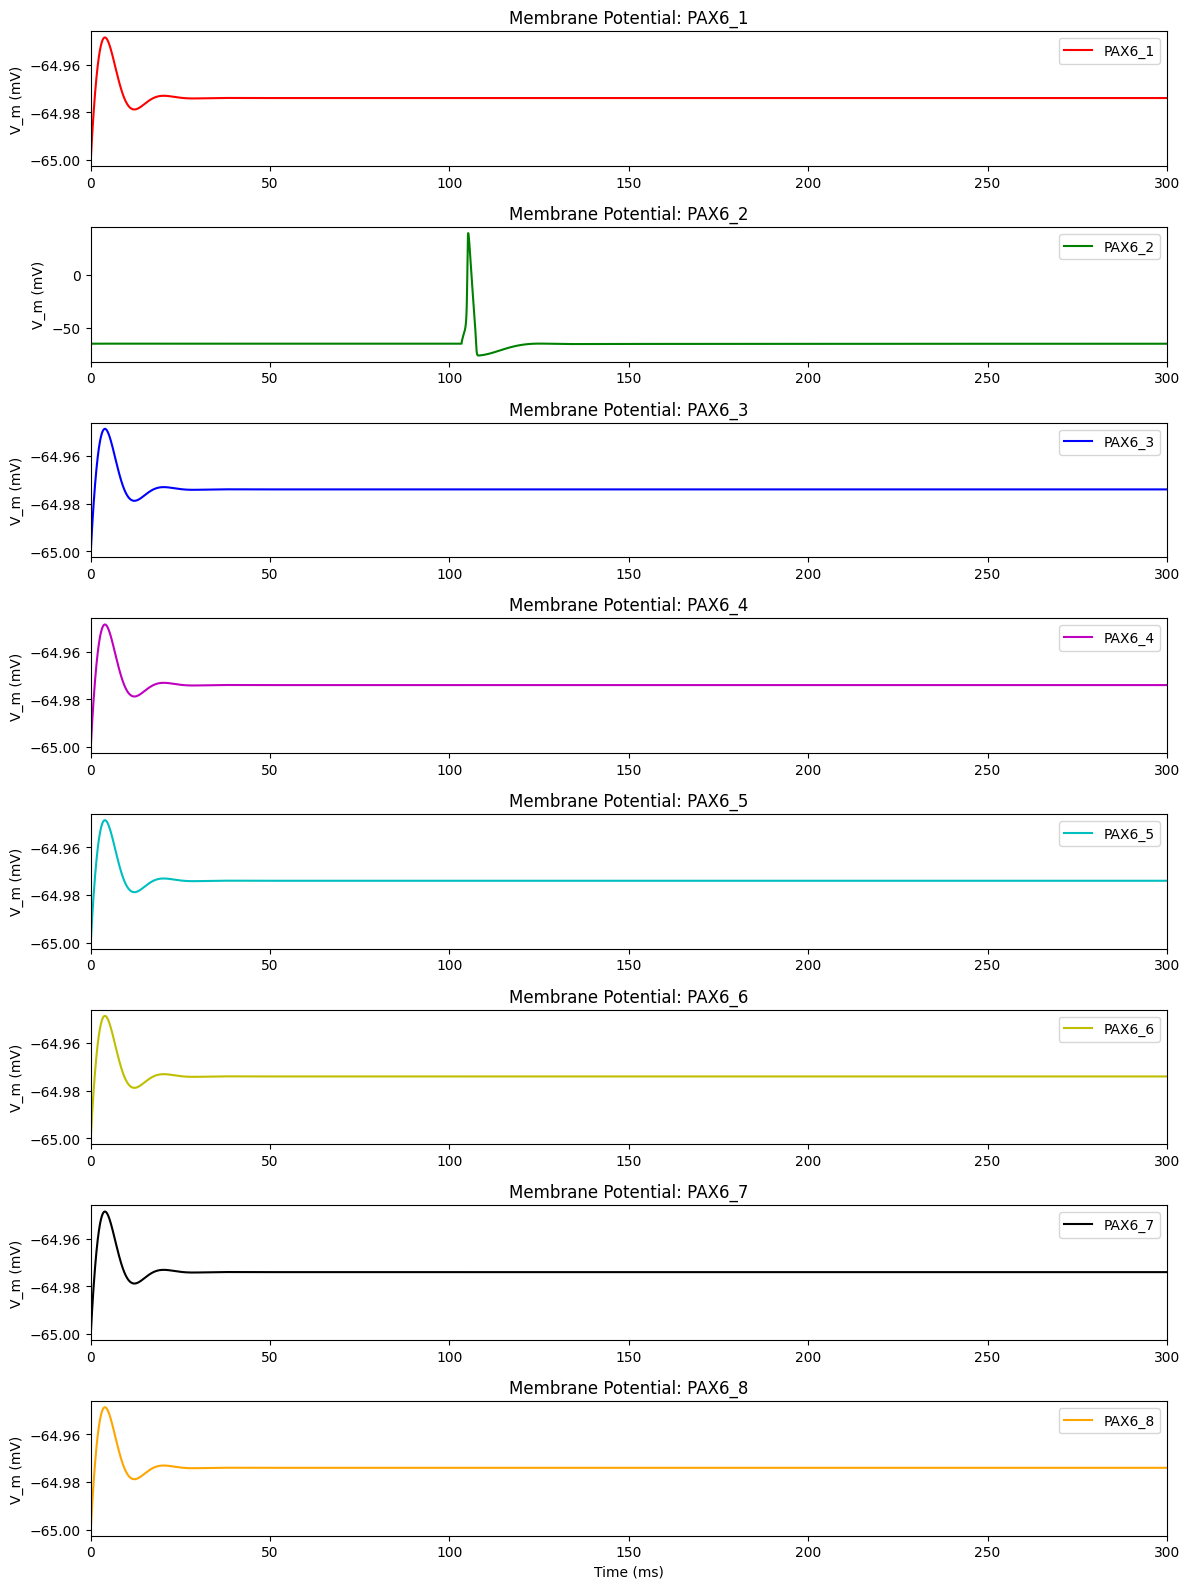

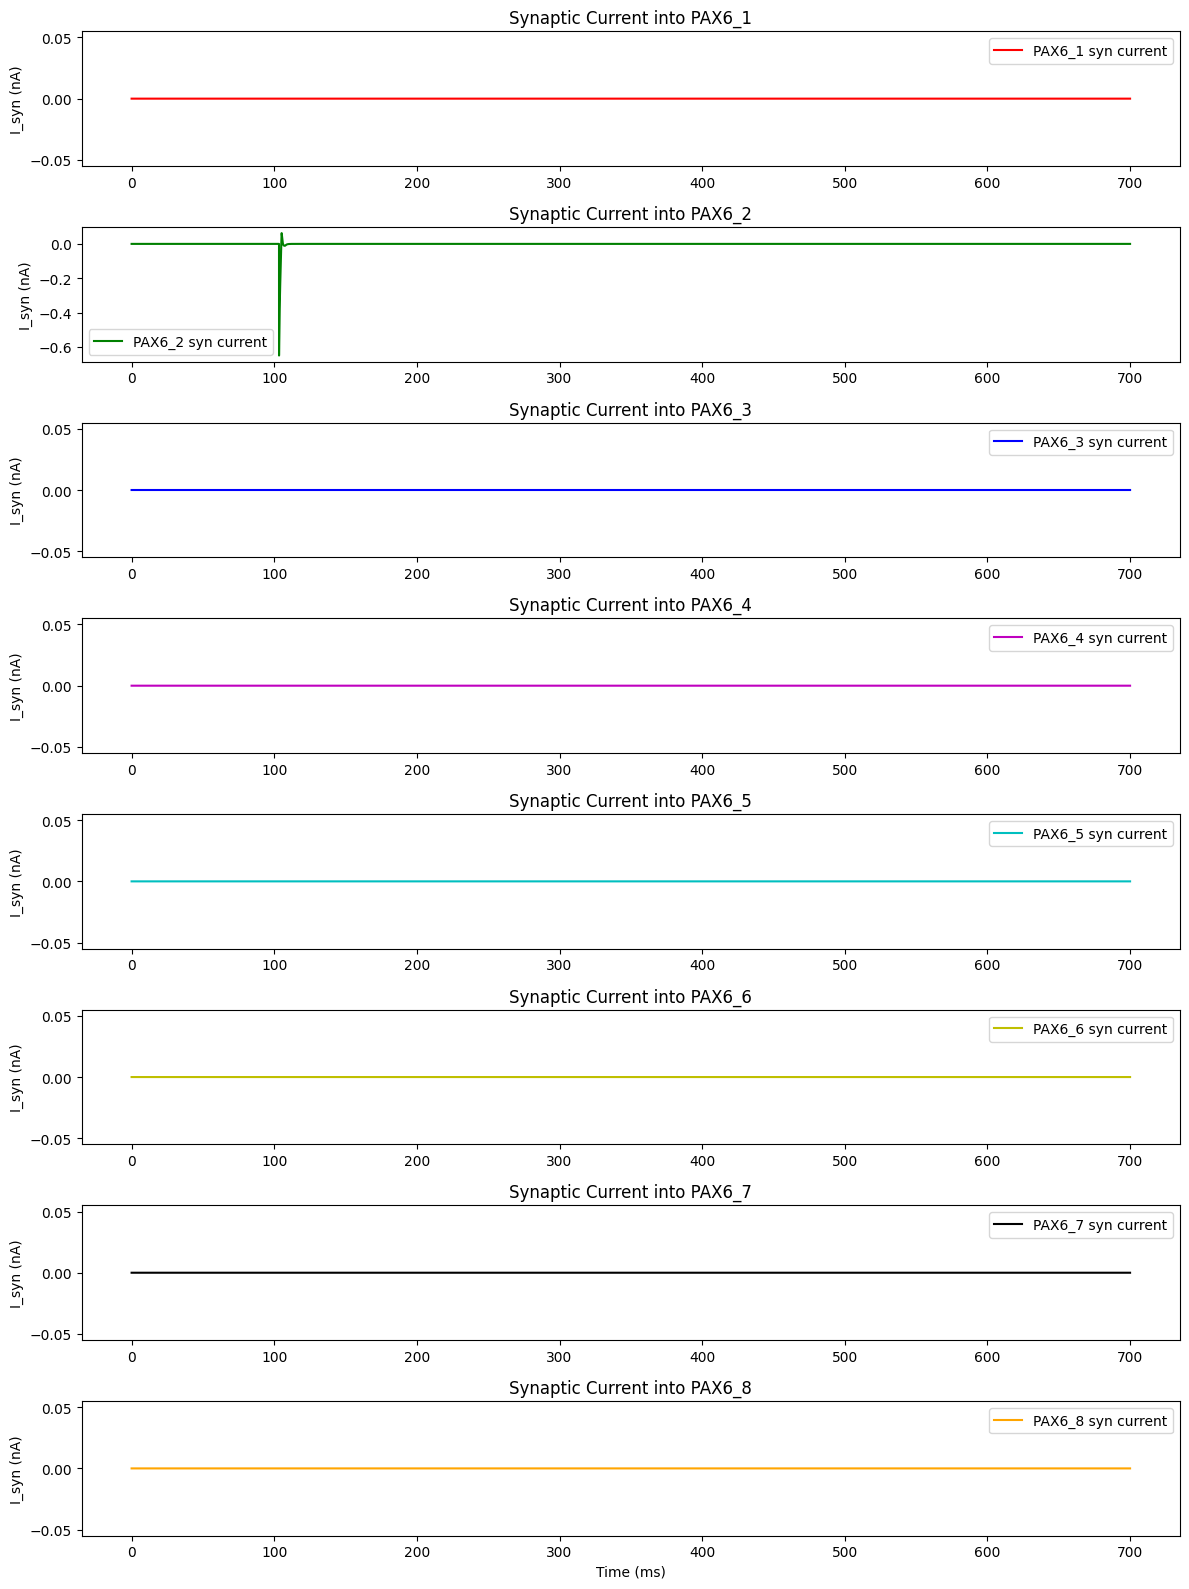

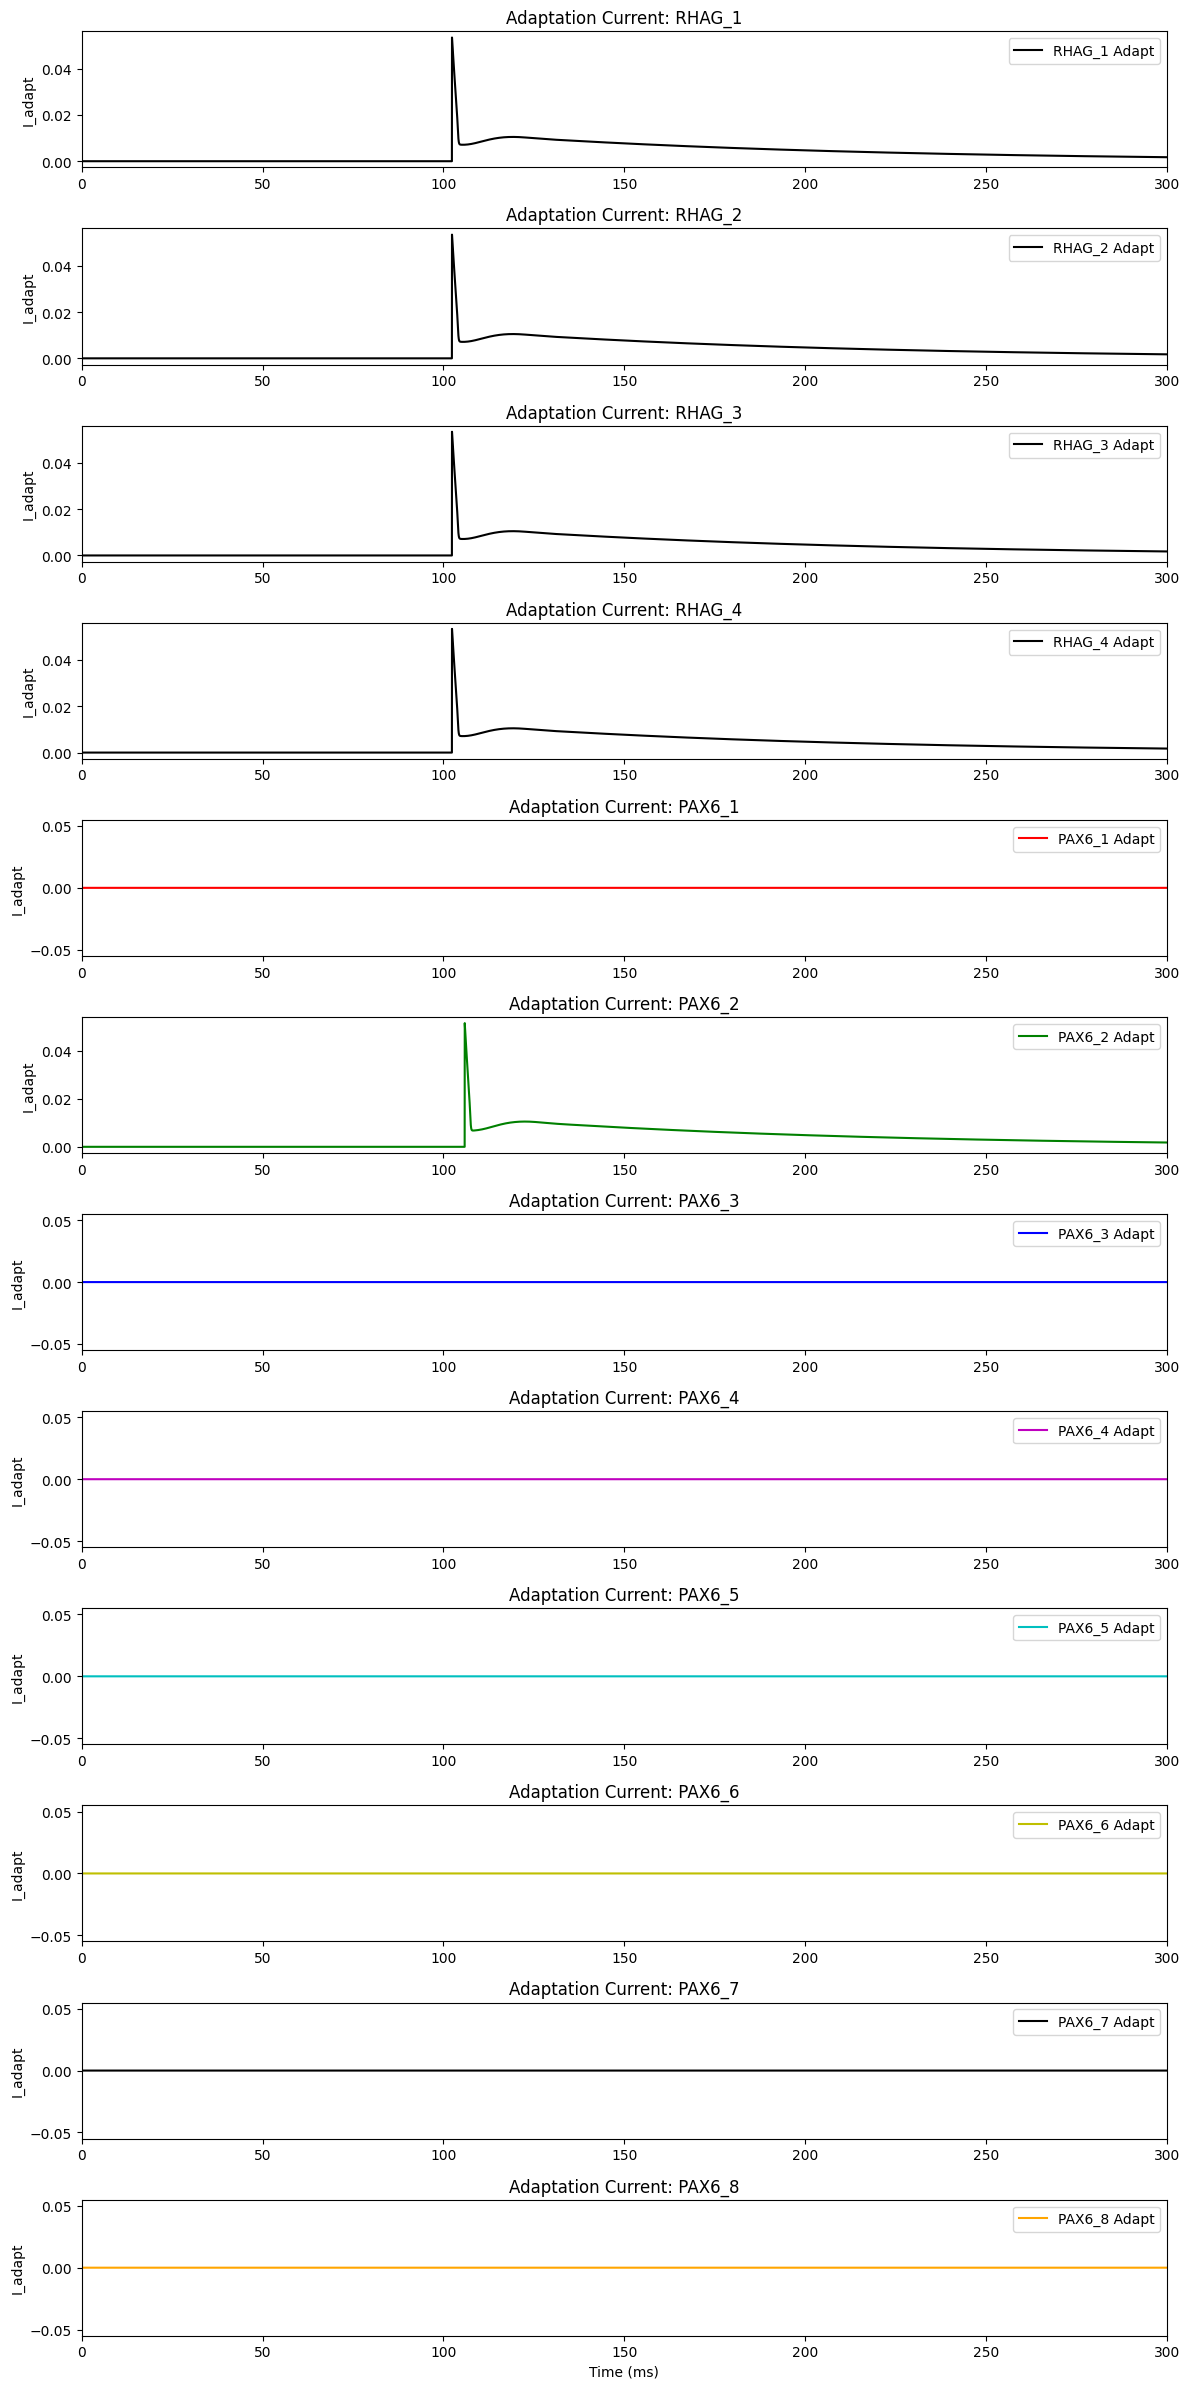

RHAG spikes: 4 at times [array([101.35]), array([101.35]), array([101.35]), array([101.35])]
NRHAG spikes: 23 at times [array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35])]
PAX6_1 spikes: 0 at times []
PAX6_2 spikes: 1 at times [104.875]
PAX6_3 spikes: 0 at times []
PAX6_4 spikes: 0 at times []
PAX6_5 spikes: 0 at times []
PAX6_6 spikes: 0 at times []
PAX6_7 spikes: 0 at times []
PAX6_8 spikes: 0 at times []
RHAG_1 projects to PAX6 neurons: [np.int64(5)]
RHAG_2 projects to PAX6 neurons: []
RHAG_3 projects to PAX6 neurons: [np.int64(7), np.int64(6)]
RHAG_4 projects to PAX6 neurons: [np.int64(5)]
PAX6_1 receives from RHAGs: []
PAX6_2 receives from RHAGs: [

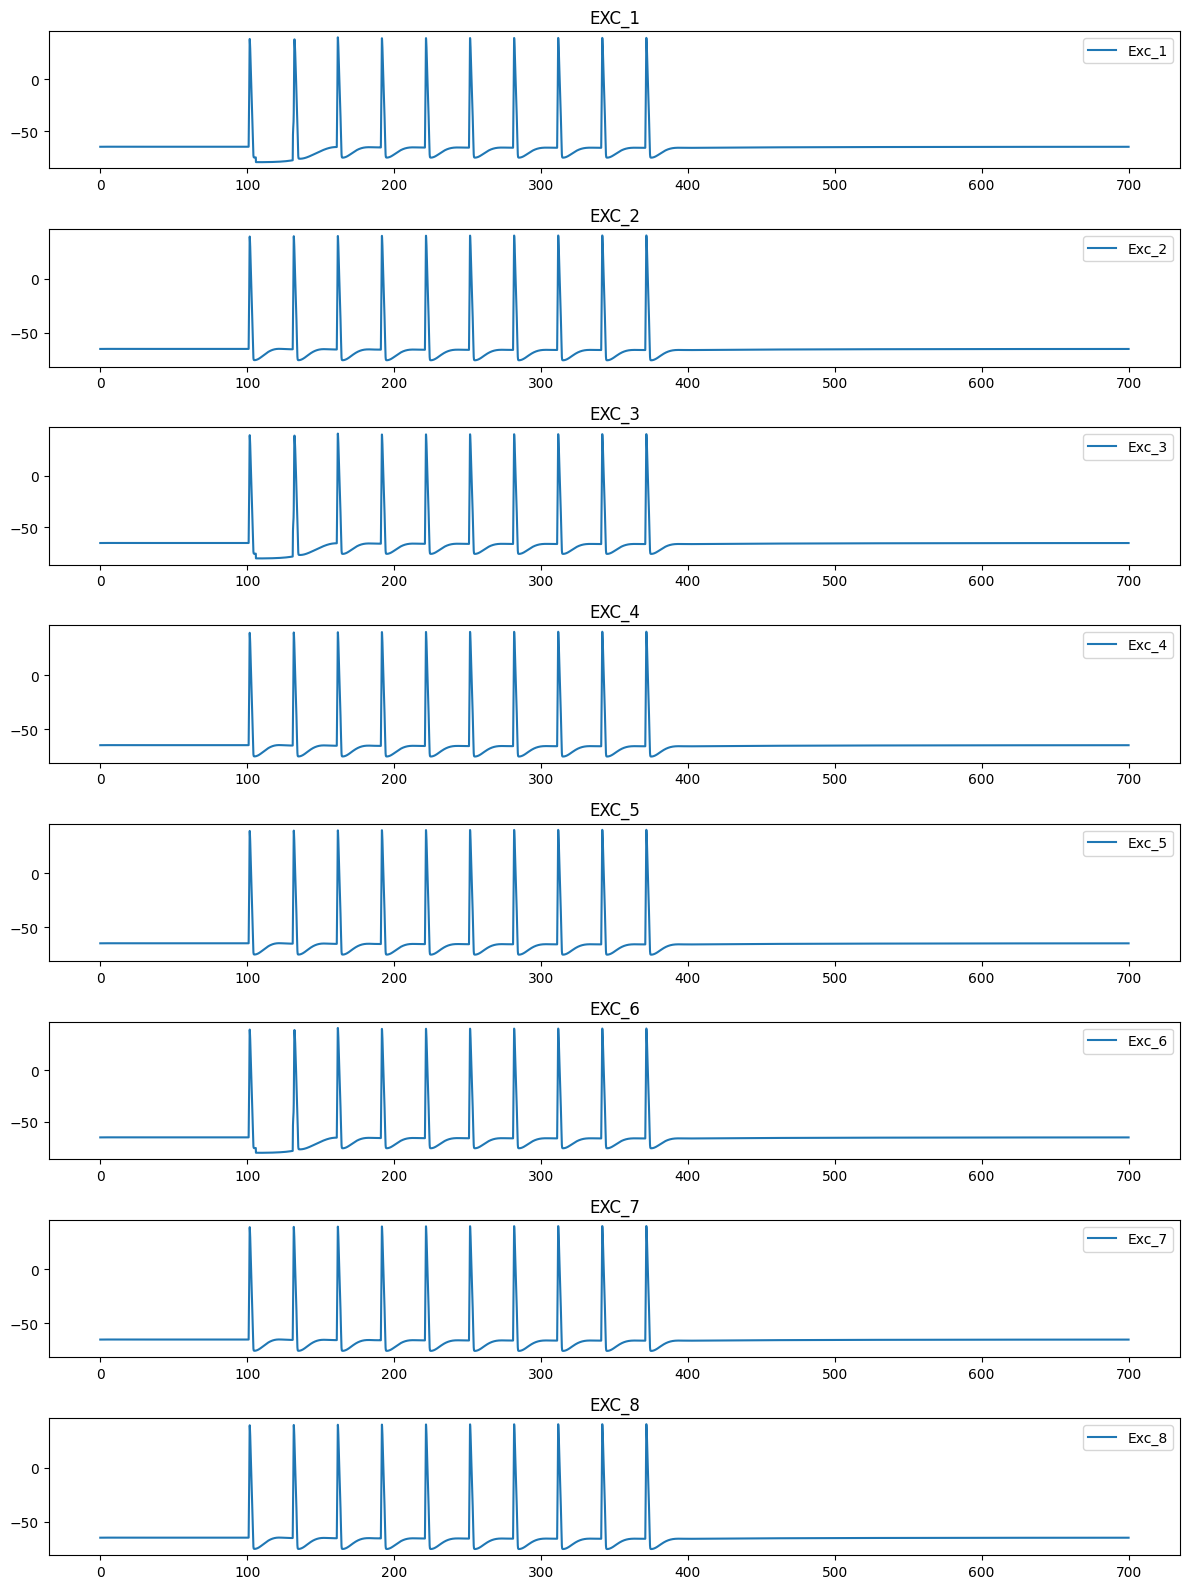

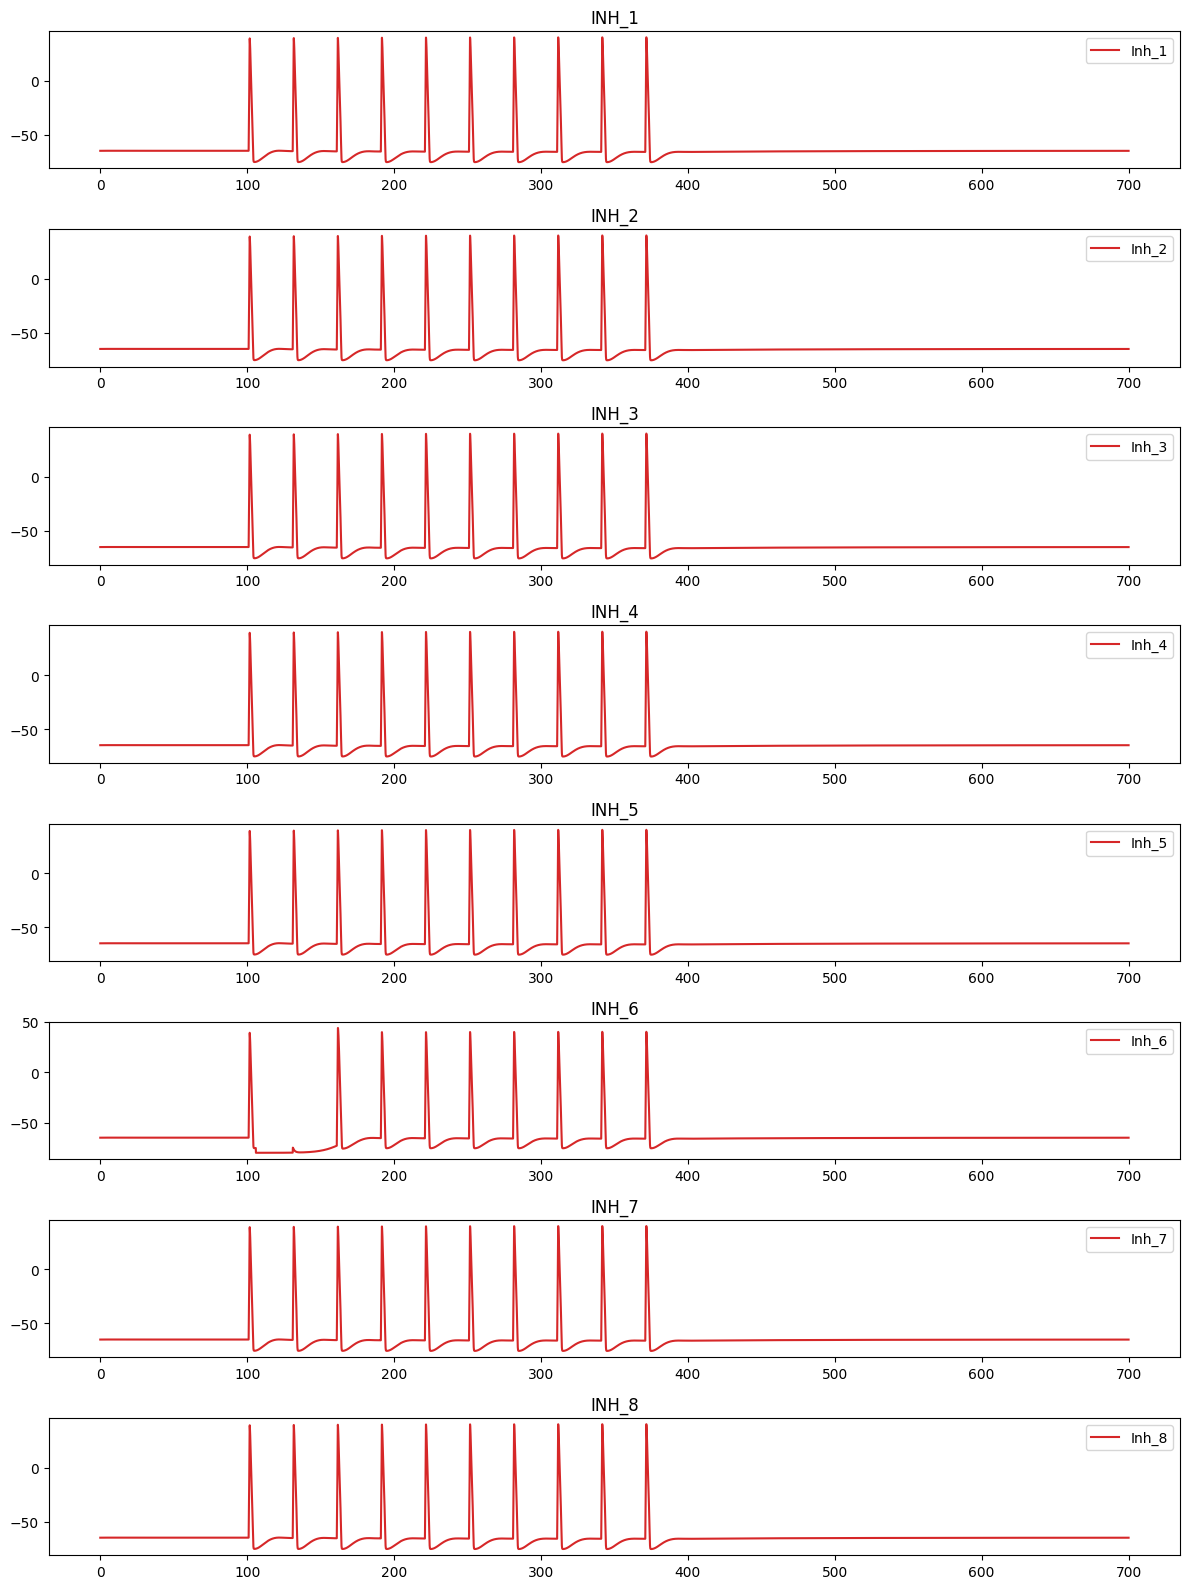

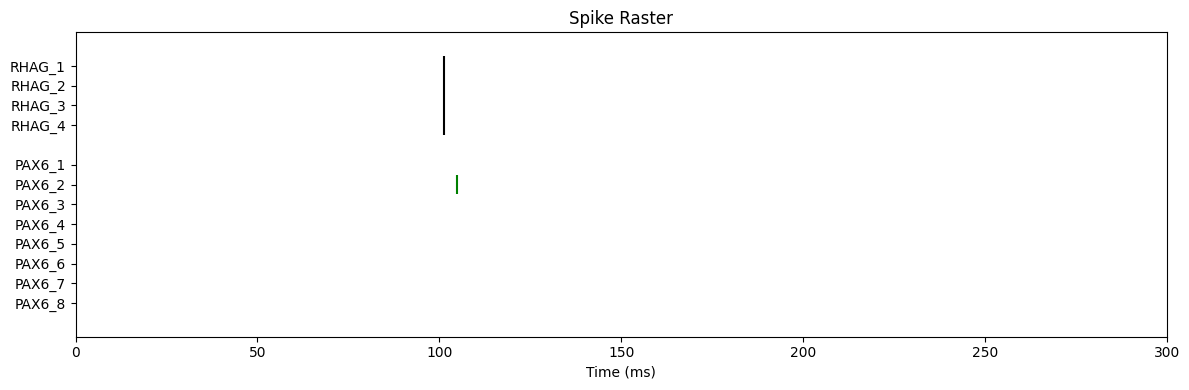

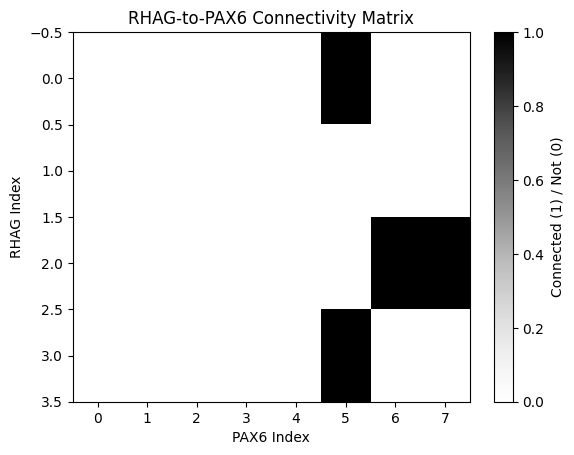

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
v = h.VecStim()


h.load_file("stdrun.hoc")

class HHNeuron:
    def __init__(self, name, adapt_gmax=0.0005, adapt_tau=100, soma_L=30, soma_diam=30):
        self.soma = h.Section(name=name)
        self.soma.L = soma_L
        self.soma.diam = soma_diam
        self.soma.Ra = 100
        self.soma.cm = 1
        self.soma.insert('hh')
        for seg in self.soma:
            seg.hh.gnabar = 0.12
            seg.hh.gkbar = 0.036
            seg.hh.gl = 0.0003
            seg.hh.el = -54.3

        self.adapt = h.Adapt(self.soma(0.5))
        self.adapt.gmax = adapt_gmax
        self.adapt.tau = adapt_tau

        self.v = h.Vector().record(self.soma(0.5)._ref_v)
        self.ina = h.Vector().record(self.soma(0.5)._ref_ina)
        self.ik = h.Vector().record(self.soma(0.5)._ref_ik)
        self.iadapt = h.Vector().record(self.adapt._ref_iadapt)
        self.m = h.Vector().record(self.soma(0.5).hh._ref_m)
        self.h_gate = h.Vector().record(self.soma(0.5).hh._ref_h)
        self.n = h.Vector().record(self.soma(0.5).hh._ref_n)
        self.spikes = h.Vector()
        self.nc = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.nc.threshold = -20
        self.nc.record(self.spikes)
        self.nc_adapt = h.NetCon(self.soma(0.5)._ref_v, self.adapt, sec=self.soma)
        self.nc_adapt.threshold = -20
        self.nc_adapt.weight[0] = 1

class DetonatorInput:
    def __init__(self, target_sec, tau=1, e=0, start=100, weight=0.1):
        self.syn = h.ExpSyn(target_sec(0.5))
        self.syn.e = e
        self.syn.tau = tau

        self.stim = h.NetStim()
        self.stim.start = start
        self.stim.number = 1
        self.stim.interval = 1

        self.nc = h.NetCon(self.stim, self.syn)
        self.nc.weight[0] = weight
        self.isyn = h.Vector().record(self.syn._ref_i)

class RHAGNeuron(HHNeuron):
    def __init__(self):
        super().__init__(name='rhag', adapt_gmax=0.0005, adapt_tau=100)
        self.input = DetonatorInput(self.soma, tau=1, start=100, weight = 0.1)
        self.isyn = self.input.isyn

class PAX6Neuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'pax6_{idx+1}', adapt_gmax=0.0005, adapt_tau=100)
        self.syn = h.ExpSyn(self.soma(0.5))
        self.syn.e = 0
        self.syn.tau = 1
        self.isyn = h.Vector().record(self.syn._ref_i)

class NRHAGNeuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'nrhag_{idx+1}', adapt_tau=90)
        self.input = DetonatorInput(self.soma, tau=1, start=100, weight=0.1)
        self.isyn = self.input.isyn

class ExcNeuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'exc_{idx+1}')
        # Optionally: different channel properties for excitatory neurons

class InhNeuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'inh_{idx+1}')
        # Optionally: different channel properties for inhibitory neurons


#NETWORK CONSTRUCTION

num_rhag = 4
num_pax6 = 8  # Choose >=4 for more realistic overlaps; can be 4 to match your example
num_nrhag = 23  # or whatever number you want!
num_ex = 8  # or more; as desired
num_in = 8
w_mono_inhib = 1.0  # baseline weight for monosynaptic inhibition
w_disyn_inhib = 3.5 * w_mono_inhib  # 3.5 times stronger for disynaptic inhibition


# Create neuron populations
rhag_cells = [RHAGNeuron() for _ in range(num_rhag)]
nrhag_cells = [NRHAGNeuron(i) for i in range(num_nrhag)]
pax6_cells = [PAX6Neuron(idx) for idx in range(num_pax6)]
exc_neurons = [ExcNeuron(i) for i in range(num_ex)]
inh_neurons = [InhNeuron(i) for i in range(num_in)]

rng = np.random.default_rng()
nearest_pax6 = [rng.choice(num_pax6, size=4, replace=False) for _ in range(num_rhag)]
nearest_pax6_nrhag = [rng.choice(num_pax6, size=4, replace=False) for _ in range(num_nrhag)]
# Anatomical connection and transmission unreliability (VecStim relay method)

p_proj = 20 / 43  # connection probability
p_transmit = 0.91 # per-spike transmission probability

p_proj_nrhag = 5 / 37         # 0.135 connectivity probability
p_transmit_nrhag = 0.2        # Biologically, rarely transmit spikes


nrhag_connections = []
all_nrhag_relay_netcons = []

connections = []
all_relay_netcons = []

connections_ei = []  # keep references!
ei_syns = []

# For each PAX6 neuron, select a random set of excitatory and inhibitory neurons to target
ei_targets = []


# First simulate RHAGs to get their spike times
h.finitialize(-65)
h.continuerun(700)
spikes_rhag = [np.array(list(r.spikes)) for r in rhag_cells]

# Simulate NRHAGs separately to get their spike times
nrhag_spikes = []
for n in nrhag_cells:
    h.finitialize(-65)
    h.continuerun(700)
    nrhag_spikes.append(np.array(list(n.spikes)))


# Now, for each established connection: relay only 91% of spikes from RHAG to PAX6 using VecStim
for rhag_idx, rhag in enumerate(rhag_cells):
    for pax6_idx in nearest_pax6[rhag_idx]:
        if rng.uniform() < p_proj:
            # Only use 91% of presynaptic spikes for actual transmission
            relayed_spikes = [t+1.0 for t in spikes_rhag[rhag_idx] if rng.uniform() < p_transmit]  # 1ms delay
            if relayed_spikes:
                relay_vec = h.Vector(relayed_spikes)
                relay_stim = h.VecStim()
                relay_stim.play(relay_vec)
                nc = h.NetCon(relay_stim, pax6_cells[pax6_idx].syn)
                nc.weight[0] = 0.1
                all_relay_netcons.append(nc)  # Keep refs alive!
            connections.append((rhag_idx, pax6_idx, 0.1))
        else:
            connections.append((rhag_idx, pax6_idx, 0.0))

# NRHAG -> PAX6 VecStim relay
for nrhag_idx, nrhag in enumerate(nrhag_cells):
    for pax6_idx in nearest_pax6_nrhag[nrhag_idx]:
        if rng.uniform() < p_proj_nrhag:
            relayed_spikes = [t+1.0 for t in nrhag_spikes[nrhag_idx] if rng.uniform() < p_transmit_nrhag]
            if relayed_spikes:
                relay_vec = h.Vector(relayed_spikes)
                relay_stim = h.VecStim()
                relay_stim.play(relay_vec)
                nc = h.NetCon(relay_stim, pax6_cells[pax6_idx].syn)
                nc.weight[0] = 0.01      # <<--- USE SMALLER VALUE HERE!
                all_nrhag_relay_netcons.append(nc)
            nrhag_connections.append((nrhag_idx, pax6_idx, 0.01))
        else:
            nrhag_connections.append((nrhag_idx, pax6_idx, 0.0))

# Give PAX6 an earlier start (e.g., 90 ms), make EI input later (e.g., >=110 ms)
#for neuron in exc_neurons + inh_neurons:
    #neuron.input = DetonatorInput(neuron.soma, tau=1, start=120, weight=0.1)  # Fires after PAX6


ei_targets = []

w_silence = 20.0  # Try values 10-30, tune until you get flat traces!

for pax6_idx, pax6 in enumerate(pax6_cells):
    targets = rng.choice(num_ex + num_in, size=4, replace=False)
    ei_targets.append(targets)
    for idx in targets:
        if idx < num_ex:
            target = exc_neurons[idx]
        else:
            target = inh_neurons[idx - num_ex]
        inh_syn = h.ExpSyn(target.soma(0.5))
        inh_syn.e = -80
        inh_syn.tau = 7
        netcon = h.NetCon(pax6.soma(0.5)._ref_v, inh_syn, sec=pax6.soma)
        netcon.threshold = -20

        # After first simulation, use silenced_indices (from your code) for strong inhibition
        # ATTENTION: you may need to reconstruct these synapses after your first run, or store the connection objects and set the .weight[0] value after you build silenced_indices!
        netcon.weight[0] = w_disyn_inhib   # Always use the standard weight here.
        connections_ei.append(netcon)      # Store NetCon reference for later updating.

        connections_ei.append(netcon)
        ei_syns.append(inh_syn)


# Collect indices of all EI neurons targeted for silencing by any PAX6
silenced_indices = set()
for targets in ei_targets:
    silenced_indices.update(targets)

for neuron in exc_neurons + inh_neurons:
    # 10 spikes at intervals of 30 ms starting at 100 ms
    neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
    neuron.input.stim.number = 10
    neuron.input.stim.interval = 30


# Assign DetonatorInput ONLY to EI neurons NOT in silenced_indices
#for i, neuron in enumerate(exc_neurons + inh_neurons):
#    if i not in silenced_indices:
#        neuron.input = DetonatorInput(neuron.soma, tau=1, start=120, weight=0.1)
    # No input for silenced neurons means they remain silent (flat)



# Initialize t vector just once
t = h.Vector().record(h._ref_t)


#SIMULATION

# Assign DetonatorInput for multiple spikes ONLY to non-silenced EI neurons
# First, determine the indices to silence by running a quick simulation

# Assign input to all by default
for neuron in exc_neurons + inh_neurons:
    neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
    neuron.input.stim.number = 10
    neuron.input.stim.interval = 30
    
# SIMULATE
h.finitialize(-65)
h.continuerun(700)

# Find triggered PAX6 (those that spike)
def vnp(v): return np.array(list(v))
def arrlst(lst): return [np.array(list(x)) for x in lst]
spikes_pax6_np = arrlst([p.spikes for p in pax6_cells])
triggered_pax6_indices = [idx for idx, s in enumerate(spikes_pax6_np) if len(s) > 0]
silenced_indices = set()
for idx in triggered_pax6_indices:
    silenced_indices.update(ei_targets[idx])

w_silence = 50.0  # Or tune as needed

for ei_idx, nc in enumerate(connections_ei):
    if ei_idx in silenced_indices:
        nc.weight[0] = w_silence   # Strong inhibition for silenced EI
    else:
        nc.weight[0] = w_disyn_inhib   # Normal inhibition otherwise


# Assign input ONLY to non-silenced indices (overwrite previous input for silenced ones)
#for i, neuron in enumerate(exc_neurons + inh_neurons):
#    if i in silenced_indices:
#        neuron.input.stim.number = 0  # disables all presynaptic spikes for the NetStim
#    else:
#        neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
#        neuron.input.stim.number = 10
#        neuron.input.stim.interval = 30

# SIMULATE again for final output!
h.finitialize(-65)
h.continuerun(700)


#DATA EXTRACTION

# Convert t only once
t_np = np.array(t)



v_rhag = [vnp(r.v) for r in rhag_cells]
ina_rhag = [vnp(r.ina) for r in rhag_cells]
ik_rhag = [vnp(r.ik) for r in rhag_cells]
iadapt_rhag = [vnp(r.iadapt) for r in rhag_cells]
isyn_rhag = [vnp(r.isyn) for r in rhag_cells]
spikes_rhag = [vnp(r.spikes) for r in rhag_cells]

v_pax6 = [vnp(p.v) for p in pax6_cells]

isyn_pax6_np = arrlst([p.isyn for p in pax6_cells])
iadapt_pax6_np = arrlst([p.iadapt for p in pax6_cells])
# Data extraction for NRHAG
v_nrhag = [vnp(n.v) for n in nrhag_cells]
ina_nrhag = [vnp(n.ina) for n in nrhag_cells]
ik_nrhag = [vnp(n.ik) for n in nrhag_cells]
iadapt_nrhag = [vnp(n.iadapt) for n in nrhag_cells]
spikes_nrhag = [vnp(n.spikes) for n in nrhag_cells]



#PLOTTING

plt.figure(figsize=(12, 2 * num_rhag))
for i, v in enumerate(v_rhag):
    plt.subplot(num_rhag, 1, i + 1)
    plt.plot(t_np, v, label=f'RHAG_{i+1}', color='k')
    plt.ylabel('V_m (mV)')
    plt.title(f'Membrane Potential: RHAG_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

# Plot NRHAG membrane potentials
plt.figure(figsize=(12, 2 * num_nrhag))
for i, v in enumerate(v_nrhag):
    plt.subplot(num_nrhag, 1, i + 1)
    plt.plot(t_np, v, label=f'NRHAG_{i+1}', color='b')
    plt.ylabel('V_m (mV)')
    plt.title(f'Membrane Potential: NRHAG_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 2 * num_pax6))
for i, v in enumerate(v_pax6):
    plt.subplot(num_pax6, 1, i + 1)
    plt.plot(t_np, v, label=f'PAX6_{i+1}', color=['r','g','b','m','c','y','k','orange'][i % 8])
    plt.ylabel('V_m (mV)')
    plt.title(f'Membrane Potential: PAX6_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()


# Synaptic currents for each PAX6 neuron
plt.figure(figsize=(12, 2 * num_pax6))
import itertools
colors = itertools.cycle(['r', 'g', 'b', 'm', 'c', 'y', 'k', 'orange'])
for idx, isyn in enumerate(isyn_pax6_np):
    plt.subplot(num_pax6, 1, idx + 1)
    plt.plot(t_np, isyn, color=next(colors), label=f'PAX6_{idx + 1} syn current')
    plt.ylabel('I_syn (nA)')
    plt.legend()
    plt.title(f'Synaptic Current into PAX6_{idx + 1}')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2 * (num_rhag + num_pax6)))
for i, ia in enumerate(iadapt_rhag):
    plt.subplot(num_rhag + num_pax6, 1, i + 1)
    plt.plot(t_np, ia, label=f'RHAG_{i+1} Adapt', color='k')
    plt.ylabel('I_adapt')
    plt.title(f'Adaptation Current: RHAG_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
for idx, ia in enumerate(iadapt_pax6_np):
    plt.subplot(num_rhag + num_pax6, 1, num_rhag + idx + 1)
    plt.plot(t_np, ia, label=f'PAX6_{idx+1} Adapt', color=['r','g','b','m','c','y','k','orange'][idx % 8])
    plt.ylabel('I_adapt')
    plt.title(f'Adaptation Current: PAX6_{idx+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()


print(f"RHAG spikes: {len(spikes_rhag)} at times {spikes_rhag}")
print(f"NRHAG spikes: {len(spikes_nrhag)} at times {spikes_nrhag}")

for idx, s in enumerate(spikes_pax6_np):
    print(f"PAX6_{idx+1} spikes: {len(s)} at times {s}")

for rhag_idx in range(num_rhag):
    partners = [pax6_idx for (r_idx, pax6_idx, w) in connections if r_idx == rhag_idx and w > 0.0]
    print(f"RHAG_{rhag_idx+1} projects to PAX6 neurons: {partners}")
for pax6_idx in range(num_pax6):
    sources = [r_idx+1 for (r_idx, p_idx, w) in connections if p_idx==pax6_idx and w > 0.0]
    print(f"PAX6_{pax6_idx+1} receives from RHAGs: {sources}")

for nrhag_idx in range(num_nrhag):
    partners = [pax6_idx for (n_idx, pax6_idx, w) in nrhag_connections if n_idx == nrhag_idx and w > 0.0]
    print(f"NRHAG_{nrhag_idx+1} projects to PAX6 neurons: {partners}")

for pax6_idx in range(num_pax6):
    sources = [n_idx+1 for (n_idx, p_idx, w) in nrhag_connections if p_idx==pax6_idx and w > 0.0]
    print(f"PAX6_{pax6_idx+1} receives from NRHAGs: {sources}")

for idx, targets in enumerate(ei_targets):
    ei_labels = []
    for t in targets:
        if t < num_ex:
            ei_labels.append(f'E{t+1}')
        else:
            ei_labels.append(f'I{t+1-num_ex}')
    print(f'PAX6_{idx+1} targets: {ei_labels}')

# Excitatory neurons
plt.figure(figsize=(12, 2*num_ex))
for i, neuron in enumerate(exc_neurons):
    plt.subplot(num_ex, 1, i+1)
    plt.plot(t_np, vnp(neuron.v), color='tab:blue', label=f'Exc_{i+1}')
    plt.title(f"EXC_{i+1}")
    plt.legend()
plt.tight_layout()
plt.show()

# Inhibitory neurons
plt.figure(figsize=(12, 2*num_in))
for i, neuron in enumerate(inh_neurons):
    plt.subplot(num_in, 1, i+1)
    plt.plot(t_np, vnp(neuron.v), color='tab:red', label=f'Inh_{i+1}')
    plt.title(f"INH_{i+1}")
    plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 4))
all_spikes = spikes_rhag + spikes_pax6_np
lineoffsets = list(range(num_rhag, 0, -1)) + list(range(-1, -num_pax6-1, -1))
plt.eventplot(all_spikes, lineoffsets=lineoffsets, colors=['k']*num_rhag + ['r','g','b','m','c','y','k','orange'][:num_pax6])
plt.yticks(
    list(range(num_rhag, 0, -1)) + list(range(-1, -num_pax6-1, -1)),
    [f'RHAG_{i+1}' for i in range(num_rhag)] + [f'PAX6_{i+1}' for i in range(num_pax6)]
)
plt.xlim(0, 300)
plt.xlabel('Time (ms)')
plt.title('Spike Raster')
plt.tight_layout()
plt.show()

conn_matrix = np.zeros((num_rhag, num_pax6))
for r, p, w in connections:
    if w > 0: conn_matrix[r, p] = 1
plt.imshow(conn_matrix, aspect='auto', cmap='Greys')
plt.xlabel('PAX6 Index')
plt.ylabel('RHAG Index')
plt.title('RHAG-to-PAX6 Connectivity Matrix')
plt.colorbar(label="Connected (1) / Not (0)")
plt.show()



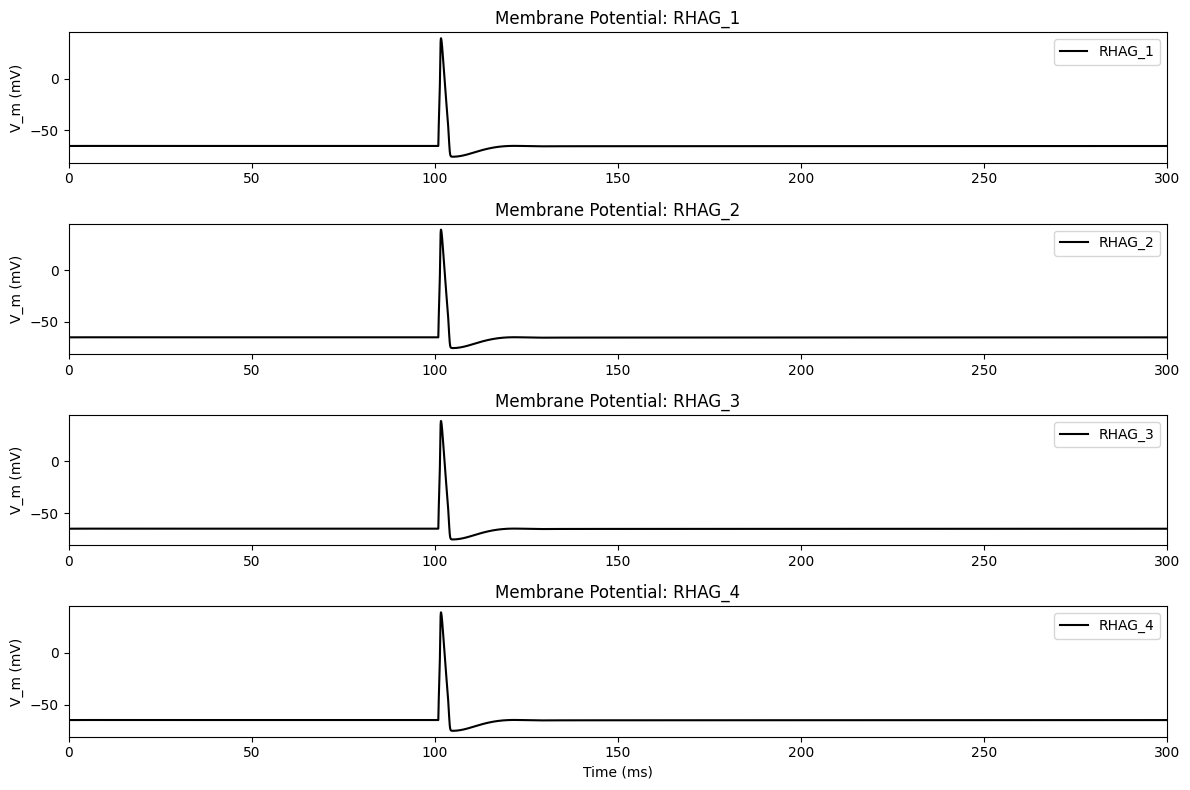

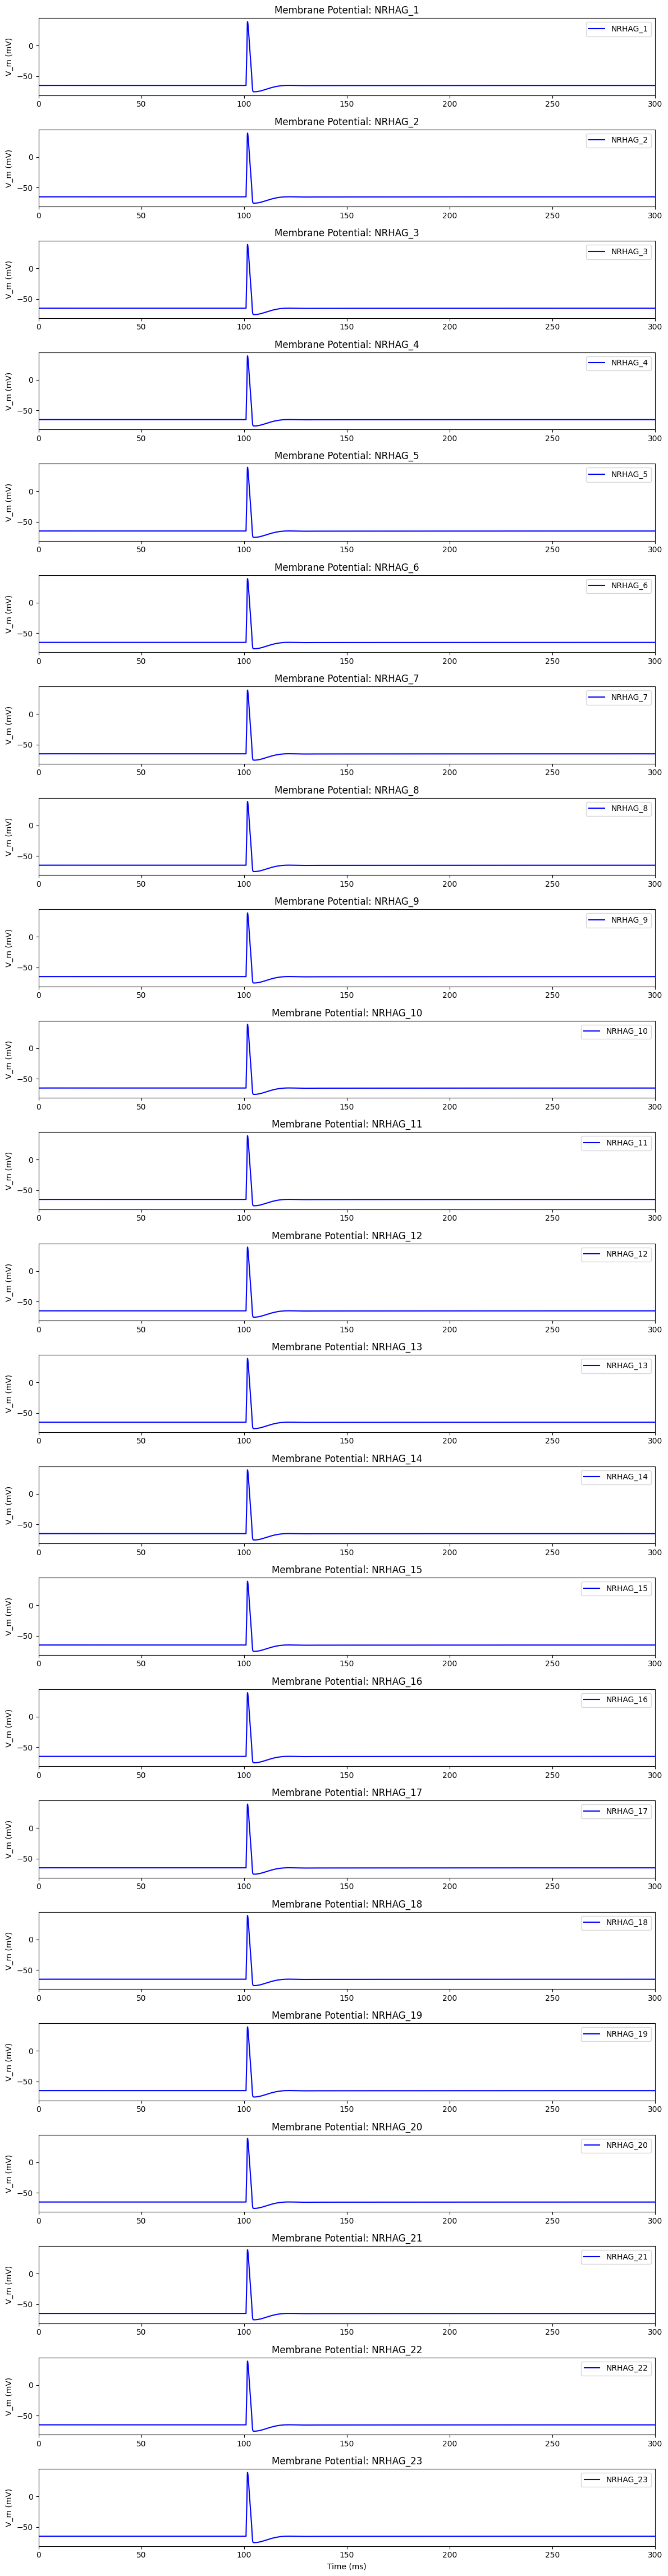

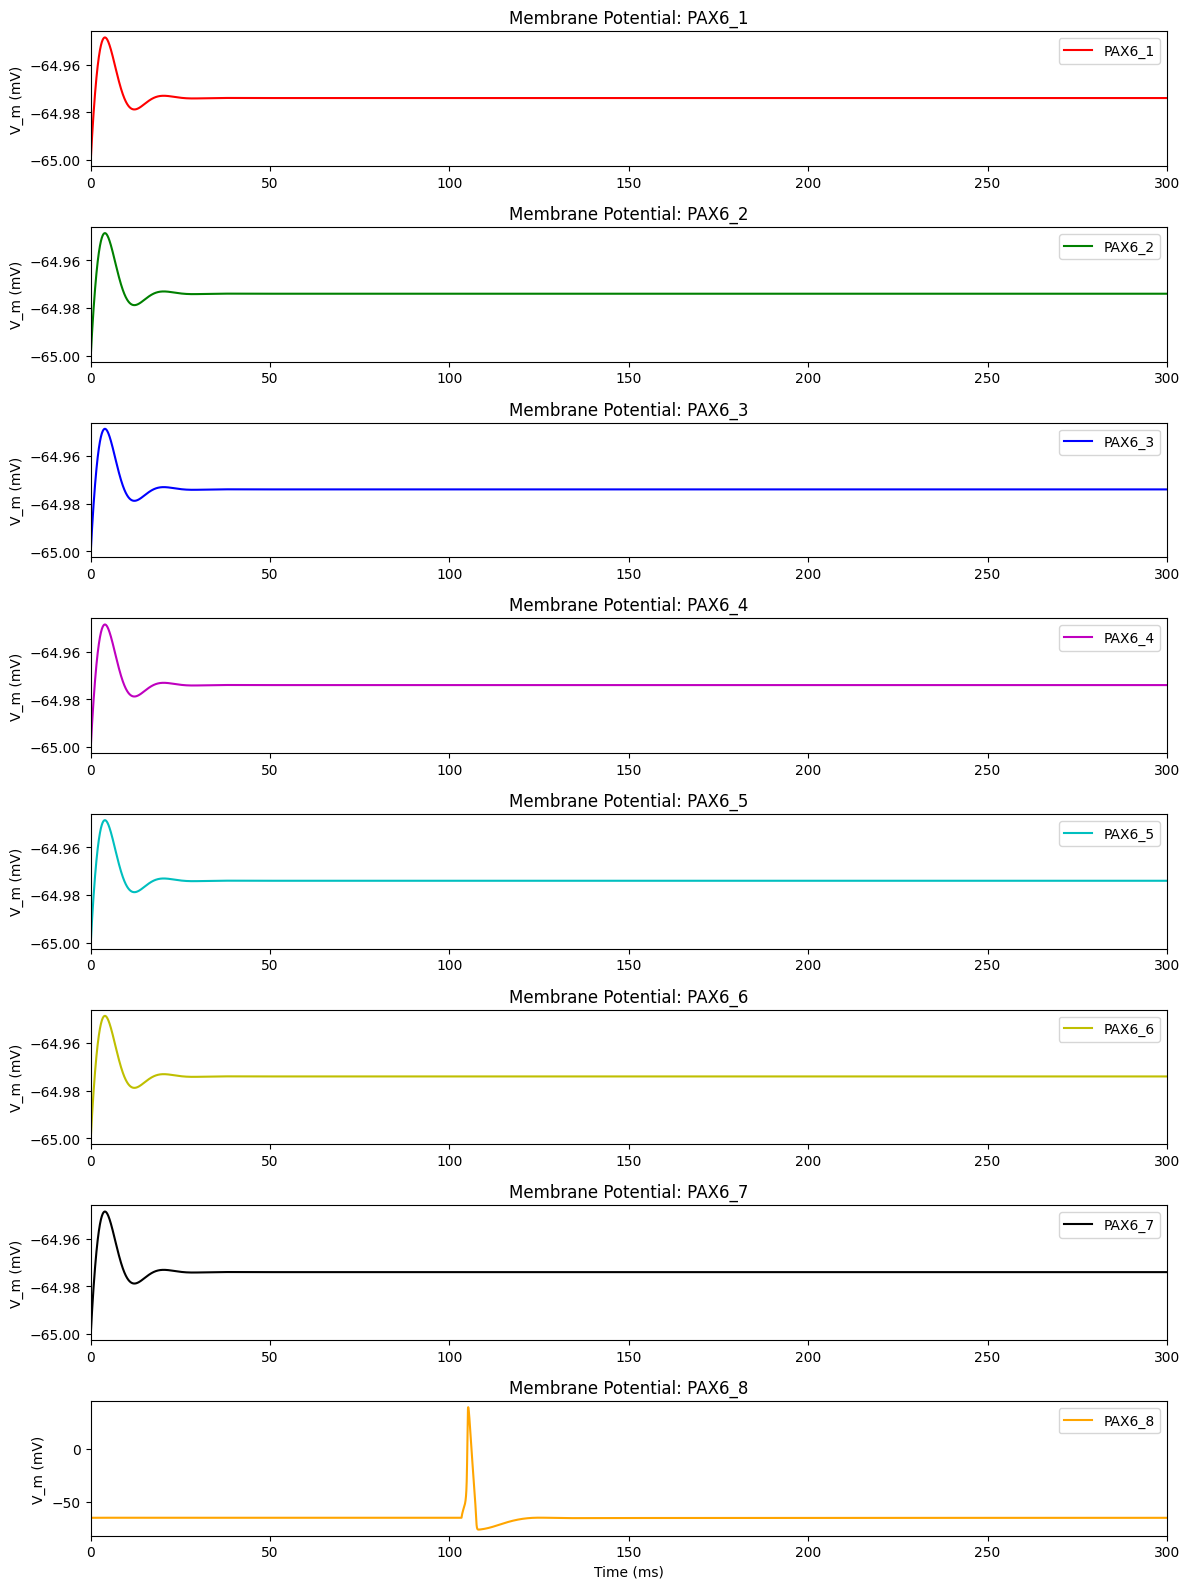

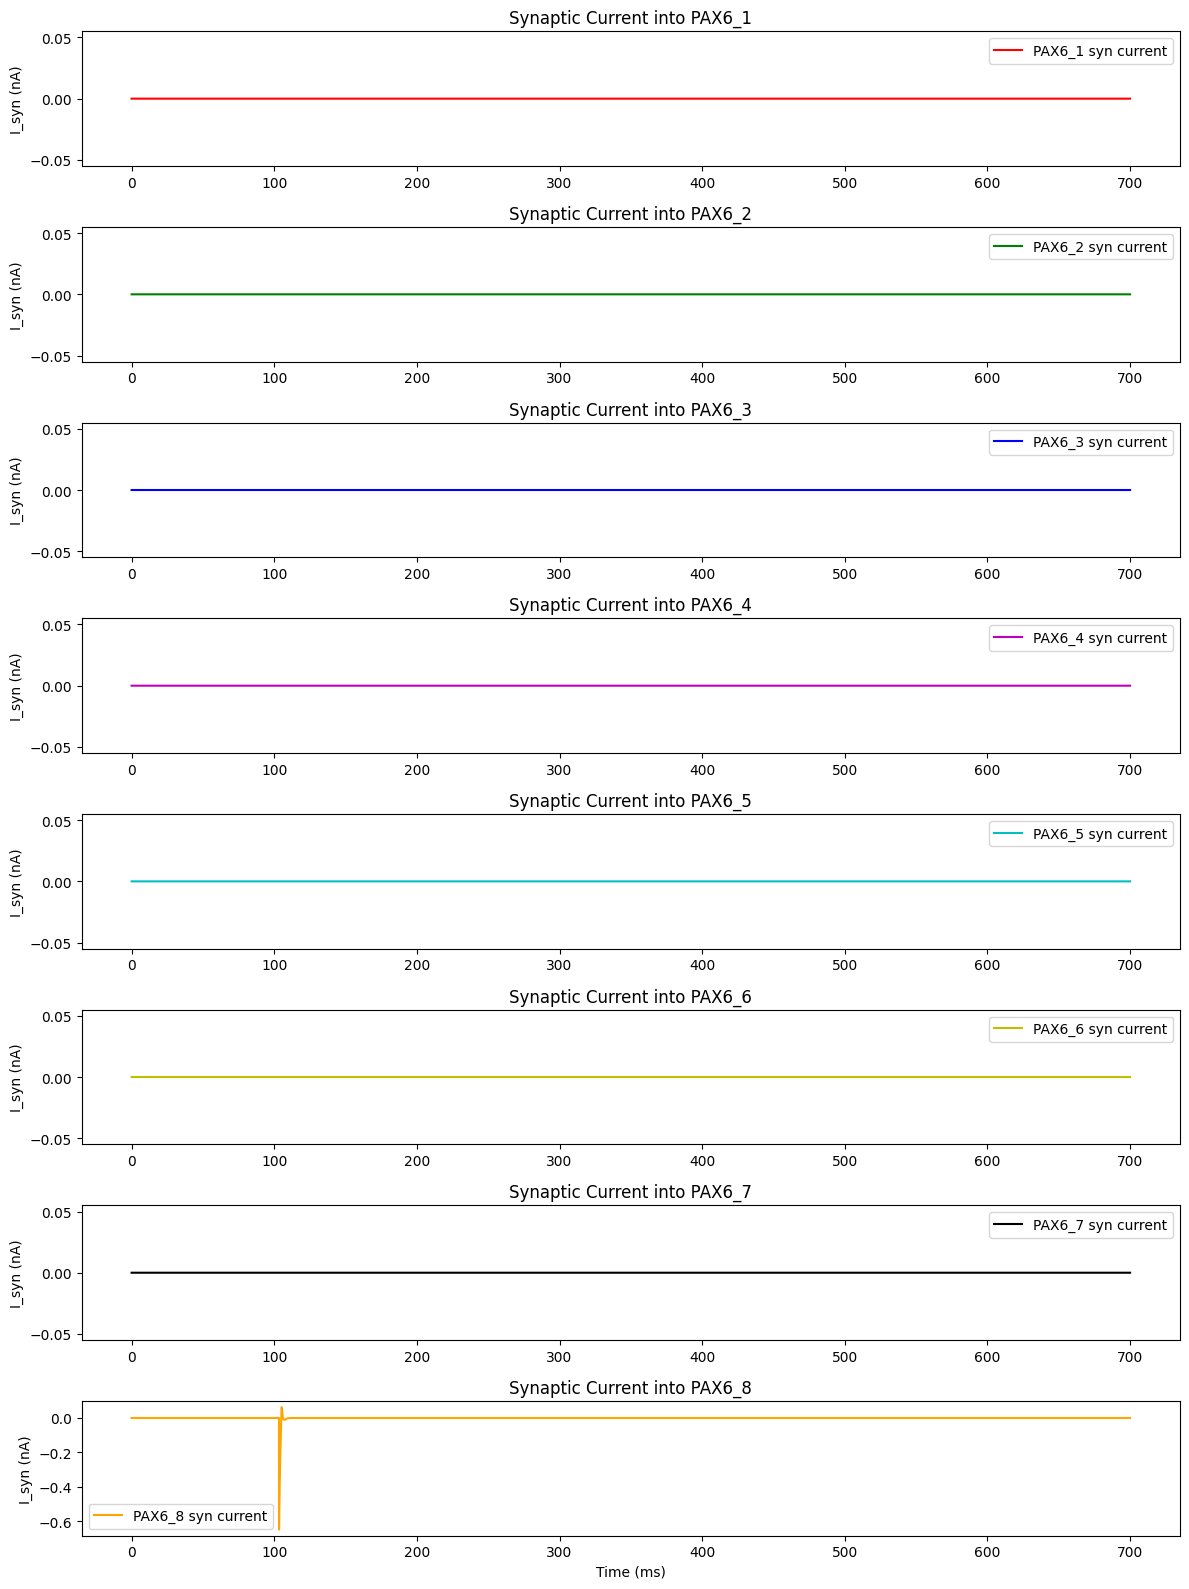

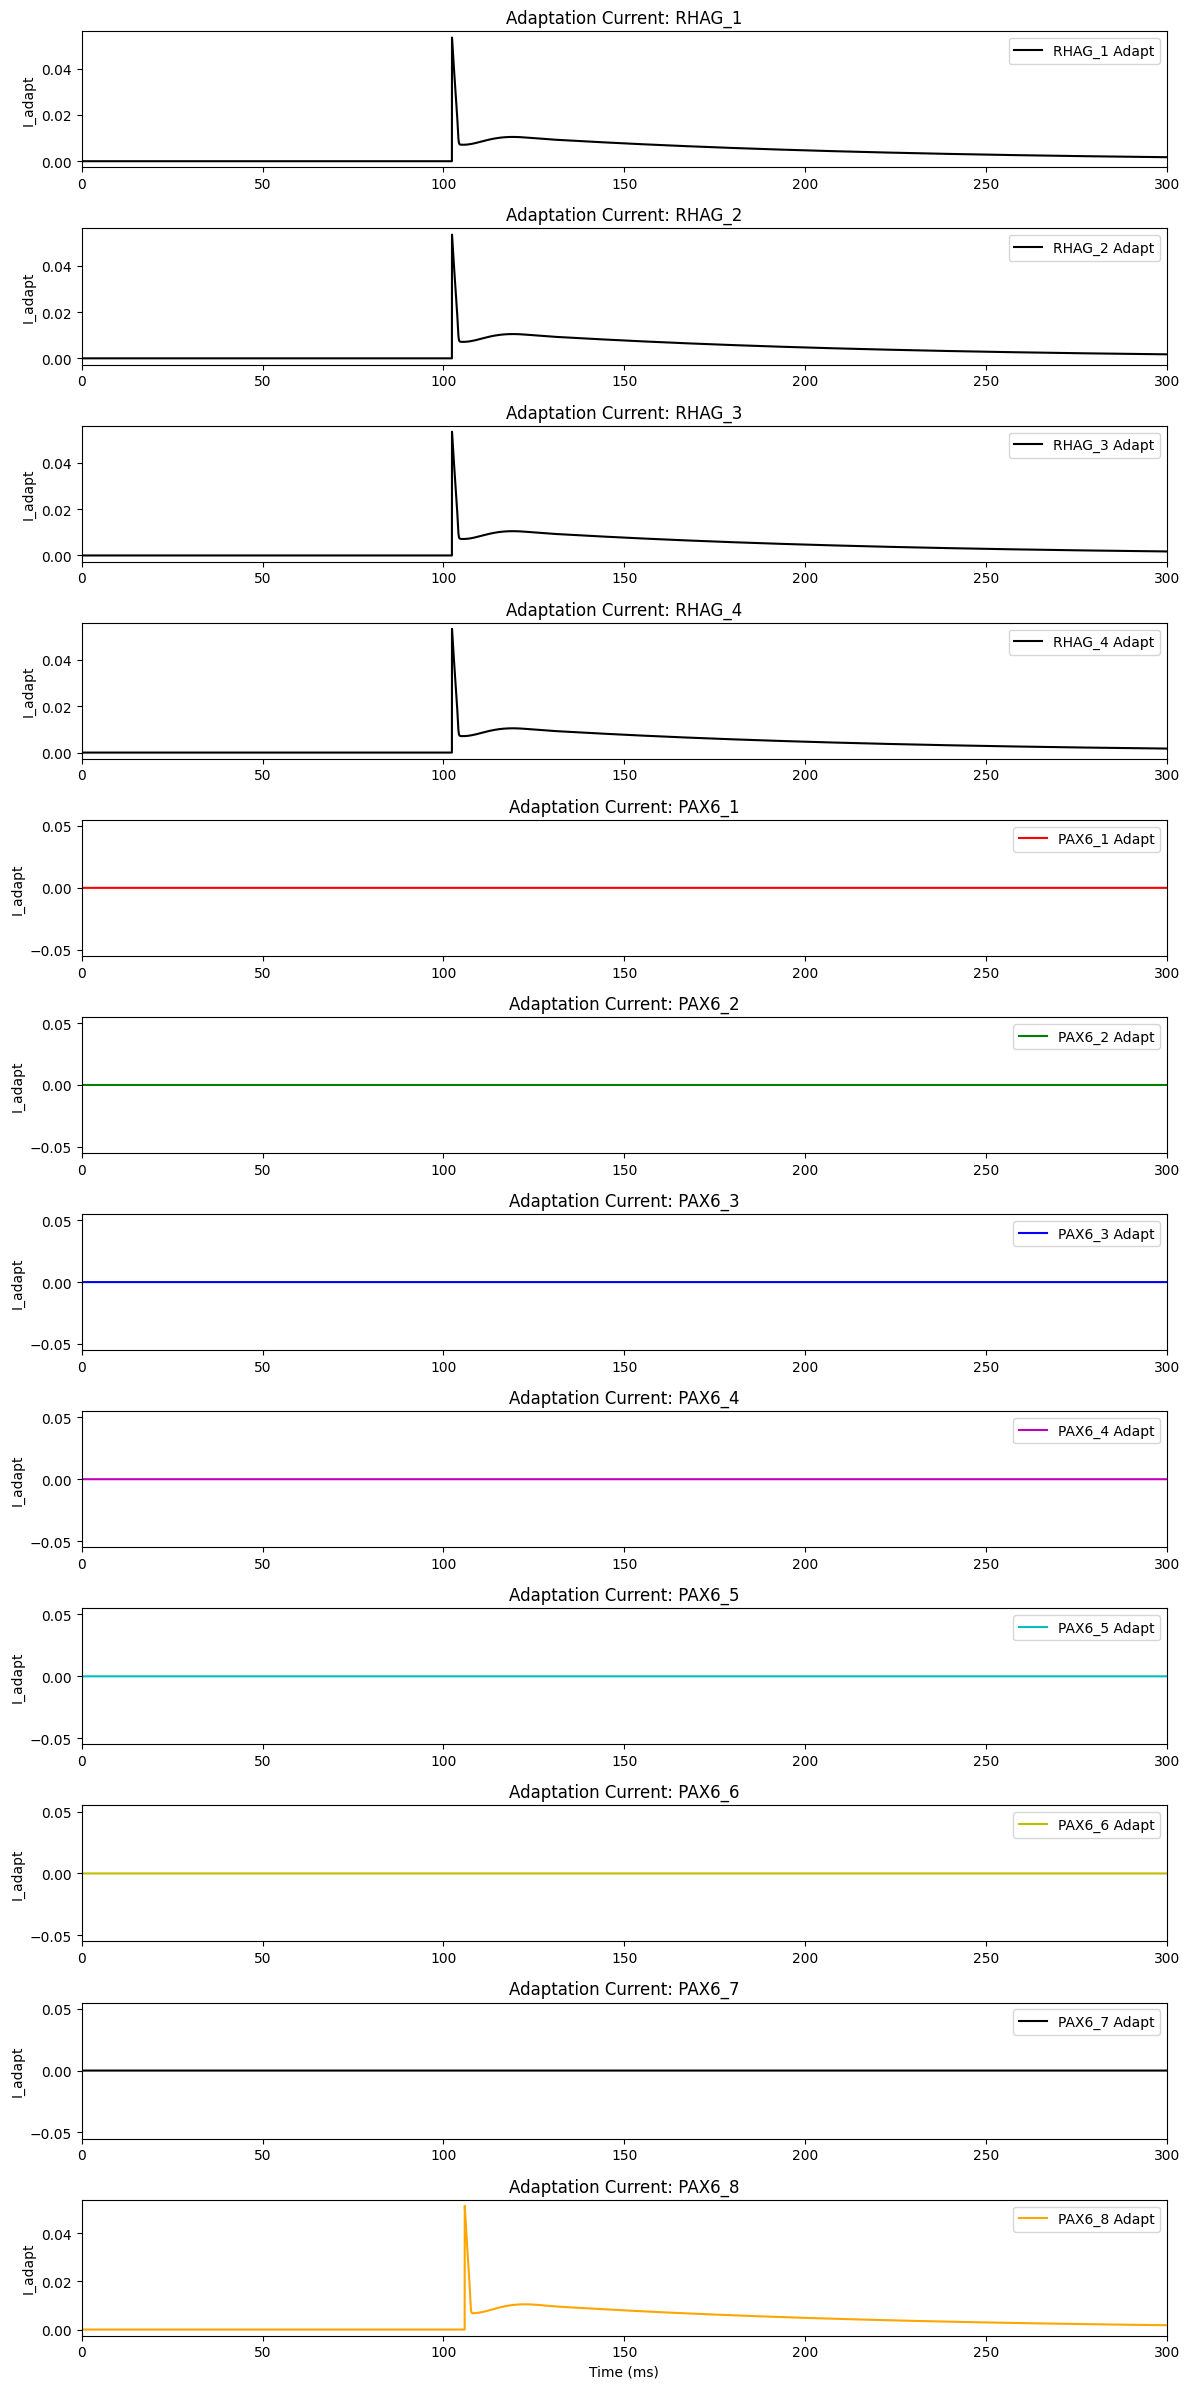

RHAG spikes: 4 at times [array([101.35]), array([101.35]), array([101.35]), array([101.35])]
NRHAG spikes: 23 at times [array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35])]
PAX6_1 spikes: 0 at times []
PAX6_2 spikes: 0 at times []
PAX6_3 spikes: 0 at times []
PAX6_4 spikes: 0 at times []
PAX6_5 spikes: 0 at times []
PAX6_6 spikes: 0 at times []
PAX6_7 spikes: 0 at times []
PAX6_8 spikes: 1 at times [104.875]
RHAG_1 projects to PAX6 neurons: [np.int64(4), np.int64(0), np.int64(2)]
RHAG_2 projects to PAX6 neurons: []
RHAG_3 projects to PAX6 neurons: [np.int64(6)]
RHAG_4 projects to PAX6 neurons: [np.int64(6), np.int64(4), np.int64(5), np.int64(2)]
PAX6_1 r

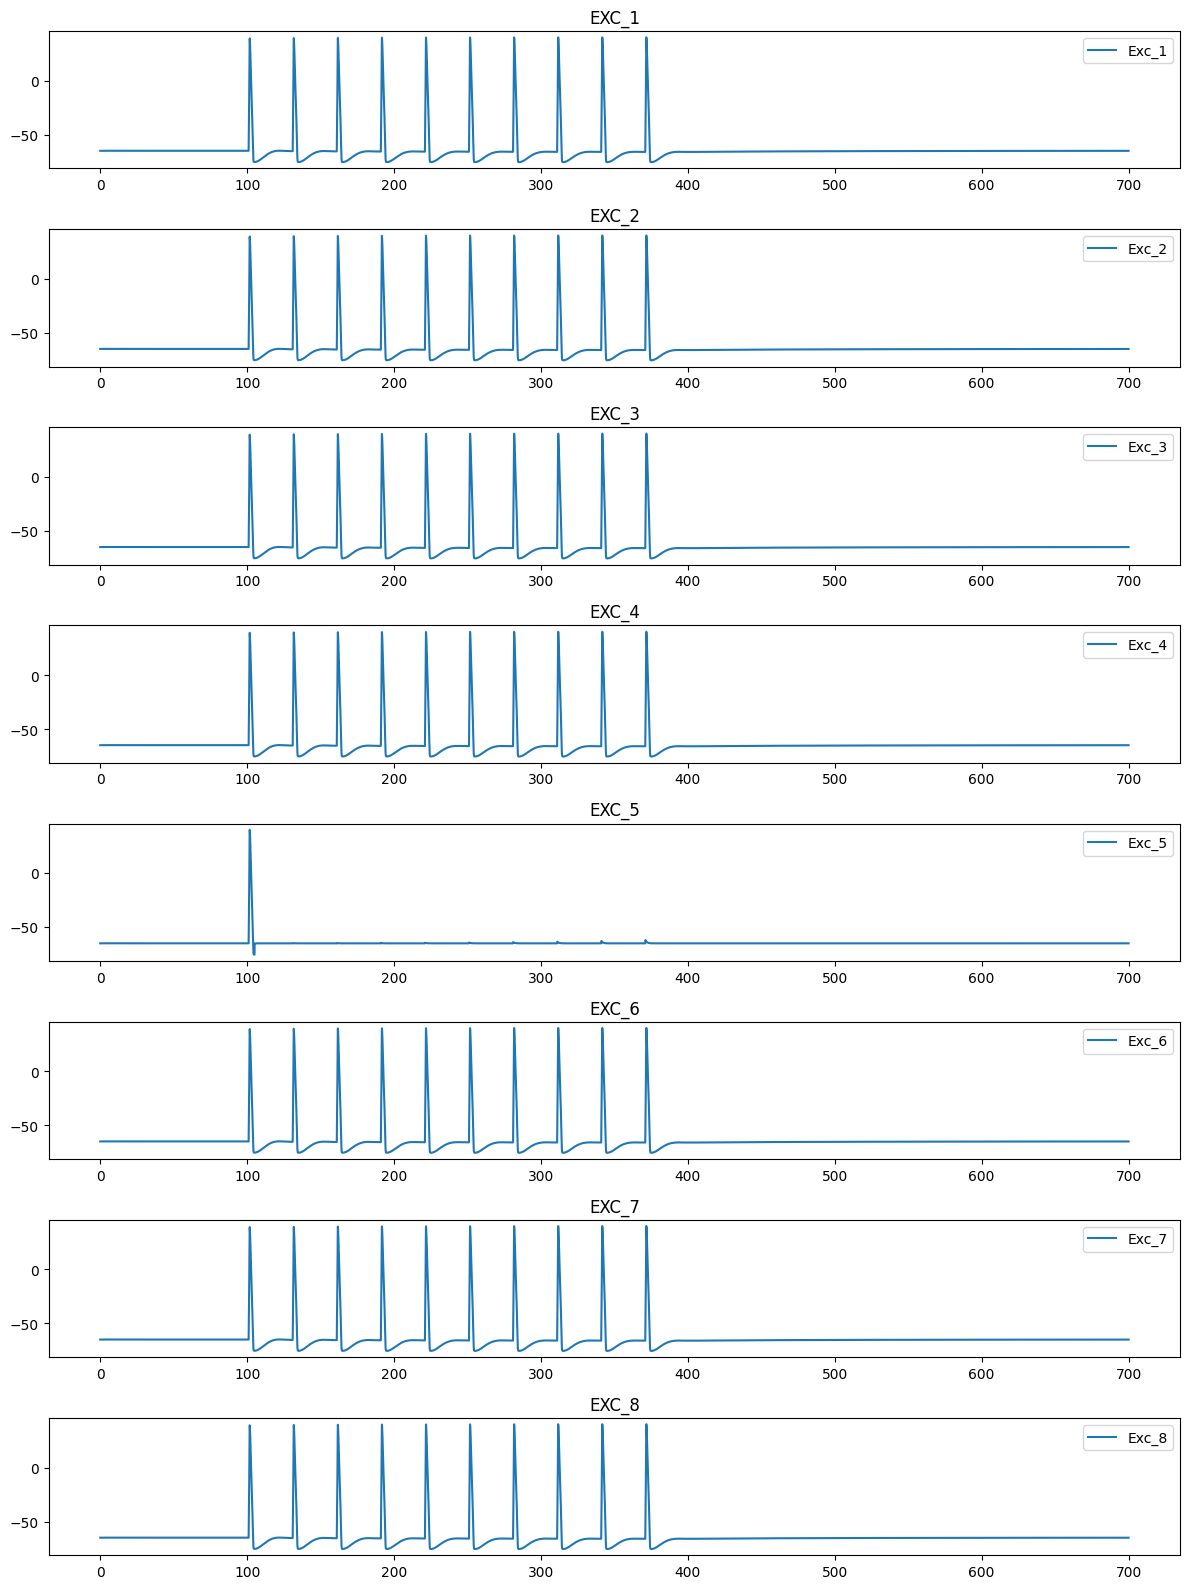

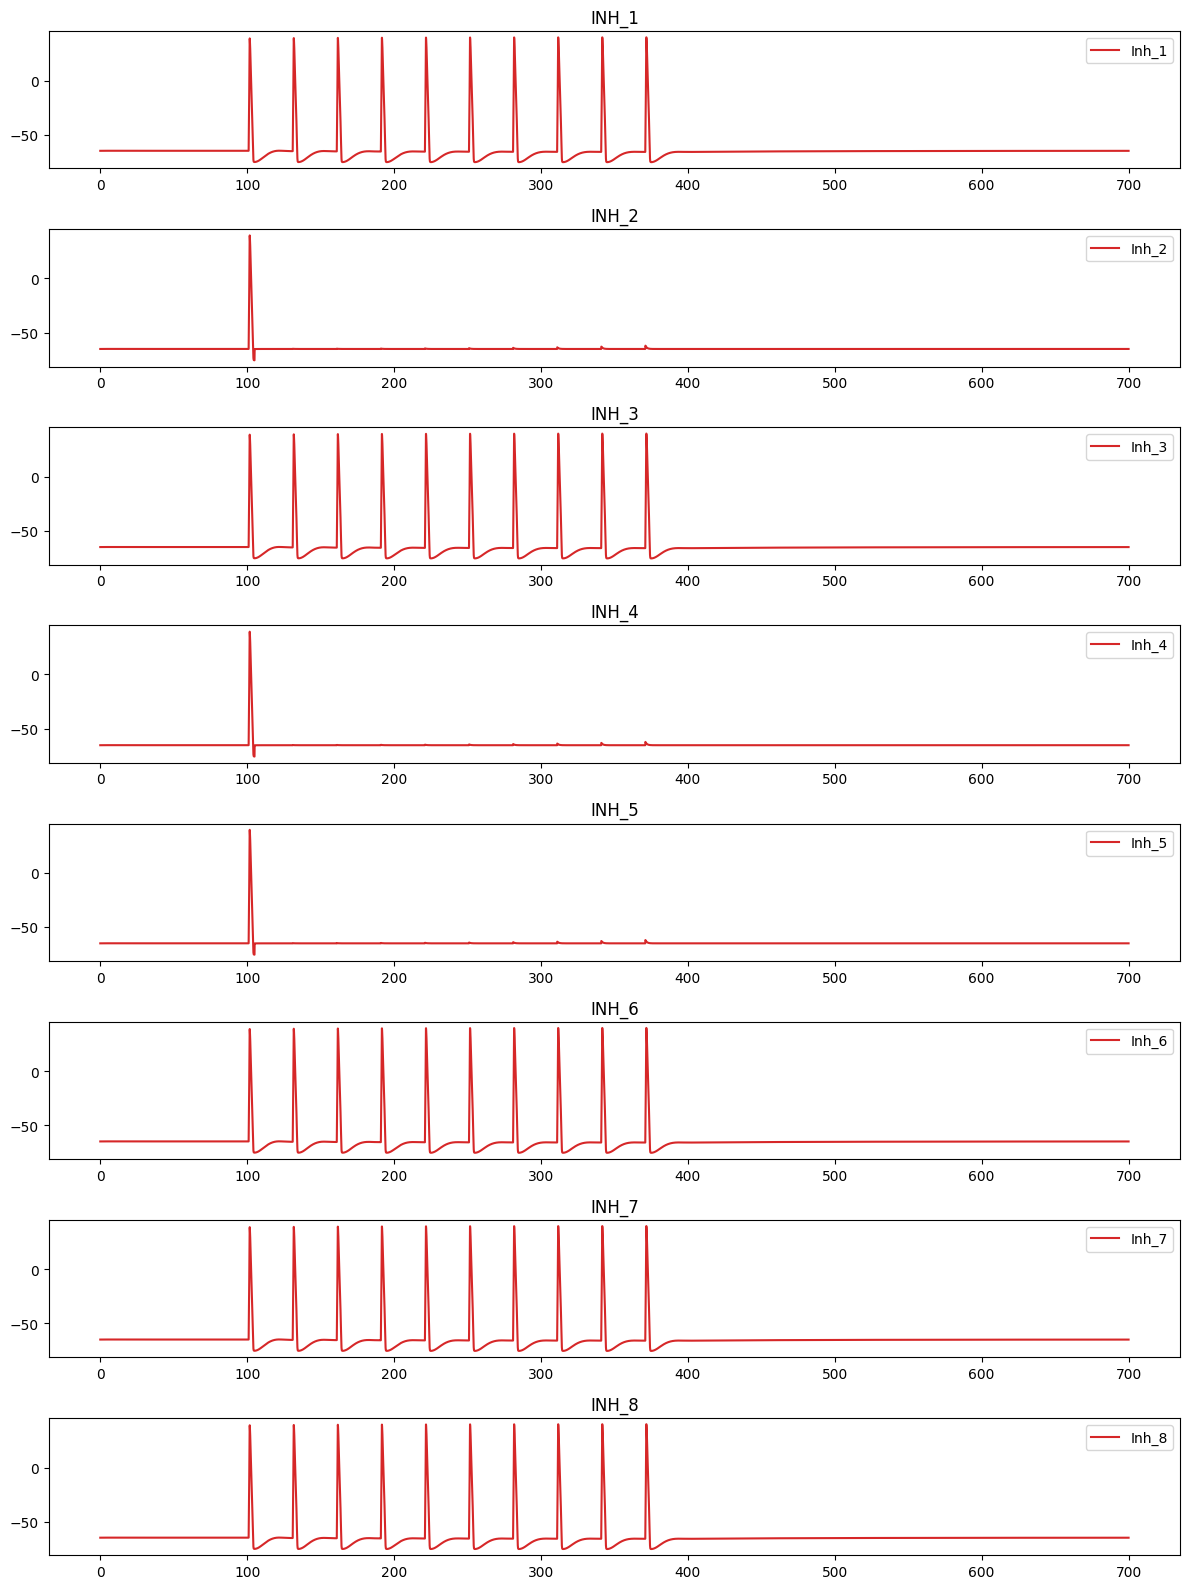

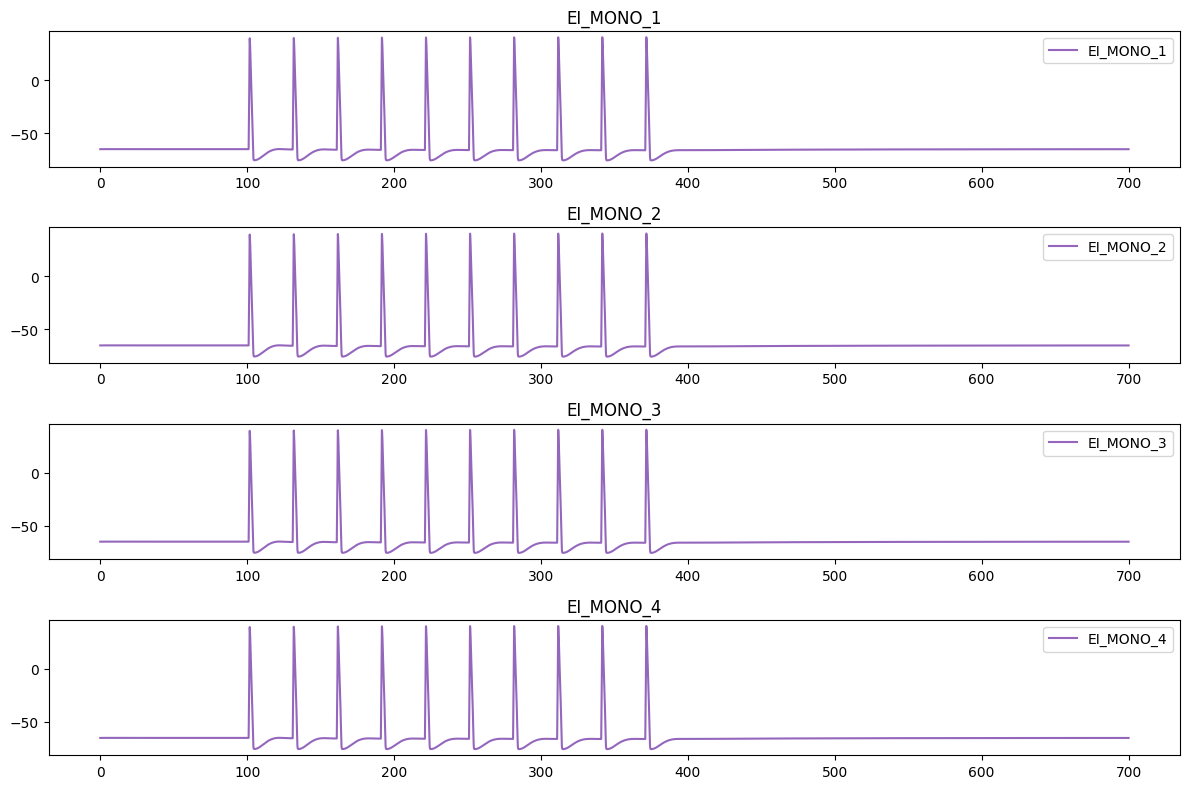

NPAX6_1 spikes: 10 times [101.17500000011444, 131.17500000011762, 161.17500000009034, 191.17500000006305, 221.17500000003577, 251.17500000000848, 281.1749999999812, 311.1749999999539, 341.1749999999266, 371.17499999989934]
NPAX6_2 spikes: 10 times [101.17500000011444, 131.17500000011762, 161.17500000009034, 191.17500000006305, 221.17500000003577, 251.17500000000848, 281.1749999999812, 311.1749999999539, 341.1749999999266, 371.17499999989934]
NPAX6_3 spikes: 10 times [101.17500000011444, 131.17500000011762, 161.17500000009034, 191.17500000006305, 221.17500000003577, 251.17500000000848, 281.1749999999812, 311.1749999999539, 341.1749999999266, 371.17499999989934]
NPAX6_4 spikes: 10 times [101.17500000011444, 131.17500000011762, 161.17500000009034, 191.17500000006305, 221.17500000003577, 251.17500000000848, 281.1749999999812, 311.1749999999539, 341.1749999999266, 371.17499999989934]
Disyn isyn_inh entries: [28001]
Mono isyn_inh entries: [0, 0, 0, 0]
EI_MONO_1 inhibitory vectors: [0, 0, 0, 

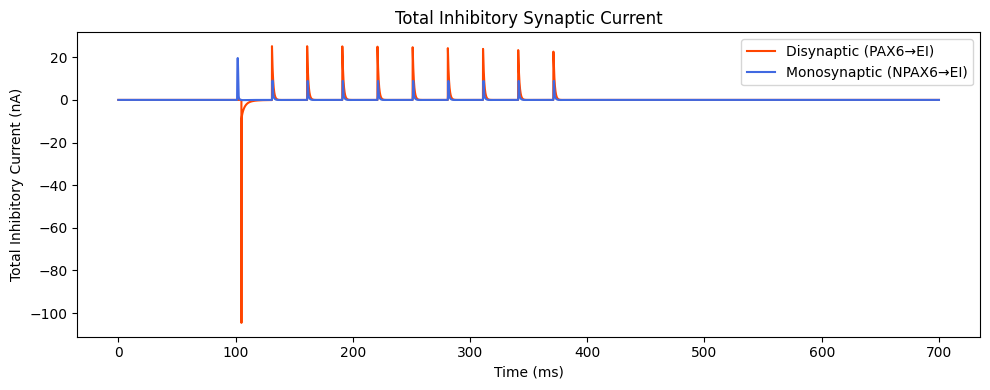

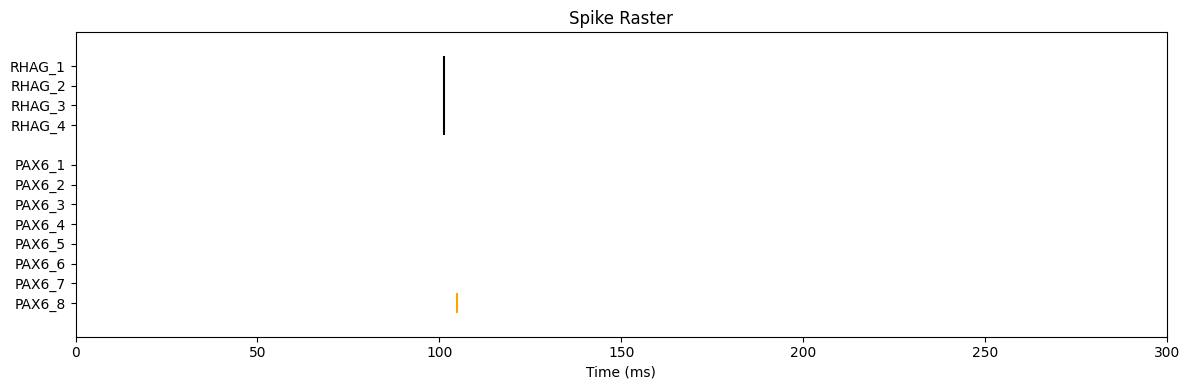

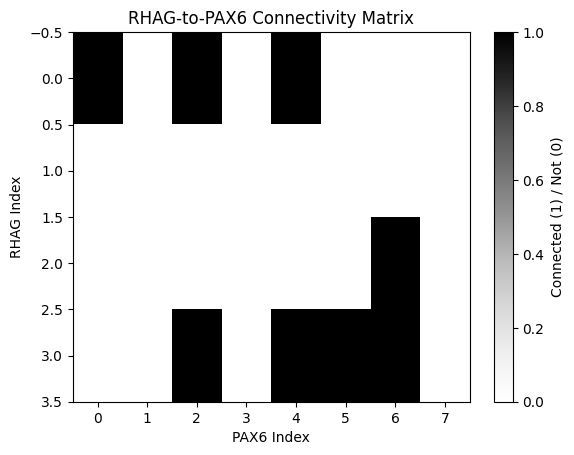

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
v = h.VecStim()


h.load_file("stdrun.hoc")

class HHNeuron:
    def __init__(self, name, adapt_gmax=0.0005, adapt_tau=100, soma_L=30, soma_diam=30):
        self.soma = h.Section(name=name)
        self.soma.L = soma_L
        self.soma.diam = soma_diam
        self.soma.Ra = 100
        self.soma.cm = 1
        self.soma.insert('hh')
        for seg in self.soma:
            seg.hh.gnabar = 0.12
            seg.hh.gkbar = 0.036
            seg.hh.gl = 0.0003
            seg.hh.el = -54.3

        self.adapt = h.Adapt(self.soma(0.5))
        self.adapt.gmax = adapt_gmax
        self.adapt.tau = adapt_tau

        self.v = h.Vector().record(self.soma(0.5)._ref_v)
        self.ina = h.Vector().record(self.soma(0.5)._ref_ina)
        self.ik = h.Vector().record(self.soma(0.5)._ref_ik)
        self.iadapt = h.Vector().record(self.adapt._ref_iadapt)
        self.m = h.Vector().record(self.soma(0.5).hh._ref_m)
        self.h_gate = h.Vector().record(self.soma(0.5).hh._ref_h)
        self.n = h.Vector().record(self.soma(0.5).hh._ref_n)
        self.spikes = h.Vector()
        self.nc = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.nc.threshold = -20
        self.nc.record(self.spikes)
        self.nc_adapt = h.NetCon(self.soma(0.5)._ref_v, self.adapt, sec=self.soma)
        self.nc_adapt.threshold = -20
        self.nc_adapt.weight[0] = 1
    
    def connect_to(self, target_syn, weight=0.1, delay=0.1):
        nc = h.NetCon(self.soma(0.5)._ref_v, target_syn, sec=self.soma)
        nc.weight[0] = weight
        nc.delay = delay
        nc.threshold = -20
        return nc


class DetonatorInput:
    def __init__(self, target_sec, tau=1, e=0, start=100, weight=0.1):
        self.syn = h.ExpSyn(target_sec(0.5))
        self.syn.e = e
        self.syn.tau = tau

        self.stim = h.NetStim()
        self.stim.start = start
        self.stim.number = 1
        self.stim.interval = 1

        self.nc = h.NetCon(self.stim, self.syn)
        self.nc.weight[0] = weight
        self.isyn = h.Vector().record(self.syn._ref_i)

class RHAGNeuron(HHNeuron):
    def __init__(self):
        super().__init__(name='rhag', adapt_gmax=0.0005, adapt_tau=100)
        self.input = DetonatorInput(self.soma, tau=1, start=100, weight = 0.1)
        self.isyn = self.input.isyn

class PAX6Neuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'pax6_{idx+1}', adapt_gmax=0.0005, adapt_tau=100)
        self.syn = h.ExpSyn(self.soma(0.5))
        self.syn.e = 0
        self.syn.tau = 1
        self.isyn = h.Vector().record(self.syn._ref_i)

class NRHAGNeuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'nrhag_{idx+1}', adapt_tau=90)
        self.input = DetonatorInput(self.soma, tau=1, start=100, weight=0.1)
        self.isyn = self.input.isyn

class ExcNeuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'exc_{idx+1}')
        # Optionally: different channel properties for excitatory neurons

class InhNeuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'inh_{idx+1}')
        # Optionally: different channel properties for inhibitory neurons


#NETWORK CONSTRUCTION

num_rhag = 4
num_pax6 = 8  # Choose >=4 for more realistic overlaps; can be 4 to match your example
num_nrhag = 23  # or whatever number you want!
num_ex = 8  # or more; as desired
num_in = 8

w_mono_inhib = 1.0  # baseline weight for monosynaptic inhibition
w_disyn_inhib = 3.5 * w_mono_inhib  # 3.5 times stronger for disynaptic inhibition


# Create neuron populations
rhag_cells = [RHAGNeuron() for _ in range(num_rhag)]
nrhag_cells = [NRHAGNeuron(i) for i in range(num_nrhag)]
pax6_cells = [PAX6Neuron(idx) for idx in range(num_pax6)]
exc_neurons = [ExcNeuron(i) for i in range(num_ex)]
inh_neurons = [InhNeuron(i) for i in range(num_in)]
# -----------------------------------------------------------
# Monosynaptic inhibition: NPAX6 → EI_MONO neurons
# -----------------------------------------------------------

# Parameters
num_ei_mono = 4          # number of EI target neurons (for monosynaptic input)
num_npax6 = 4            # number of NPAX6 inhibitory source neurons
w_mono_inhib = 1.0       # baseline inhibitory weight (disynaptic will be 3.5× stronger)

# Define NPAX6 inhibitory neurons
npax6_neurons = [InhNeuron(i) for i in range(num_npax6)]

# Define a *separate* EI population for monosynaptic inhibition targets
ei_mono_neurons = [HHNeuron(name=f'ei_mono_{i+1}') for i in range(num_ei_mono)]

# Give NPAX6 neurons an input (so they spike)
for neuron in npax6_neurons:
    neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
    neuron.input.stim.number = 10
    neuron.input.stim.interval = 30

for neuron in ei_mono_neurons:
    neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
    neuron.input.stim.number = 10
    neuron.input.stim.interval = 30

# Set up monosynaptic inhibitory connections NPAX6 → EI_MONO
mono_syn_netcons = []

for npax6 in npax6_neurons:
    for target in ei_mono_neurons:
        inh_syn = h.Exp2Syn(target.soma(0.5))
        inh_syn.e = -65      # inhibitory reversal potential
        inh_syn.tau1 = 0.5
        inh_syn.tau2 = 10.0

        nc = h.NetCon(npax6.soma(0.5)._ref_v, inh_syn, sec=npax6.soma)
        nc.threshold = -40
        nc.delay = 0.1
        nc.weight[0] = w_mono_inhib   # baseline inhibitory weight

        mono_syn_netcons.append(nc)

        # Record inhibitory synaptic current onto target
        if not hasattr(target, 'isyn_inh'):
            target.isyn_inh = []
        target.isyn_inh.append(h.Vector().record(inh_syn._ref_i))


rng = np.random.default_rng()
nearest_pax6 = [rng.choice(num_pax6, size=4, replace=False) for _ in range(num_rhag)]
nearest_pax6_nrhag = [rng.choice(num_pax6, size=4, replace=False) for _ in range(num_nrhag)]
# Anatomical connection and transmission unreliability (VecStim relay method)

p_proj = 20 / 43  # connection probability
p_transmit = 0.91 # per-spike transmission probability

p_proj_nrhag = 5 / 37         # 0.135 connectivity probability
p_transmit_nrhag = 0.2        # Biologically, rarely transmit spikes


nrhag_connections = []
all_nrhag_relay_netcons = []

connections = []
all_relay_netcons = []

connections_ei = []  # keep references!
ei_syns = []

# For each PAX6 neuron, select a random set of excitatory and inhibitory neurons to target
ei_targets = []


# First simulate RHAGs to get their spike times
h.finitialize(-65)
h.continuerun(700)
spikes_rhag = [np.array(list(r.spikes)) for r in rhag_cells]

# Simulate NRHAGs separately to get their spike times
nrhag_spikes = []
for n in nrhag_cells:
    h.finitialize(-65)
    h.continuerun(700)
    nrhag_spikes.append(np.array(list(n.spikes)))


# Now, for each established connection: relay only 91% of spikes from RHAG to PAX6 using VecStim
for rhag_idx, rhag in enumerate(rhag_cells):
    for pax6_idx in nearest_pax6[rhag_idx]:
        if rng.uniform() < p_proj:
            # Only use 91% of presynaptic spikes for actual transmission
            relayed_spikes = [t+1.0 for t in spikes_rhag[rhag_idx] if rng.uniform() < p_transmit]  # 1ms delay
            if relayed_spikes:
                relay_vec = h.Vector(relayed_spikes)
                relay_stim = h.VecStim()
                relay_stim.play(relay_vec)
                nc = h.NetCon(relay_stim, pax6_cells[pax6_idx].syn)
                nc.weight[0] = 0.1
                all_relay_netcons.append(nc)  # Keep refs alive!
            connections.append((rhag_idx, pax6_idx, 0.1))
        else:
            connections.append((rhag_idx, pax6_idx, 0.0))

# NRHAG -> PAX6 VecStim relay
for nrhag_idx, nrhag in enumerate(nrhag_cells):
    for pax6_idx in nearest_pax6_nrhag[nrhag_idx]:
        if rng.uniform() < p_proj_nrhag:
            relayed_spikes = [t+1.0 for t in nrhag_spikes[nrhag_idx] if rng.uniform() < p_transmit_nrhag]
            if relayed_spikes:
                relay_vec = h.Vector(relayed_spikes)
                relay_stim = h.VecStim()
                relay_stim.play(relay_vec)
                nc = h.NetCon(relay_stim, pax6_cells[pax6_idx].syn)
                nc.weight[0] = 0.01      # <<--- USE SMALLER VALUE HERE!
                all_nrhag_relay_netcons.append(nc)
            nrhag_connections.append((nrhag_idx, pax6_idx, 0.01))
        else:
            nrhag_connections.append((nrhag_idx, pax6_idx, 0.0))

# Give PAX6 an earlier start (e.g., 90 ms), make EI input later (e.g., >=110 ms)
#for neuron in exc_neurons + inh_neurons:
    #neuron.input = DetonatorInput(neuron.soma, tau=1, start=120, weight=0.1)  # Fires after PAX6


# map EI index -> list of inhibitory NetCons it receives
ei_netcons_by_target = {i: [] for i in range(num_ex + num_in)}
ei_targets = []

# Inhibition parameters

inh_reversal = -65
inh_tau1 = 0.5      # keep fast rise
inh_tau2 = 80.0     # much longer decay -> suppresses across multiple input spikes
inh_delay  = 0.1    # nearly immediate arrival after PAX6 spike


for pax6_idx, pax6 in enumerate(pax6_cells):
    targets = rng.choice(num_ex + num_in, size=4, replace=False)
    ei_targets.append(targets)
    for idx in targets:
        if idx < num_ex:
            target = exc_neurons[idx]
        else:
            target = inh_neurons[idx - num_ex]

        inh_syn = h.Exp2Syn(target.soma(0.5))
        inh_syn.e = inh_reversal
        inh_syn.tau1 = inh_tau1
        inh_syn.tau2 = inh_tau2

        netcon = h.NetCon(pax6.soma(0.5)._ref_v, inh_syn, sec=pax6.soma)
        netcon.threshold = -20
        netcon.delay = inh_delay
        netcon.weight[0] = w_disyn_inhib

        ei_netcons_by_target[idx].append(netcon)
        ei_syns.append(inh_syn)

        # --- FIX: record from all targets ---
        if not hasattr(target, 'isyn_inh'):
            target.isyn_inh = []
        target.isyn_inh.append(h.Vector().record(inh_syn._ref_i))




# Collect indices of all EI neurons targeted for silencing by any PAX6
silenced_indices = set()
for targets in ei_targets:
    silenced_indices.update(targets)

for neuron in exc_neurons + inh_neurons:
    # 10 spikes at intervals of 30 ms starting at 100 ms
    neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
    neuron.input.stim.number = 10
    neuron.input.stim.interval = 30


# Assign DetonatorInput ONLY to EI neurons NOT in silenced_indices
#for i, neuron in enumerate(exc_neurons + inh_neurons):
#    if i not in silenced_indices:
#        neuron.input = DetonatorInput(neuron.soma, tau=1, start=120, weight=0.1)
    # No input for silenced neurons means they remain silent (flat)



# Initialize t vector just once
t = h.Vector().record(h._ref_t)


#SIMULATION

# Assign DetonatorInput for multiple spikes ONLY to non-silenced EI neurons
# First, determine the indices to silence by running a quick simulation

# Assign input to all by default
for neuron in exc_neurons + inh_neurons:
    neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
    neuron.input.stim.number = 10
    neuron.input.stim.interval = 30



# SIMULATE
h.finitialize(-65)
h.continuerun(700)

# Find triggered PAX6 (those that spike)
def vnp(v): return np.array(list(v))
def arrlst(lst): return [np.array(list(x)) for x in lst]
spikes_pax6_np = arrlst([p.spikes for p in pax6_cells])
triggered_pax6_indices = [idx for idx, s in enumerate(spikes_pax6_np) if len(s) > 0]
silenced_indices = set()
for idx in triggered_pax6_indices:
    silenced_indices.update(ei_targets[idx])

w_silence = 50.0  # Or tune as needed
for ei_idx, netcons in ei_netcons_by_target.items():
    for nc in netcons:
        if ei_idx in silenced_indices:
            nc.weight[0] = w_silence   # strengthen inhibition when PAX6 spikes
        else:
            nc.weight[0] = w_disyn_inhib


# Assign input ONLY to non-silenced indices (overwrite previous input for silenced ones)
#for i, neuron in enumerate(exc_neurons + inh_neurons):
#    if i in silenced_indices:
#        neuron.input.stim.number = 0  # disables all presynaptic spikes for the NetStim
#    else:
#        neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
#        neuron.input.stim.number = 10
#        neuron.input.stim.interval = 30

# SIMULATE again for final output!
h.finitialize(-65)
h.continuerun(700)


#DATA EXTRACTION

# Convert t only once
t_np = np.array(list(t))

v_rhag = [vnp(r.v) for r in rhag_cells]
ina_rhag = [vnp(r.ina) for r in rhag_cells]
ik_rhag = [vnp(r.ik) for r in rhag_cells]
iadapt_rhag = [vnp(r.iadapt) for r in rhag_cells]
isyn_rhag = [vnp(r.isyn) for r in rhag_cells]
spikes_rhag = [vnp(r.spikes) for r in rhag_cells]

v_pax6 = [vnp(p.v) for p in pax6_cells]

isyn_pax6_np = arrlst([p.isyn for p in pax6_cells])
iadapt_pax6_np = arrlst([p.iadapt for p in pax6_cells])
# Data extraction for NRHAG
v_nrhag = [vnp(n.v) for n in nrhag_cells]
ina_nrhag = [vnp(n.ina) for n in nrhag_cells]
ik_nrhag = [vnp(n.ik) for n in nrhag_cells]
iadapt_nrhag = [vnp(n.iadapt) for n in nrhag_cells]
spikes_nrhag = [vnp(n.spikes) for n in nrhag_cells]



#PLOTTING

plt.figure(figsize=(12, 2 * num_rhag))
for i, v in enumerate(v_rhag):
    plt.subplot(num_rhag, 1, i + 1)
    plt.plot(t_np, v, label=f'RHAG_{i+1}', color='k')
    plt.ylabel('V_m (mV)')
    plt.title(f'Membrane Potential: RHAG_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

# Plot NRHAG membrane potentials
plt.figure(figsize=(12, 2 * num_nrhag))
for i, v in enumerate(v_nrhag):
    plt.subplot(num_nrhag, 1, i + 1)
    plt.plot(t_np, v, label=f'NRHAG_{i+1}', color='b')
    plt.ylabel('V_m (mV)')
    plt.title(f'Membrane Potential: NRHAG_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 2 * num_pax6))
for i, v in enumerate(v_pax6):
    plt.subplot(num_pax6, 1, i + 1)
    plt.plot(t_np, v, label=f'PAX6_{i+1}', color=['r','g','b','m','c','y','k','orange'][i % 8])
    plt.ylabel('V_m (mV)')
    plt.title(f'Membrane Potential: PAX6_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()


# Synaptic currents for each PAX6 neuron
plt.figure(figsize=(12, 2 * num_pax6))
import itertools
colors = itertools.cycle(['r', 'g', 'b', 'm', 'c', 'y', 'k', 'orange'])
for idx, isyn in enumerate(isyn_pax6_np):
    plt.subplot(num_pax6, 1, idx + 1)
    plt.plot(t_np, isyn, color=next(colors), label=f'PAX6_{idx + 1} syn current')
    plt.ylabel('I_syn (nA)')
    plt.legend()
    plt.title(f'Synaptic Current into PAX6_{idx + 1}')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2 * (num_rhag + num_pax6)))
for i, ia in enumerate(iadapt_rhag):
    plt.subplot(num_rhag + num_pax6, 1, i + 1)
    plt.plot(t_np, ia, label=f'RHAG_{i+1} Adapt', color='k')
    plt.ylabel('I_adapt')
    plt.title(f'Adaptation Current: RHAG_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
for idx, ia in enumerate(iadapt_pax6_np):
    plt.subplot(num_rhag + num_pax6, 1, num_rhag + idx + 1)
    plt.plot(t_np, ia, label=f'PAX6_{idx+1} Adapt', color=['r','g','b','m','c','y','k','orange'][idx % 8])
    plt.ylabel('I_adapt')
    plt.title(f'Adaptation Current: PAX6_{idx+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()


print(f"RHAG spikes: {len(spikes_rhag)} at times {spikes_rhag}")
print(f"NRHAG spikes: {len(spikes_nrhag)} at times {spikes_nrhag}")

for idx, s in enumerate(spikes_pax6_np):
    print(f"PAX6_{idx+1} spikes: {len(s)} at times {s}")

for rhag_idx in range(num_rhag):
    partners = [pax6_idx for (r_idx, pax6_idx, w) in connections if r_idx == rhag_idx and w > 0.0]
    print(f"RHAG_{rhag_idx+1} projects to PAX6 neurons: {partners}")
for pax6_idx in range(num_pax6):
    sources = [r_idx+1 for (r_idx, p_idx, w) in connections if p_idx==pax6_idx and w > 0.0]
    print(f"PAX6_{pax6_idx+1} receives from RHAGs: {sources}")

for nrhag_idx in range(num_nrhag):
    partners = [pax6_idx for (n_idx, pax6_idx, w) in nrhag_connections if n_idx == nrhag_idx and w > 0.0]
    print(f"NRHAG_{nrhag_idx+1} projects to PAX6 neurons: {partners}")

for pax6_idx in range(num_pax6):
    sources = [n_idx+1 for (n_idx, p_idx, w) in nrhag_connections if p_idx==pax6_idx and w > 0.0]
    print(f"PAX6_{pax6_idx+1} receives from NRHAGs: {sources}")

for idx, targets in enumerate(ei_targets):
    ei_labels = []
    for t in targets:
        if t < num_ex:
            ei_labels.append(f'E{t+1}')
        else:
            ei_labels.append(f'I{t+1-num_ex}')
    print(f'PAX6_{idx+1} targets: {ei_labels}')

# Excitatory neurons
plt.figure(figsize=(12, 2*num_ex))
for i, neuron in enumerate(exc_neurons):
    plt.subplot(num_ex, 1, i+1)
    plt.plot(t_np, vnp(neuron.v), color='tab:blue', label=f'Exc_{i+1}')
    plt.title(f"EXC_{i+1}")
    plt.legend()
plt.tight_layout()
plt.show()

# Inhibitory neurons
plt.figure(figsize=(12, 2*num_in))
for i, neuron in enumerate(inh_neurons):
    plt.subplot(num_in, 1, i+1)
    plt.plot(t_np, vnp(neuron.v), color='tab:red', label=f'Inh_{i+1}')
    plt.title(f"INH_{i+1}")
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2 * num_ei_mono))
for i, neuron in enumerate(ei_mono_neurons):
    plt.subplot(num_ei_mono, 1, i+1)
    plt.plot(t_np, vnp(neuron.v), color='tab:purple', label=f'EI_MONO_{i+1}')
    plt.title(f'EI_MONO_{i+1}')
    plt.legend()
plt.tight_layout()
plt.show()

for idx, n in enumerate(npax6_neurons):
    print(f"NPAX6_{idx+1} spikes: {len(list(n.spikes))} times {list(n.spikes)}")

#Mono vs Di synaptic inhibition
print("Disyn isyn_inh entries:", [len(vec) for vec in getattr(exc_neurons[0], 'isyn_inh', [])])
print("Mono isyn_inh entries:", [len(vec) for vec in getattr(ei_mono_neurons[0], 'isyn_inh', [])])
print("EI_MONO_1 inhibitory vectors:", [len(vec) for vec in ei_mono_neurons[0].isyn_inh])
print("t_np length:", len(t_np))

for i, n in enumerate(ei_mono_neurons):
    for j, vec in enumerate(n.isyn_inh):
        vec_np = vec.as_numpy()
        print(f"EI_MONO_{i+1} inh vec {j} length: {len(vec_np)}, sum: {np.sum(vec_np)}")

isyn_disyn = np.sum(
    [vec.as_numpy() for n in exc_neurons+inh_neurons if hasattr(n, 'isyn_inh') for vec in n.isyn_inh],
    axis=0
)
isyn_mono_list = []
for n in ei_mono_neurons:
    if hasattr(n, 'isyn_inh'):
        for vec in n.isyn_inh:
            vec_np = vec.as_numpy()
            if len(vec_np) == len(t_np):
                isyn_mono_list.append(vec_np)
            elif len(vec_np) == 0:
                isyn_mono_list.append(np.zeros(len(t_np)))  # pad empty vectors
            else:
                # If vector is shorter, pad to match t_np
                padded = np.zeros(len(t_np))
                padded[:len(vec_np)] = vec_np
                isyn_mono_list.append(padded)

isyn_mono = np.sum(isyn_mono_list, axis=0)


minlen = min(len(t_np), len(isyn_disyn), len(isyn_mono))
plt.figure(figsize=(10, 4))
plt.plot(t_np[:minlen], isyn_disyn[:minlen], label="Disynaptic (PAX6→EI)", color='orangered')
plt.plot(t_np[:minlen], isyn_mono[:minlen],  label="Monosynaptic (NPAX6→EI)", color='royalblue')
plt.title("Total Inhibitory Synaptic Current")
plt.xlabel("Time (ms)")
plt.ylabel("Total Inhibitory Current (nA)")
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 4))
all_spikes = spikes_rhag + spikes_pax6_np
lineoffsets = list(range(num_rhag, 0, -1)) + list(range(-1, -num_pax6-1, -1))
plt.eventplot(all_spikes, lineoffsets=lineoffsets, colors=['k']*num_rhag + ['r','g','b','m','c','y','k','orange'][:num_pax6])
plt.yticks(
    list(range(num_rhag, 0, -1)) + list(range(-1, -num_pax6-1, -1)),
    [f'RHAG_{i+1}' for i in range(num_rhag)] + [f'PAX6_{i+1}' for i in range(num_pax6)]
)
plt.xlim(0, 300)
plt.xlabel('Time (ms)')
plt.title('Spike Raster')
plt.tight_layout()
plt.show()

conn_matrix = np.zeros((num_rhag, num_pax6))
for r, p, w in connections:
    if w > 0: conn_matrix[r, p] = 1
plt.imshow(conn_matrix, aspect='auto', cmap='Greys')
plt.xlabel('PAX6 Index')
plt.ylabel('RHAG Index')
plt.title('RHAG-to-PAX6 Connectivity Matrix')
plt.colorbar(label="Connected (1) / Not (0)")
plt.show()


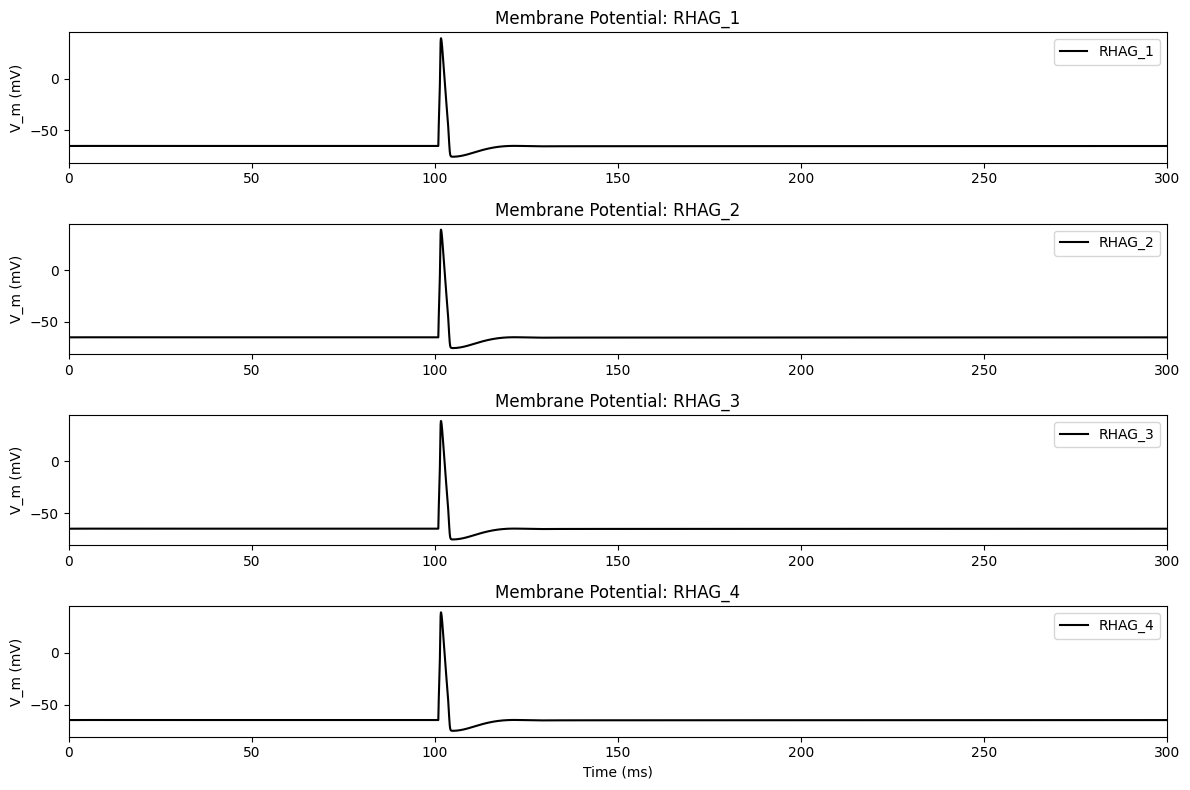

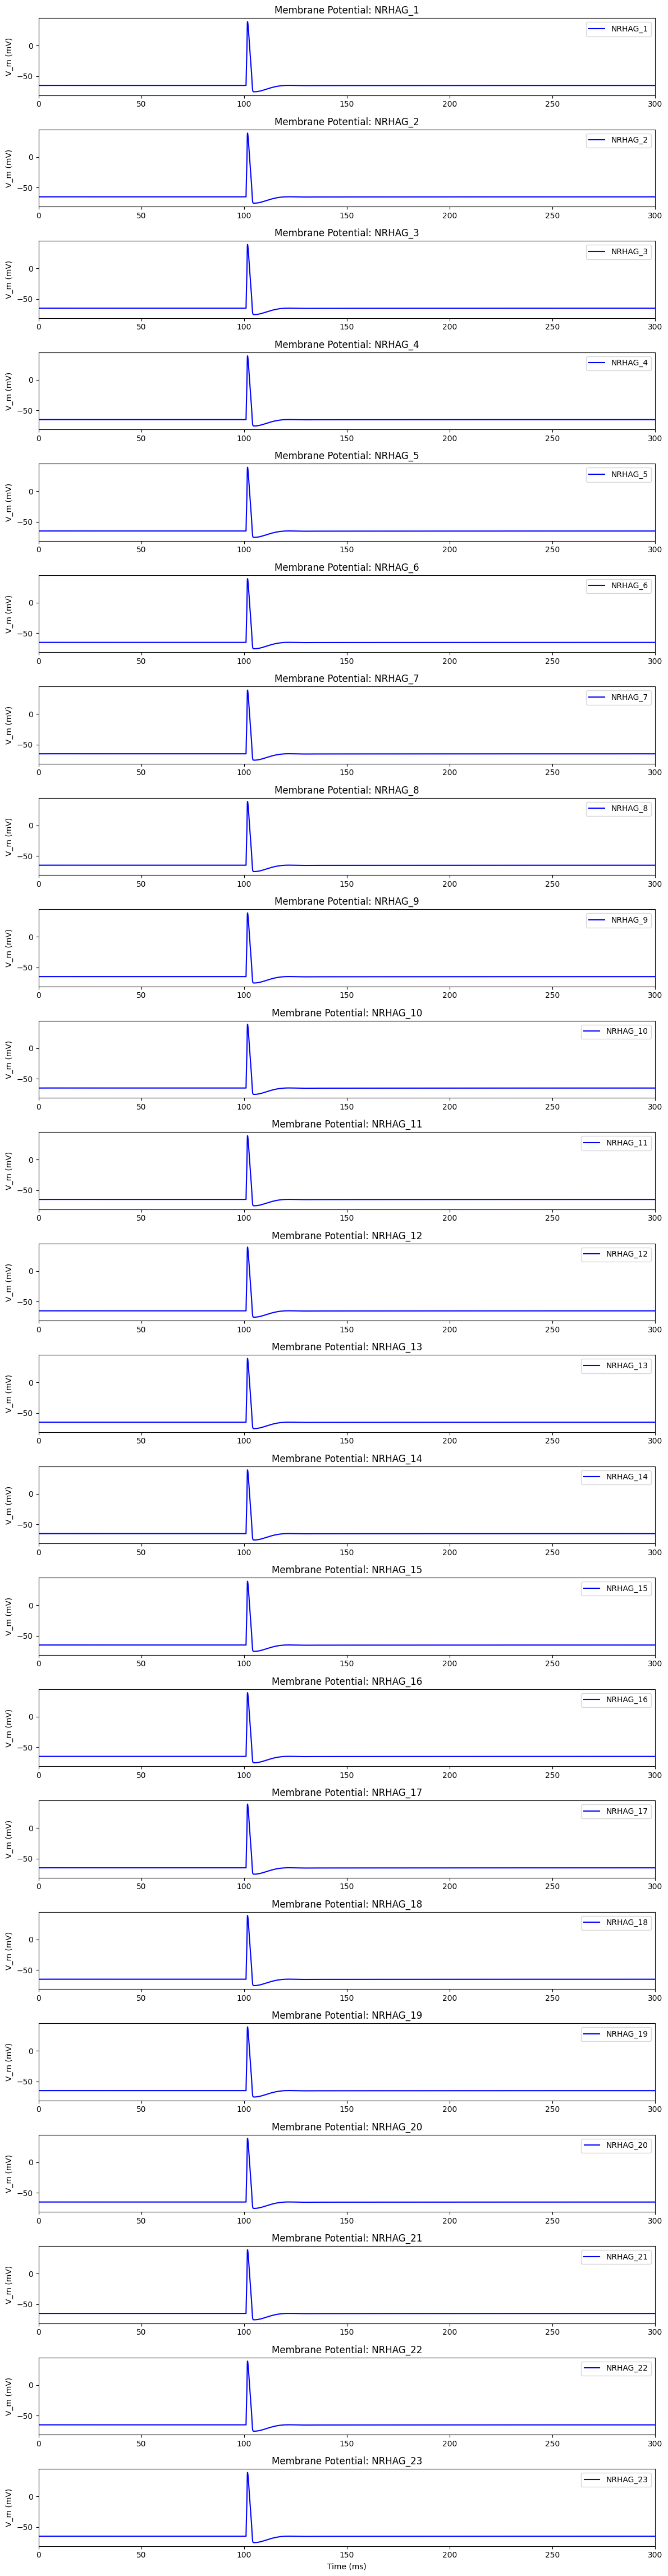

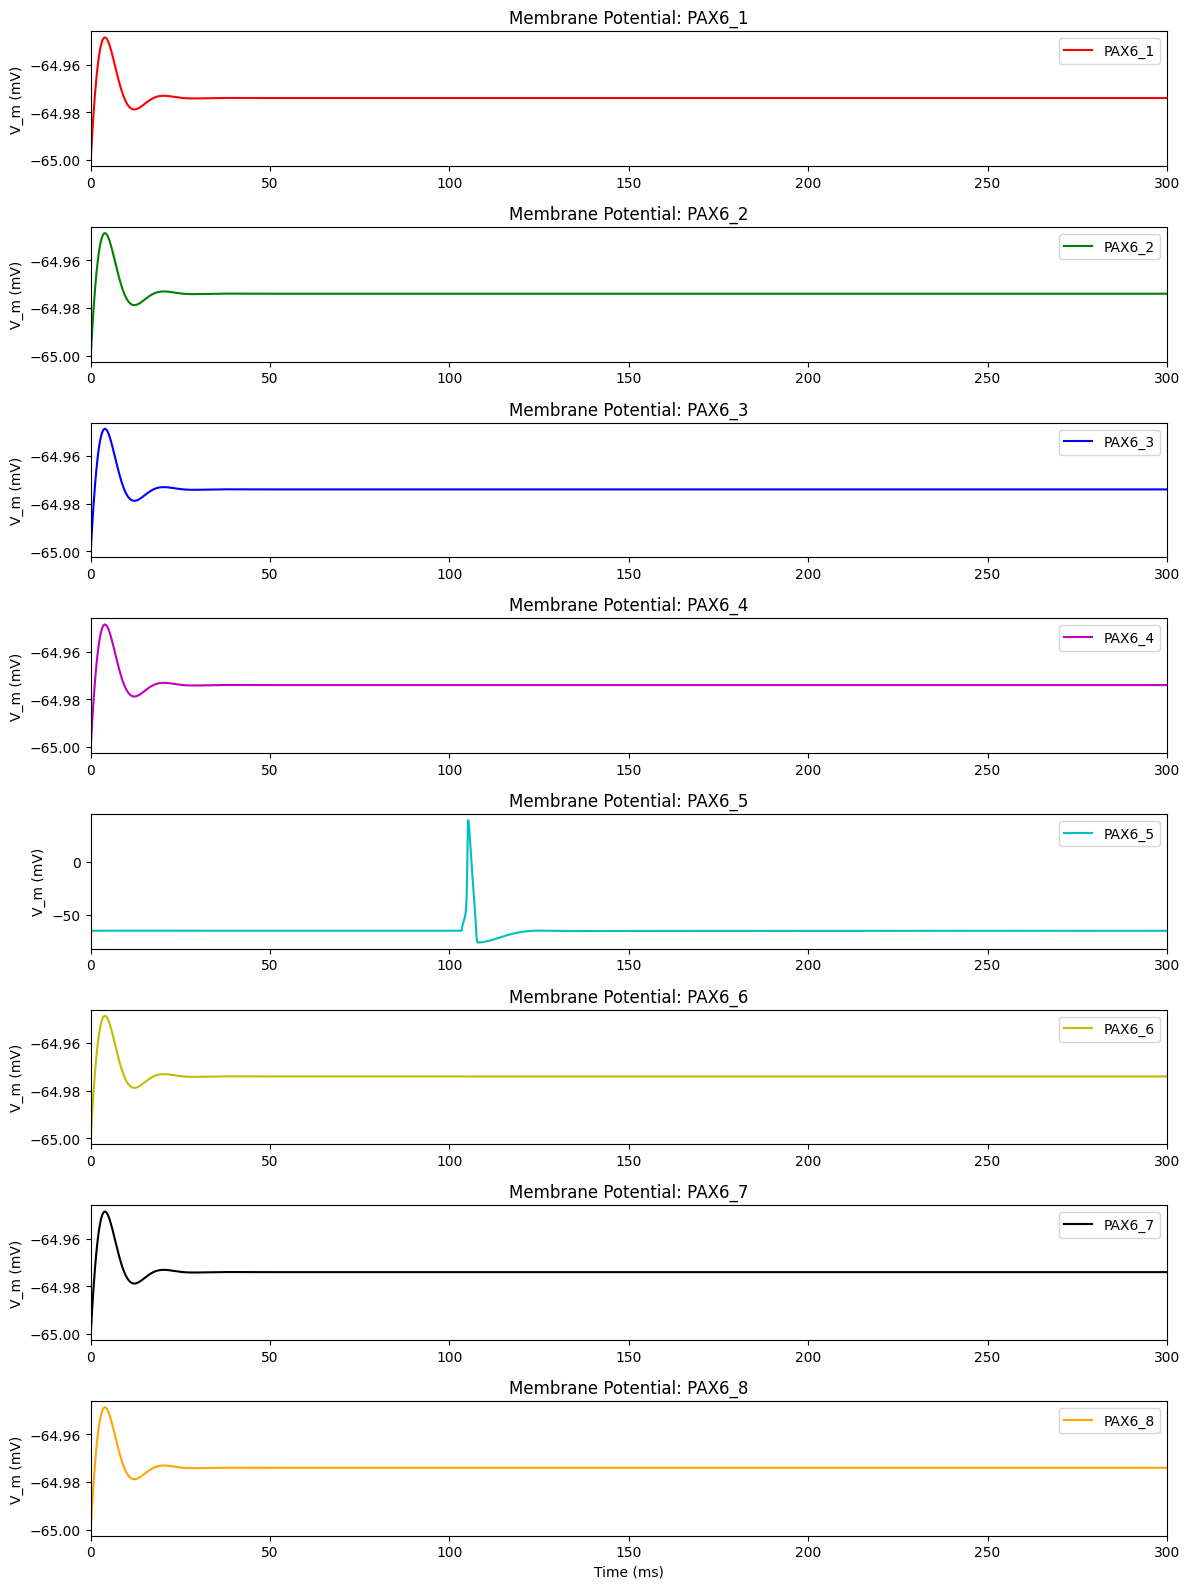

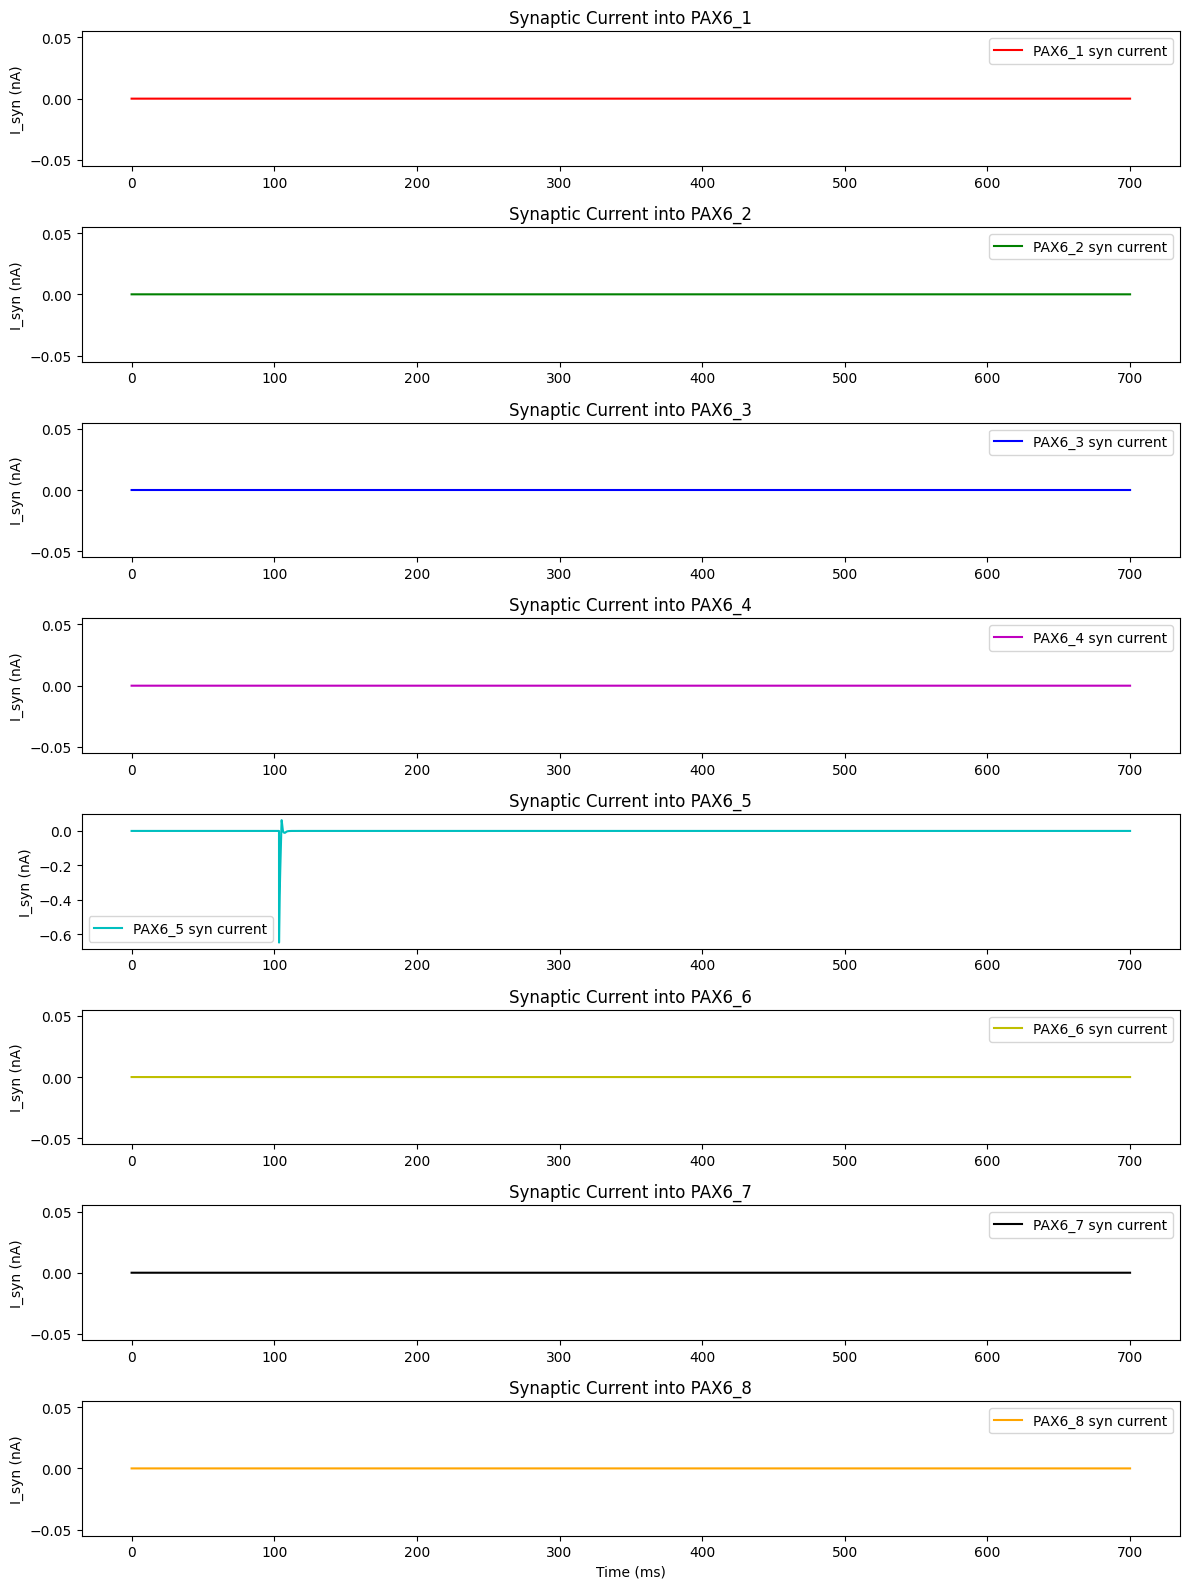

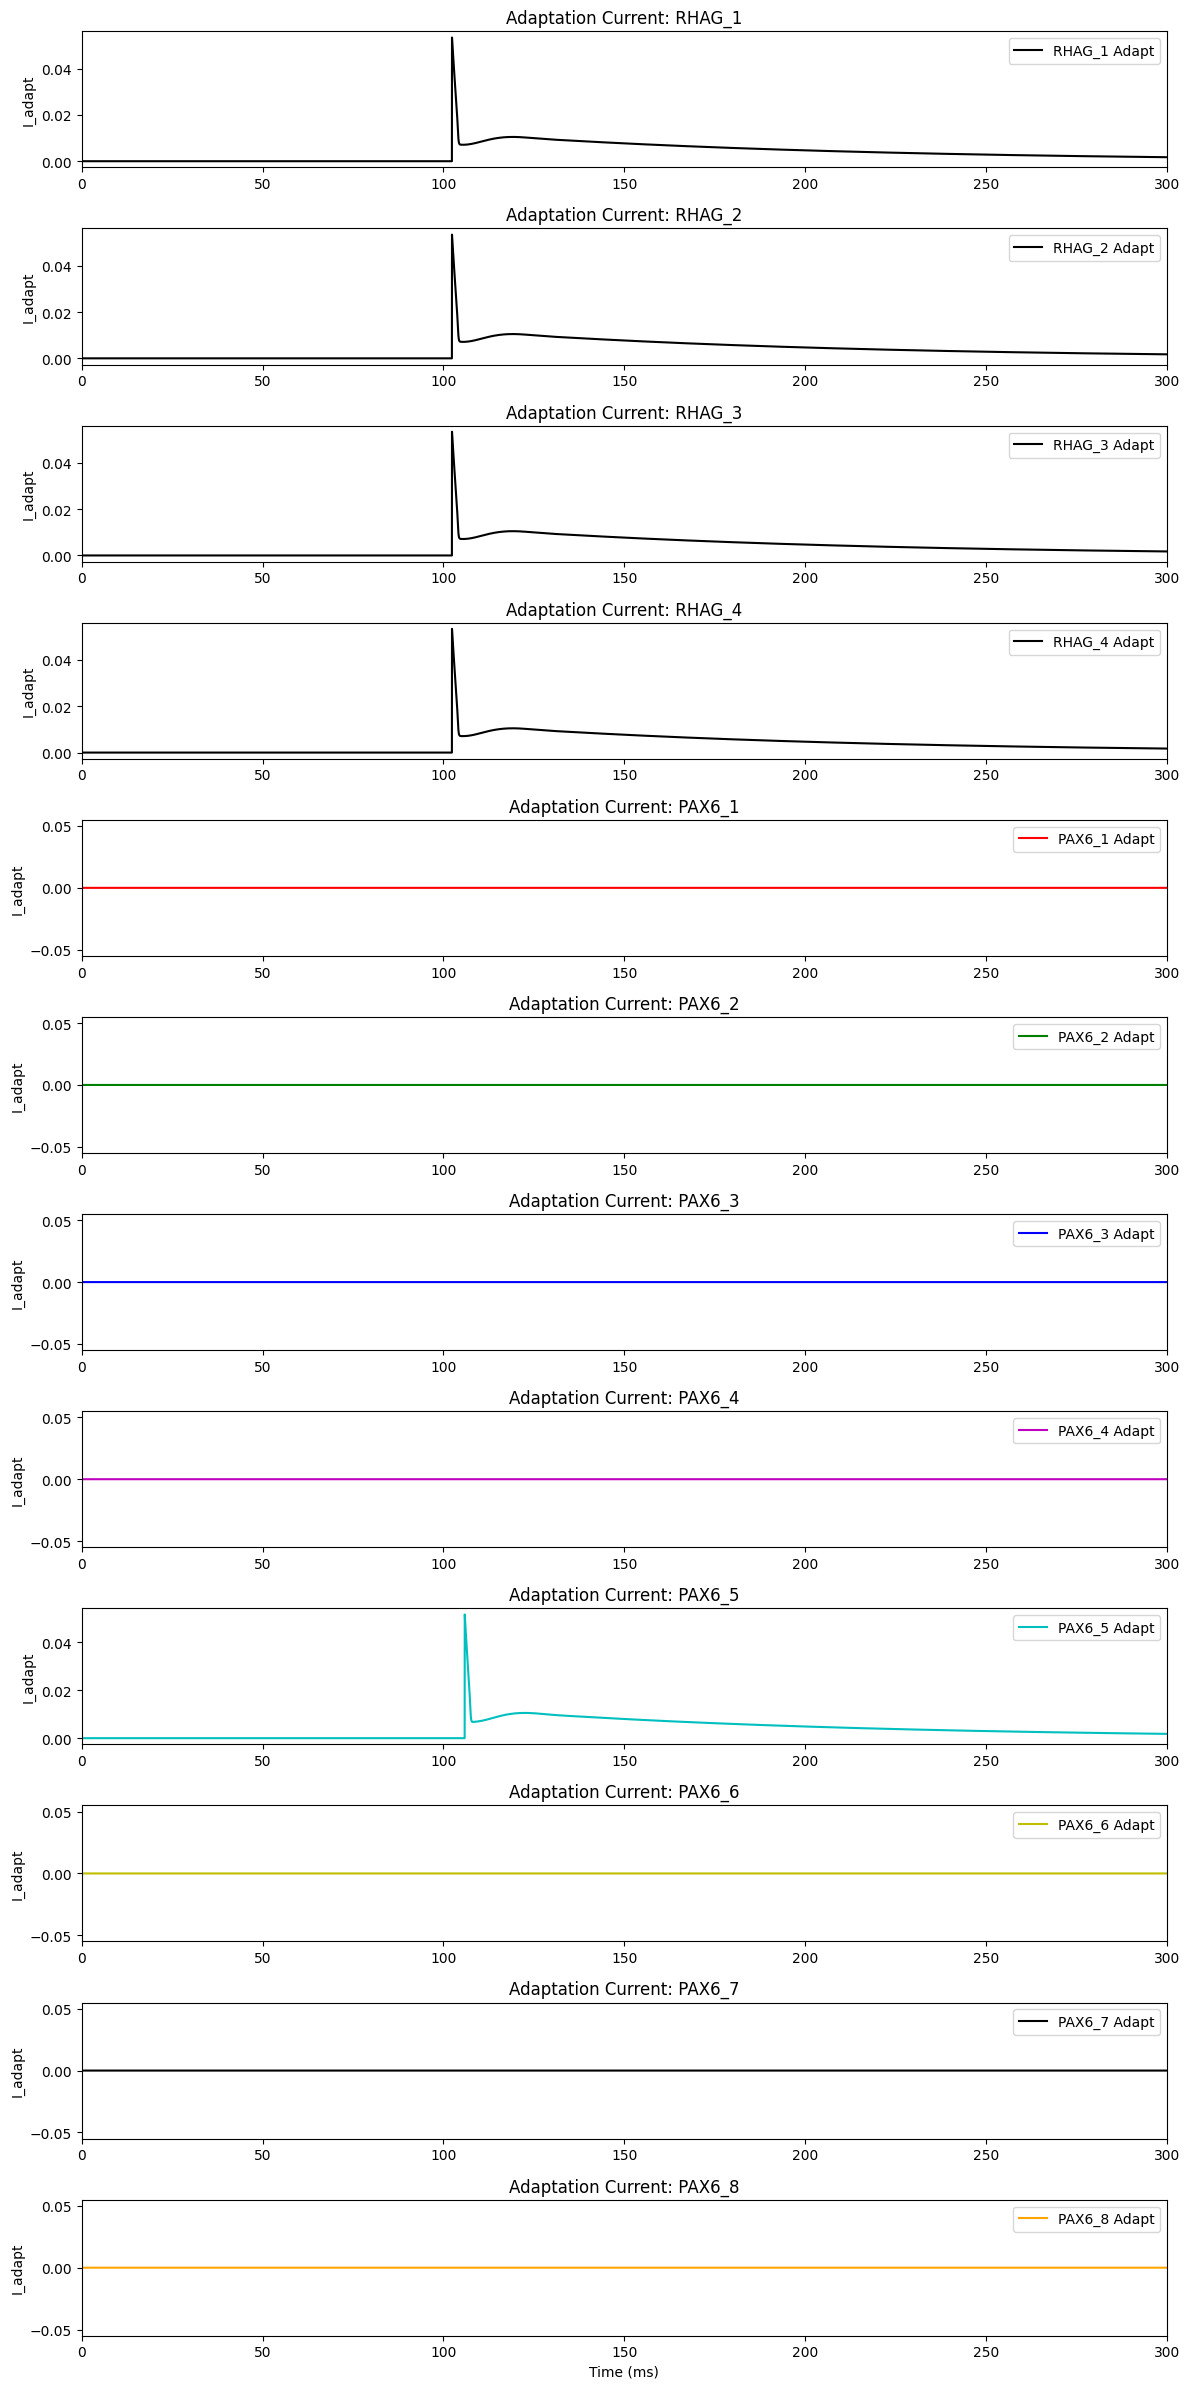

RHAG spikes: 4 at times [array([101.35]), array([101.35]), array([101.35]), array([101.35])]
NRHAG spikes: 23 at times [array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35]), array([101.35])]
PAX6_1 spikes: 0 at times []
PAX6_2 spikes: 0 at times []
PAX6_3 spikes: 0 at times []
PAX6_4 spikes: 0 at times []
PAX6_5 spikes: 1 at times [104.875]
PAX6_6 spikes: 0 at times []
PAX6_7 spikes: 0 at times []
PAX6_8 spikes: 0 at times []
RHAG_1 projects to PAX6 neurons: []
RHAG_2 projects to PAX6 neurons: [np.int64(3), np.int64(5)]
RHAG_3 projects to PAX6 neurons: [np.int64(3), np.int64(5)]
RHAG_4 projects to PAX6 neurons: [np.int64(5), np.int64(6), np.int64(0), np.int64(4)]
PAX6_1 r

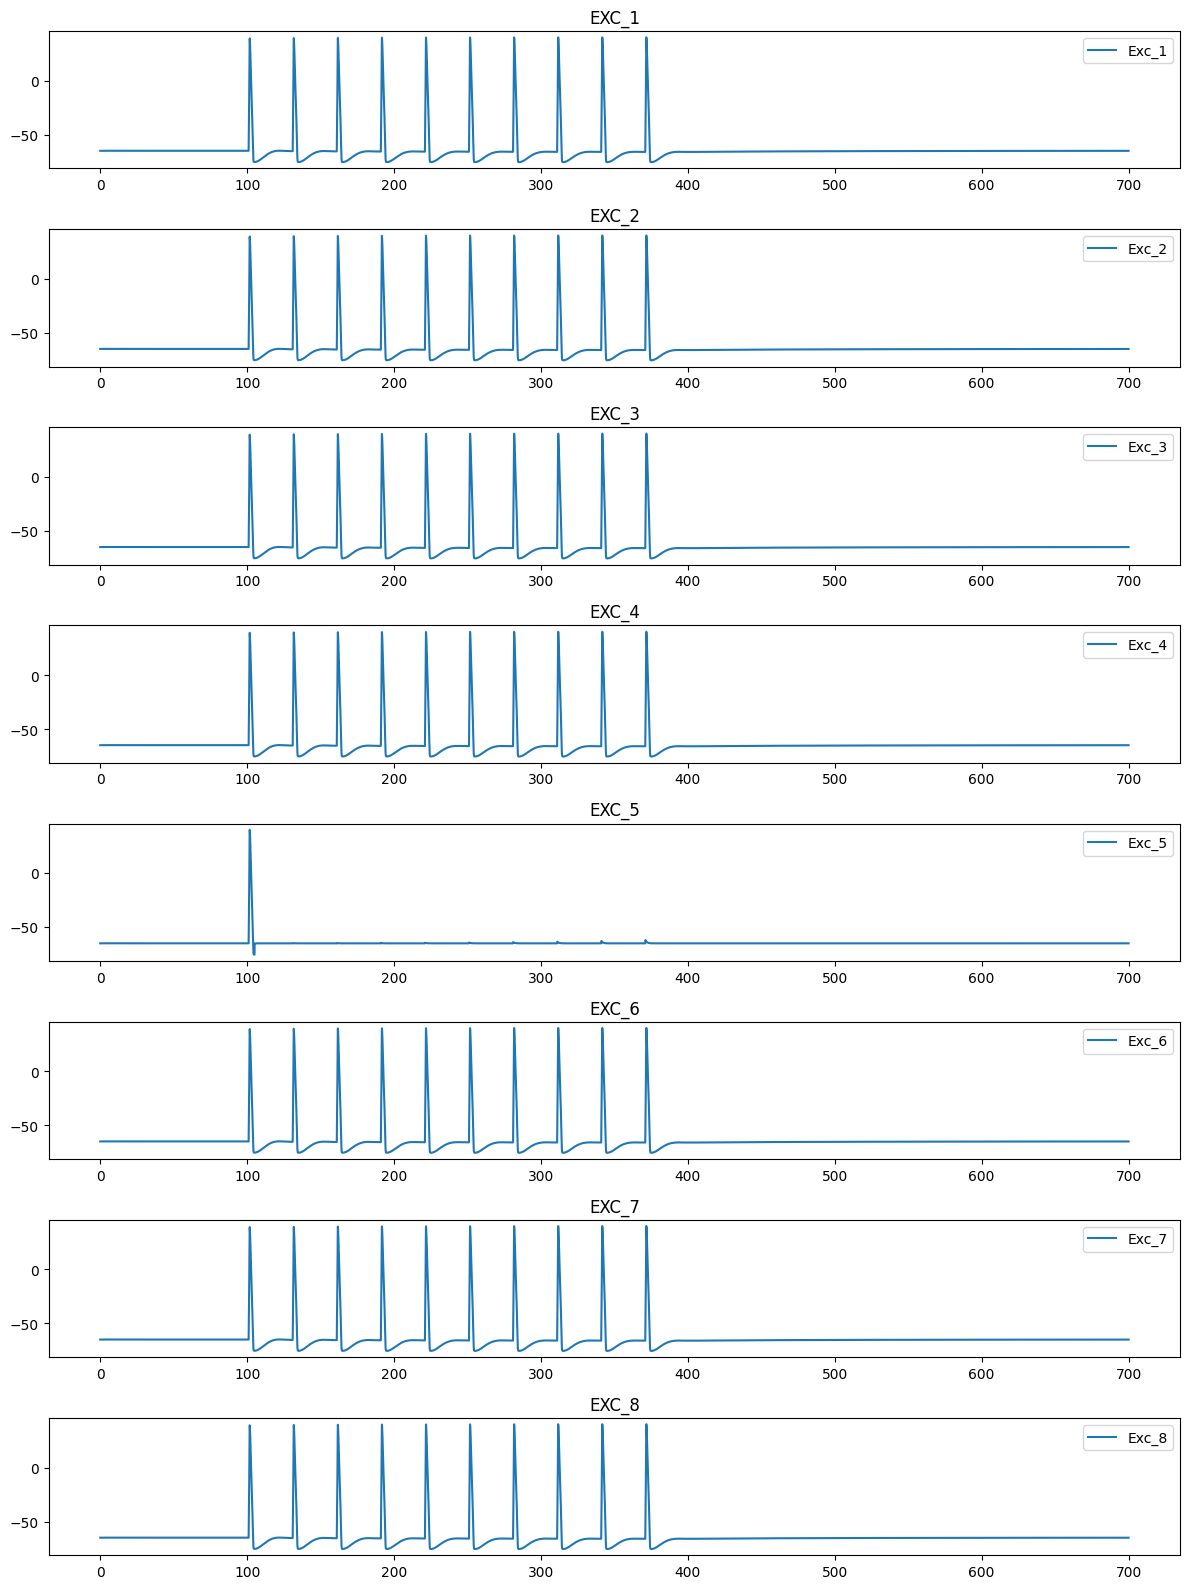

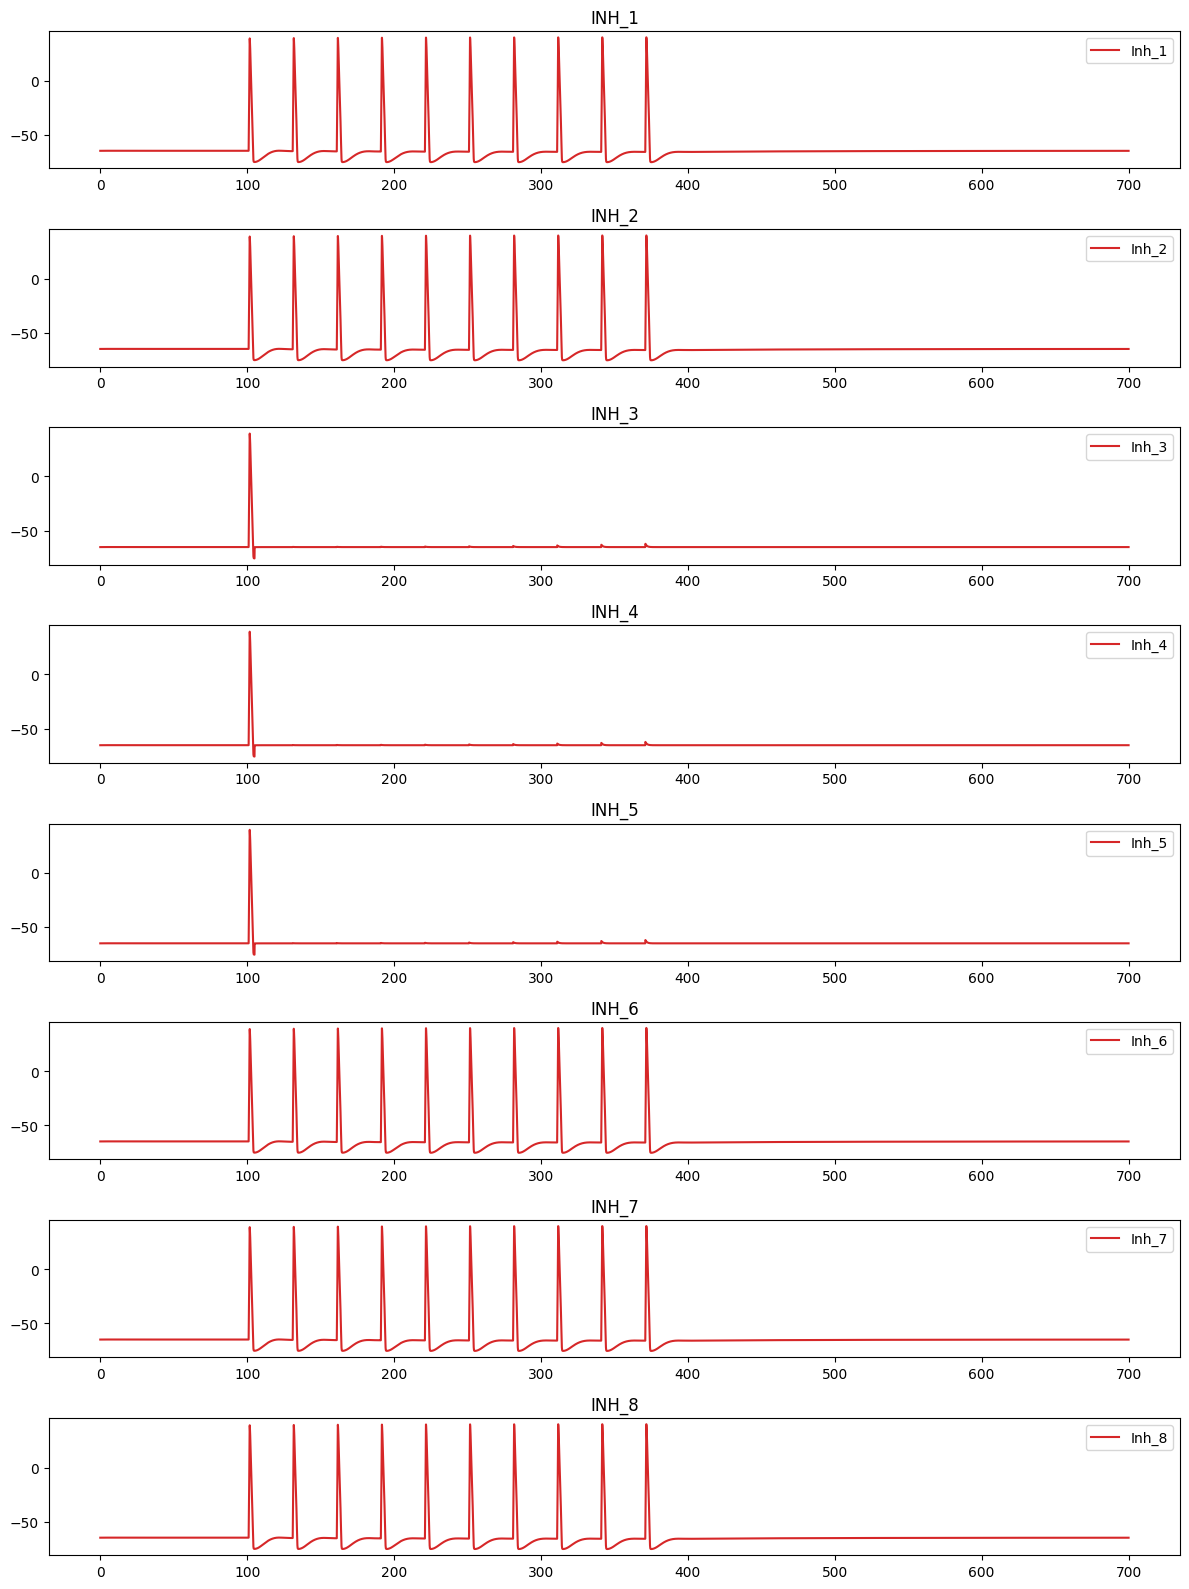

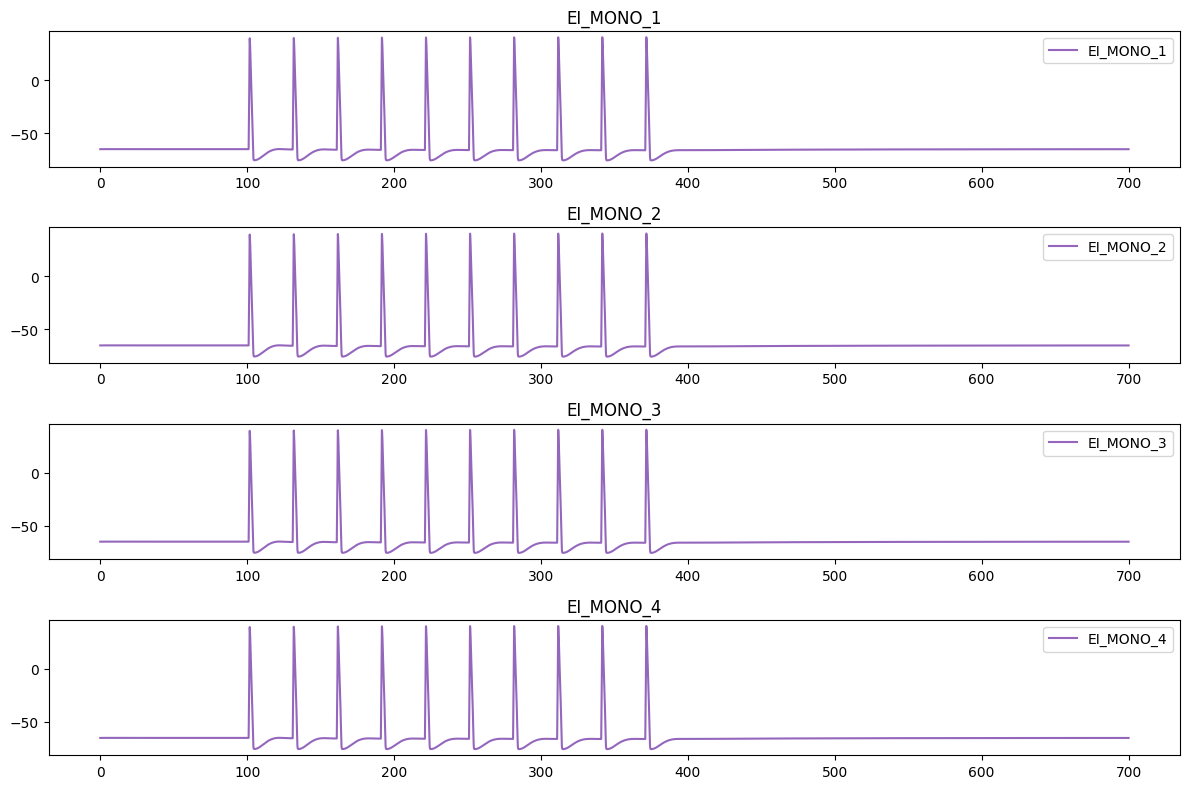

NPAX6_1 spikes: 10 times [101.35000000011448, 131.37500000011744, 161.37500000009015, 191.37500000006287, 221.37500000003558, 251.3750000000083, 281.374999999981, 311.37499999995373, 341.37499999992644, 371.37499999989916]
NPAX6_2 spikes: 10 times [101.35000000011448, 131.37500000011744, 161.37500000009015, 191.37500000006287, 221.37500000003558, 251.3750000000083, 281.374999999981, 311.37499999995373, 341.37499999992644, 371.37499999989916]
NPAX6_3 spikes: 10 times [101.35000000011448, 131.37500000011744, 161.37500000009015, 191.37500000006287, 221.37500000003558, 251.3750000000083, 281.374999999981, 311.37499999995373, 341.37499999992644, 371.37499999989916]
NPAX6_4 spikes: 10 times [101.35000000011448, 131.37500000011744, 161.37500000009015, 191.37500000006287, 221.37500000003558, 251.3750000000083, 281.374999999981, 311.37499999995373, 341.37499999992644, 371.37499999989916]
Disyn isyn_inh entries: [28001, 28001]
Mono isyn_inh entries: [0, 0, 0, 0]
EI_MONO_1 inhibitory vectors: [0,

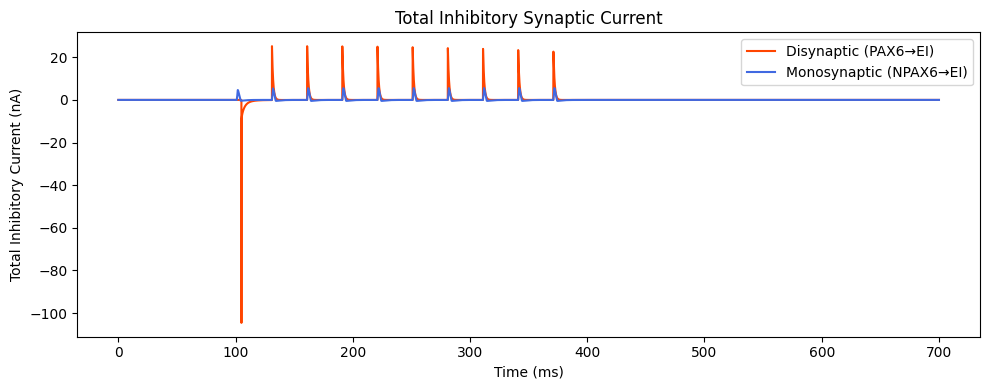

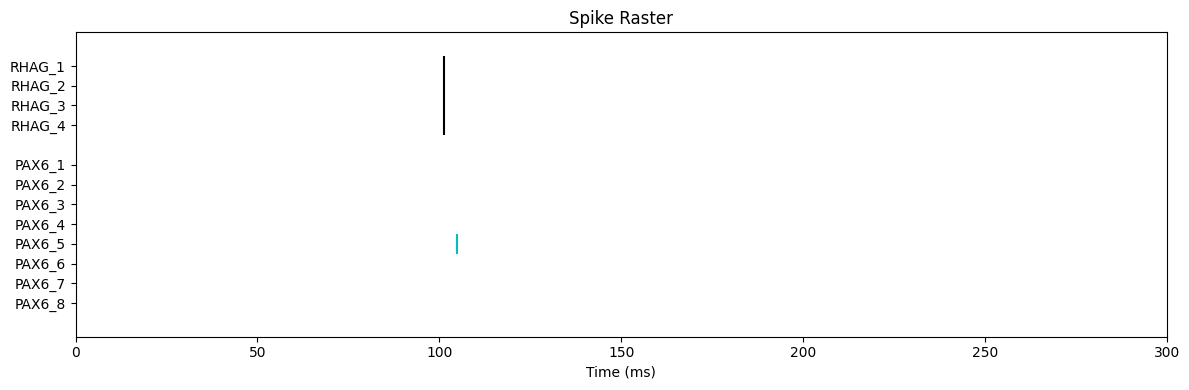

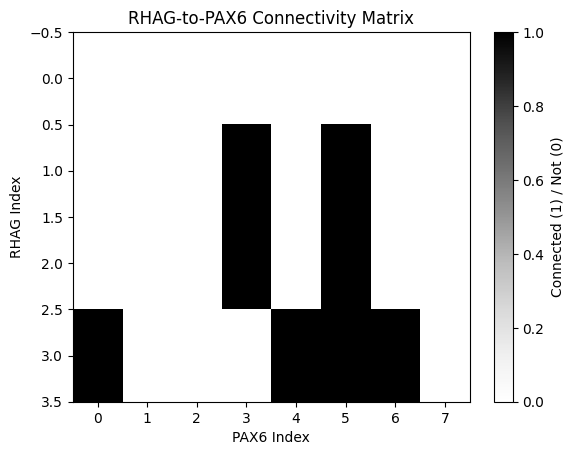

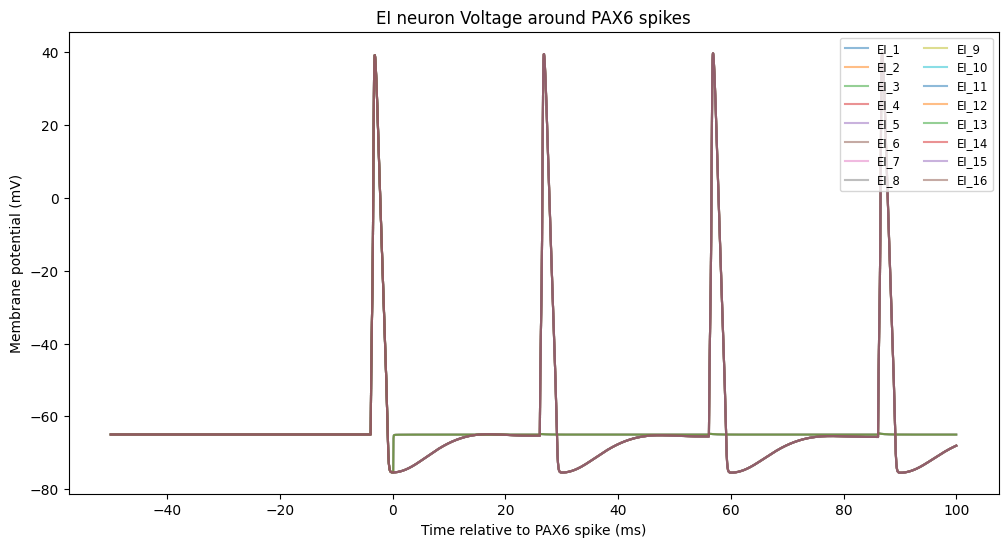

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
v = h.VecStim()


h.load_file("stdrun.hoc")

class HHNeuron:
    def __init__(self, name, adapt_gmax=0.0005, adapt_tau=100, soma_L=30, soma_diam=30):
        self.soma = h.Section(name=name)
        self.soma.L = soma_L
        self.soma.diam = soma_diam
        self.soma.Ra = 100
        self.soma.cm = 1
        self.soma.insert('hh')
        for seg in self.soma:
            seg.hh.gnabar = 0.12
            seg.hh.gkbar = 0.036
            seg.hh.gl = 0.0003
            seg.hh.el = -54.3

        self.adapt = h.Adapt(self.soma(0.5))
        self.adapt.gmax = adapt_gmax
        self.adapt.tau = adapt_tau

        self.v = h.Vector().record(self.soma(0.5)._ref_v)
        self.ina = h.Vector().record(self.soma(0.5)._ref_ina)
        self.ik = h.Vector().record(self.soma(0.5)._ref_ik)
        self.iadapt = h.Vector().record(self.adapt._ref_iadapt)
        self.m = h.Vector().record(self.soma(0.5).hh._ref_m)
        self.h_gate = h.Vector().record(self.soma(0.5).hh._ref_h)
        self.n = h.Vector().record(self.soma(0.5).hh._ref_n)
        self.spikes = h.Vector()
        self.nc = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.nc.threshold = -20
        self.nc.record(self.spikes)
        self.nc_adapt = h.NetCon(self.soma(0.5)._ref_v, self.adapt, sec=self.soma)
        self.nc_adapt.threshold = -20
        self.nc_adapt.weight[0] = 1
    
    def connect_to(self, target_syn, weight=0.1, delay=0.1):
        nc = h.NetCon(self.soma(0.5)._ref_v, target_syn, sec=self.soma)
        nc.weight[0] = weight
        nc.delay = delay
        nc.threshold = -20
        return nc


class DetonatorInput:
    def __init__(self, target_sec, tau=1, e=0, start=100, weight=0.1):
        self.syn = h.ExpSyn(target_sec(0.5))
        self.syn.e = e
        self.syn.tau = tau

        self.stim = h.NetStim()
        self.stim.start = start
        self.stim.number = 1
        self.stim.interval = 1

        self.nc = h.NetCon(self.stim, self.syn)
        self.nc.weight[0] = weight
        self.isyn = h.Vector().record(self.syn._ref_i)

class RHAGNeuron(HHNeuron):
    def __init__(self):
        super().__init__(name='rhag', adapt_gmax=0.0005, adapt_tau=100)
        self.input = DetonatorInput(self.soma, tau=1, start=100, weight = 0.1)
        self.isyn = self.input.isyn

class PAX6Neuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'pax6_{idx+1}', adapt_gmax=0.0005, adapt_tau=100)
        self.syn = h.ExpSyn(self.soma(0.5))
        self.syn.e = 0
        self.syn.tau = 1
        self.isyn = h.Vector().record(self.syn._ref_i)

class NRHAGNeuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'nrhag_{idx+1}', adapt_tau=90)
        self.input = DetonatorInput(self.soma, tau=1, start=100, weight=0.1)
        self.isyn = self.input.isyn

class ExcNeuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'exc_{idx+1}')
        # Optionally: different channel properties for excitatory neurons

class InhNeuron(HHNeuron):
    def __init__(self, idx):
        super().__init__(name=f'inh_{idx+1}')
        # Optionally: different channel properties for inhibitory neurons


#NETWORK CONSTRUCTION

num_rhag = 4
num_pax6 = 8  # Choose >=4 for more realistic overlaps; can be 4 to match your example
num_nrhag = 23  # or whatever number you want!
num_ex = 8  # or more; as desired
num_in = 8

w_mono_inhib = 1.0  # baseline weight for monosynaptic inhibition
w_disyn_inhib = 3.5 * w_mono_inhib  # 3.5 times stronger for disynaptic inhibition


# Create neuron populations
rhag_cells = [RHAGNeuron() for _ in range(num_rhag)]
nrhag_cells = [NRHAGNeuron(i) for i in range(num_nrhag)]
pax6_cells = [PAX6Neuron(idx) for idx in range(num_pax6)]
exc_neurons = [ExcNeuron(i) for i in range(num_ex)]
inh_neurons = [InhNeuron(i) for i in range(num_in)]
# -----------------------------------------------------------
# Monosynaptic inhibition: NPAX6 → EI_MONO neurons
# -----------------------------------------------------------

# Parameters
num_ei_mono = 4          # number of EI target neurons (for monosynaptic input)
num_npax6 = 4            # number of NPAX6 inhibitory source neurons
w_mono_inhib = 1.0       # baseline inhibitory weight (disynaptic will be 3.5× stronger)

# Define NPAX6 inhibitory neurons
npax6_neurons = [InhNeuron(i) for i in range(num_npax6)]

# Define a *separate* EI population for monosynaptic inhibition targets
ei_mono_neurons = [HHNeuron(name=f'ei_mono_{i+1}') for i in range(num_ei_mono)]

# Give NPAX6 neurons an input (so they spike)
for neuron in npax6_neurons:
    neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
    neuron.input.stim.number = 10
    neuron.input.stim.interval = 30

for neuron in ei_mono_neurons:
    neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
    neuron.input.stim.number = 10
    neuron.input.stim.interval = 30

# Set up monosynaptic inhibitory connections NPAX6 → EI_MONO
mono_syn_netcons = []

for npax6 in npax6_neurons:
    for target in ei_mono_neurons:
        inh_syn = h.Exp2Syn(target.soma(0.5))
        inh_syn.e = -65      # inhibitory reversal potential
        inh_syn.tau1 = 1.0   # increase tau1 slightly to avoid very sharp rise
        inh_syn.tau2 = 15.0  # slower decay (closer to experimental mono)
        # Use the NPAX6 NetStim as the source (reliable)
        nc = h.NetCon(npax6.input.stim, inh_syn)
        nc.delay = 0.1
        nc.weight[0] = 0.05  # much smaller than disyn; tune as needed

        mono_syn_netcons.append(nc)

        # Record inhibitory synaptic current onto target
        if not hasattr(target, 'isyn_inh'):
            target.isyn_inh = []
        target.isyn_inh.append(h.Vector().record(inh_syn._ref_i))



rng = np.random.default_rng()
nearest_pax6 = [rng.choice(num_pax6, size=4, replace=False) for _ in range(num_rhag)]
nearest_pax6_nrhag = [rng.choice(num_pax6, size=4, replace=False) for _ in range(num_nrhag)]
# Anatomical connection and transmission unreliability (VecStim relay method)

p_proj = 20 / 43  # connection probability
p_transmit = 0.91 # per-spike transmission probability

p_proj_nrhag = 5 / 37         # 0.135 connectivity probability
p_transmit_nrhag = 0.2        # Biologically, rarely transmit spikes


nrhag_connections = []
all_nrhag_relay_netcons = []

connections = []
all_relay_netcons = []

connections_ei = []  # keep references!
ei_syns = []

# For each PAX6 neuron, select a random set of excitatory and inhibitory neurons to target
ei_targets = []


# First simulate RHAGs to get their spike times
h.finitialize(-65)
h.continuerun(700)
spikes_rhag = [np.array(list(r.spikes)) for r in rhag_cells]

# Simulate NRHAGs separately to get their spike times
nrhag_spikes = []
for n in nrhag_cells:
    h.finitialize(-65)
    h.continuerun(700)
    nrhag_spikes.append(np.array(list(n.spikes)))


# Now, for each established connection: relay only 91% of spikes from RHAG to PAX6 using VecStim
for rhag_idx, rhag in enumerate(rhag_cells):
    for pax6_idx in nearest_pax6[rhag_idx]:
        if rng.uniform() < p_proj:
            # Only use 91% of presynaptic spikes for actual transmission
            relayed_spikes = [t+1.0 for t in spikes_rhag[rhag_idx] if rng.uniform() < p_transmit]  # 1ms delay
            if relayed_spikes:
                relay_vec = h.Vector(relayed_spikes)
                relay_stim = h.VecStim()
                relay_stim.play(relay_vec)
                nc = h.NetCon(relay_stim, pax6_cells[pax6_idx].syn)
                nc.weight[0] = 0.1
                all_relay_netcons.append(nc)  # Keep refs alive!
            connections.append((rhag_idx, pax6_idx, 0.1))
        else:
            connections.append((rhag_idx, pax6_idx, 0.0))

# NRHAG -> PAX6 VecStim relay
for nrhag_idx, nrhag in enumerate(nrhag_cells):
    for pax6_idx in nearest_pax6_nrhag[nrhag_idx]:
        if rng.uniform() < p_proj_nrhag:
            relayed_spikes = [t+1.0 for t in nrhag_spikes[nrhag_idx] if rng.uniform() < p_transmit_nrhag]
            if relayed_spikes:
                relay_vec = h.Vector(relayed_spikes)
                relay_stim = h.VecStim()
                relay_stim.play(relay_vec)
                nc = h.NetCon(relay_stim, pax6_cells[pax6_idx].syn)
                nc.weight[0] = 0.01      # <<--- USE SMALLER VALUE HERE!
                all_nrhag_relay_netcons.append(nc)
            nrhag_connections.append((nrhag_idx, pax6_idx, 0.01))
        else:
            nrhag_connections.append((nrhag_idx, pax6_idx, 0.0))

# Give PAX6 an earlier start (e.g., 90 ms), make EI input later (e.g., >=110 ms)
#for neuron in exc_neurons + inh_neurons:
    #neuron.input = DetonatorInput(neuron.soma, tau=1, start=120, weight=0.1)  # Fires after PAX6


# map EI index -> list of inhibitory NetCons it receives
ei_netcons_by_target = {i: [] for i in range(num_ex + num_in)}
ei_targets = []

# Inhibition parameters

inh_reversal = -65
inh_tau1 = 0.5      # keep fast rise
inh_tau2 = 80.0     # much longer decay -> suppresses across multiple input spikes
inh_delay  = 0.1    # nearly immediate arrival after PAX6 spike


for pax6_idx, pax6 in enumerate(pax6_cells):
    targets = rng.choice(num_ex + num_in, size=4, replace=False)
    ei_targets.append(targets)
    for idx in targets:
        if idx < num_ex:
            target = exc_neurons[idx]
        else:
            target = inh_neurons[idx - num_ex]

        inh_syn = h.Exp2Syn(target.soma(0.5))
        inh_syn.e = inh_reversal
        inh_syn.tau1 = inh_tau1
        inh_syn.tau2 = inh_tau2

        netcon = h.NetCon(pax6.soma(0.5)._ref_v, inh_syn, sec=pax6.soma)
        netcon.threshold = -20
        netcon.delay = inh_delay
        netcon.weight[0] = w_disyn_inhib

        ei_netcons_by_target[idx].append(netcon)
        ei_syns.append(inh_syn)

        # --- FIX: record from all targets ---
        if not hasattr(target, 'isyn_inh'):
            target.isyn_inh = []
        target.isyn_inh.append(h.Vector().record(inh_syn._ref_i))




# Collect indices of all EI neurons targeted for silencing by any PAX6
silenced_indices = set()
for targets in ei_targets:
    silenced_indices.update(targets)

for neuron in exc_neurons + inh_neurons:
    # 10 spikes at intervals of 30 ms starting at 100 ms
    neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
    neuron.input.stim.number = 10
    neuron.input.stim.interval = 30


# Assign DetonatorInput ONLY to EI neurons NOT in silenced_indices
#for i, neuron in enumerate(exc_neurons + inh_neurons):
#    if i not in silenced_indices:
#        neuron.input = DetonatorInput(neuron.soma, tau=1, start=120, weight=0.1)
    # No input for silenced neurons means they remain silent (flat)



# Initialize t vector just once
t = h.Vector().record(h._ref_t)


#SIMULATION

# Assign DetonatorInput for multiple spikes ONLY to non-silenced EI neurons
# First, determine the indices to silence by running a quick simulation

# Assign input to all by default
for neuron in exc_neurons + inh_neurons:
    neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
    neuron.input.stim.number = 10
    neuron.input.stim.interval = 30



# SIMULATE
h.finitialize(-65)
h.continuerun(700)

# Find triggered PAX6 (those that spike)
def vnp(v): return np.array(list(v))
def arrlst(lst): return [np.array(list(x)) for x in lst]
spikes_pax6_np = arrlst([p.spikes for p in pax6_cells])
triggered_pax6_indices = [idx for idx, s in enumerate(spikes_pax6_np) if len(s) > 0]
silenced_indices = set()
for idx in triggered_pax6_indices:
    silenced_indices.update(ei_targets[idx])

w_silence = 50.0  # Or tune as needed
for ei_idx, netcons in ei_netcons_by_target.items():
    for nc in netcons:
        if ei_idx in silenced_indices:
            nc.weight[0] = w_silence   # strengthen inhibition when PAX6 spikes
        else:
            nc.weight[0] = w_disyn_inhib


# Assign input ONLY to non-silenced indices (overwrite previous input for silenced ones)
#for i, neuron in enumerate(exc_neurons + inh_neurons):
#    if i in silenced_indices:
#        neuron.input.stim.number = 0  # disables all presynaptic spikes for the NetStim
#    else:
#        neuron.input = DetonatorInput(neuron.soma, tau=1, start=100, weight=0.1)
#        neuron.input.stim.number = 10
#        neuron.input.stim.interval = 30

# SIMULATE again for final output!
h.finitialize(-65)
h.continuerun(700)


#DATA EXTRACTION

# Convert t only once
t_np = np.array(list(t))

v_rhag = [vnp(r.v) for r in rhag_cells]
ina_rhag = [vnp(r.ina) for r in rhag_cells]
ik_rhag = [vnp(r.ik) for r in rhag_cells]
iadapt_rhag = [vnp(r.iadapt) for r in rhag_cells]
isyn_rhag = [vnp(r.isyn) for r in rhag_cells]
spikes_rhag = [vnp(r.spikes) for r in rhag_cells]

v_pax6 = [vnp(p.v) for p in pax6_cells]

isyn_pax6_np = arrlst([p.isyn for p in pax6_cells])
iadapt_pax6_np = arrlst([p.iadapt for p in pax6_cells])
# Data extraction for NRHAG
v_nrhag = [vnp(n.v) for n in nrhag_cells]
ina_nrhag = [vnp(n.ina) for n in nrhag_cells]
ik_nrhag = [vnp(n.ik) for n in nrhag_cells]
iadapt_nrhag = [vnp(n.iadapt) for n in nrhag_cells]
spikes_nrhag = [vnp(n.spikes) for n in nrhag_cells]



#PLOTTING

plt.figure(figsize=(12, 2 * num_rhag))
for i, v in enumerate(v_rhag):
    plt.subplot(num_rhag, 1, i + 1)
    plt.plot(t_np, v, label=f'RHAG_{i+1}', color='k')
    plt.ylabel('V_m (mV)')
    plt.title(f'Membrane Potential: RHAG_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

# Plot NRHAG membrane potentials
plt.figure(figsize=(12, 2 * num_nrhag))
for i, v in enumerate(v_nrhag):
    plt.subplot(num_nrhag, 1, i + 1)
    plt.plot(t_np, v, label=f'NRHAG_{i+1}', color='b')
    plt.ylabel('V_m (mV)')
    plt.title(f'Membrane Potential: NRHAG_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 2 * num_pax6))
for i, v in enumerate(v_pax6):
    plt.subplot(num_pax6, 1, i + 1)
    plt.plot(t_np, v, label=f'PAX6_{i+1}', color=['r','g','b','m','c','y','k','orange'][i % 8])
    plt.ylabel('V_m (mV)')
    plt.title(f'Membrane Potential: PAX6_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()


# Synaptic currents for each PAX6 neuron
plt.figure(figsize=(12, 2 * num_pax6))
import itertools
colors = itertools.cycle(['r', 'g', 'b', 'm', 'c', 'y', 'k', 'orange'])
for idx, isyn in enumerate(isyn_pax6_np):
    plt.subplot(num_pax6, 1, idx + 1)
    plt.plot(t_np, isyn, color=next(colors), label=f'PAX6_{idx + 1} syn current')
    plt.ylabel('I_syn (nA)')
    plt.legend()
    plt.title(f'Synaptic Current into PAX6_{idx + 1}')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2 * (num_rhag + num_pax6)))
for i, ia in enumerate(iadapt_rhag):
    plt.subplot(num_rhag + num_pax6, 1, i + 1)
    plt.plot(t_np, ia, label=f'RHAG_{i+1} Adapt', color='k')
    plt.ylabel('I_adapt')
    plt.title(f'Adaptation Current: RHAG_{i+1}')
    plt.xlim(0, 300)
    plt.legend()
for idx, ia in enumerate(iadapt_pax6_np):
    plt.subplot(num_rhag + num_pax6, 1, num_rhag + idx + 1)
    plt.plot(t_np, ia, label=f'PAX6_{idx+1} Adapt', color=['r','g','b','m','c','y','k','orange'][idx % 8])
    plt.ylabel('I_adapt')
    plt.title(f'Adaptation Current: PAX6_{idx+1}')
    plt.xlim(0, 300)
    plt.legend()
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()


print(f"RHAG spikes: {len(spikes_rhag)} at times {spikes_rhag}")
print(f"NRHAG spikes: {len(spikes_nrhag)} at times {spikes_nrhag}")

for idx, s in enumerate(spikes_pax6_np):
    print(f"PAX6_{idx+1} spikes: {len(s)} at times {s}")

for rhag_idx in range(num_rhag):
    partners = [pax6_idx for (r_idx, pax6_idx, w) in connections if r_idx == rhag_idx and w > 0.0]
    print(f"RHAG_{rhag_idx+1} projects to PAX6 neurons: {partners}")
for pax6_idx in range(num_pax6):
    sources = [r_idx+1 for (r_idx, p_idx, w) in connections if p_idx==pax6_idx and w > 0.0]
    print(f"PAX6_{pax6_idx+1} receives from RHAGs: {sources}")

for nrhag_idx in range(num_nrhag):
    partners = [pax6_idx for (n_idx, pax6_idx, w) in nrhag_connections if n_idx == nrhag_idx and w > 0.0]
    print(f"NRHAG_{nrhag_idx+1} projects to PAX6 neurons: {partners}")

for pax6_idx in range(num_pax6):
    sources = [n_idx+1 for (n_idx, p_idx, w) in nrhag_connections if p_idx==pax6_idx and w > 0.0]
    print(f"PAX6_{pax6_idx+1} receives from NRHAGs: {sources}")

for idx, targets in enumerate(ei_targets):
    ei_labels = []
    for t in targets:
        if t < num_ex:
            ei_labels.append(f'E{t+1}')
        else:
            ei_labels.append(f'I{t+1-num_ex}')
    print(f'PAX6_{idx+1} targets: {ei_labels}')

# Excitatory neurons
plt.figure(figsize=(12, 2*num_ex))
for i, neuron in enumerate(exc_neurons):
    plt.subplot(num_ex, 1, i+1)
    plt.plot(t_np, vnp(neuron.v), color='tab:blue', label=f'Exc_{i+1}')
    plt.title(f"EXC_{i+1}")
    plt.legend()
plt.tight_layout()
plt.show()

# Inhibitory neurons
plt.figure(figsize=(12, 2*num_in))
for i, neuron in enumerate(inh_neurons):
    plt.subplot(num_in, 1, i+1)
    plt.plot(t_np, vnp(neuron.v), color='tab:red', label=f'Inh_{i+1}')
    plt.title(f"INH_{i+1}")
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2 * num_ei_mono))
for i, neuron in enumerate(ei_mono_neurons):
    plt.subplot(num_ei_mono, 1, i+1)
    plt.plot(t_np, vnp(neuron.v), color='tab:purple', label=f'EI_MONO_{i+1}')
    plt.title(f'EI_MONO_{i+1}')
    plt.legend()
plt.tight_layout()
plt.show()

for idx, n in enumerate(npax6_neurons):
    print(f"NPAX6_{idx+1} spikes: {len(list(n.spikes))} times {list(n.spikes)}")

#Mono vs Di synaptic inhibition
print("Disyn isyn_inh entries:", [len(vec) for vec in getattr(exc_neurons[0], 'isyn_inh', [])])
print("Mono isyn_inh entries:", [len(vec) for vec in getattr(ei_mono_neurons[0], 'isyn_inh', [])])
print("EI_MONO_1 inhibitory vectors:", [len(vec) for vec in ei_mono_neurons[0].isyn_inh])
print("t_np length:", len(t_np))

for i, n in enumerate(ei_mono_neurons):
    for j, vec in enumerate(n.isyn_inh):
        vec_np = vec.as_numpy()
        print(f"EI_MONO_{i+1} inh vec {j} length: {len(vec_np)}, sum: {np.sum(vec_np)}")

isyn_disyn = np.sum(
    [vec.as_numpy() for n in exc_neurons+inh_neurons if hasattr(n, 'isyn_inh') for vec in n.isyn_inh],
    axis=0
)
isyn_mono_list = []
for n in ei_mono_neurons:
    if hasattr(n, 'isyn_inh'):
        for vec in n.isyn_inh:
            vec_np = vec.as_numpy()
            if len(vec_np) == len(t_np):
                isyn_mono_list.append(vec_np)
            elif len(vec_np) == 0:
                isyn_mono_list.append(np.zeros(len(t_np)))  # pad empty vectors
            else:
                # If vector is shorter, pad to match t_np
                padded = np.zeros(len(t_np))
                padded[:len(vec_np)] = vec_np
                isyn_mono_list.append(padded)

isyn_mono = np.sum(isyn_mono_list, axis=0)


minlen = min(len(t_np), len(isyn_disyn), len(isyn_mono))
plt.figure(figsize=(10, 4))
plt.plot(t_np[:minlen], isyn_disyn[:minlen], label="Disynaptic (PAX6→EI)", color='orangered')
plt.plot(t_np[:minlen], isyn_mono[:minlen],  label="Monosynaptic (NPAX6→EI)", color='royalblue')
plt.title("Total Inhibitory Synaptic Current")
plt.xlabel("Time (ms)")
plt.ylabel("Total Inhibitory Current (nA)")
plt.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 4))
all_spikes = spikes_rhag + spikes_pax6_np
lineoffsets = list(range(num_rhag, 0, -1)) + list(range(-1, -num_pax6-1, -1))
plt.eventplot(all_spikes, lineoffsets=lineoffsets, colors=['k']*num_rhag + ['r','g','b','m','c','y','k','orange'][:num_pax6])
plt.yticks(
    list(range(num_rhag, 0, -1)) + list(range(-1, -num_pax6-1, -1)),
    [f'RHAG_{i+1}' for i in range(num_rhag)] + [f'PAX6_{i+1}' for i in range(num_pax6)]
)
plt.xlim(0, 300)
plt.xlabel('Time (ms)')
plt.title('Spike Raster')
plt.tight_layout()
plt.show()

conn_matrix = np.zeros((num_rhag, num_pax6))
for r, p, w in connections:
    if w > 0: conn_matrix[r, p] = 1
plt.imshow(conn_matrix, aspect='auto', cmap='Greys')
plt.xlabel('PAX6 Index')
plt.ylabel('RHAG Index')
plt.title('RHAG-to-PAX6 Connectivity Matrix')
plt.colorbar(label="Connected (1) / Not (0)")
plt.show()


#Plot of EI neurons before and after PAX6 neurons spike:
window_pre = 50   # ms before spike
window_post = 100 # ms after spike

plt.figure(figsize=(12, 6))
for pax6_idx in triggered_pax6_indices:
    spike_times = spikes_pax6_np[pax6_idx]
    for spike_time in spike_times:
        start_t = spike_time - window_pre
        end_t = spike_time + window_post

        # Find indices in t_np for this window
        idx_start = np.searchsorted(t_np, start_t)
        idx_end = np.searchsorted(t_np, end_t)

        for i, neuron in enumerate(exc_neurons + inh_neurons):
            vm = np.array(list(neuron.v))
            plt.plot(t_np[idx_start:idx_end] - spike_time, vm[idx_start:idx_end], label=f'EI_{i+1}' if spike_time == spike_times[0] else "", alpha=0.5)

plt.title('EI neuron Voltage around PAX6 spikes')
plt.xlabel('Time relative to PAX6 spike (ms)')
plt.ylabel('Membrane potential (mV)')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.show()
